In [1]:
import pandas as pd
import numpy as np
import itertools
from itertools import chain
import csv
import re
import nltk
from tqdm import tqdm
import random
from sklearn.model_selection import KFold
import time
import matplotlib.pyplot as plt
import datetime
from sentence_transformers import SentenceTransformer
import pickle
import os
from tokenizers import BertWordPieceTokenizer
from transformers import BertTokenizer, BertConfig, BertForSequenceClassification, TrainingArguments, AutoModelForSequenceClassification, DataCollatorWithPadding, Trainer, AutoTokenizer, TFBertModel, BertModel
import torch
import torch.nn as nn
from sklearn.linear_model import LogisticRegressionCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import seaborn as sns
import statsmodels.api as sm
from scipy import stats
from collections import Counter
import spacy
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB, GaussianNB
from sklearn.metrics import classification_report
from gensim.models import Word2Vec
from gensim.models.keyedvectors import KeyedVectors
from datasets import Dataset, DatasetDict
from evaluate import load
from sklearn.utils.class_weight import compute_class_weight
from sklearn.preprocessing import OneHotEncoder
from sklearn.ensemble import RandomForestClassifier

nltk.download('averaged_perceptron_tagger_eng')

[nltk_data] Downloading package averaged_perceptron_tagger_eng to
[nltk_data]     C:\Users\woute\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger_eng is already up-to-
[nltk_data]       date!


True

In [2]:
def import_communication_data(path: str, preprocess:bool = True, remove_signoff:bool = True, newline:str = r'_/n_', reply_signs:list = None, code_words:list = None, remove_bots:bool = True, remove_names:bool = True, negation_preprocessing:bool = False, emoticon_preprocessing:bool = True, token_removal:bool = True) -> pd.DataFrame:
    print('Importing data...')
    raw_data = pd.read_csv(path, parse_dates=['reply_datetimetz']).dropna(axis = 0, subset = ['reply_from', 'reply_id', 'reply_subject', 'reply_body'])
    # Remove URLs
    raw_data['reply_body'] = raw_data['reply_body'].str.replace(r'http[s]?://(?:[a-zA-Z]|[0-9]|[$\-_@.&+#]|[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+', '', regex = True)

    if raw_data.dtypes['reply_datetimetz']=='object':
        raw_data['reply_datetimetz'] = pd.to_datetime(raw_data['reply_datetimetz'], format = 'mixed')
    raw_data.reply_datetimetz = raw_data.reply_datetimetz.dt.tz_localize(tz = 'UTC')

    regex_newline = newline.replace('/', r'\/')
    if not preprocess:
        raw_data['reply_body'] = raw_data['reply_body'].str.replace(regex_newline, ' ', regex = True)
        raw_data['reply_subject'] = raw_data['reply_subject'].str.replace(regex_newline, ' ', regex = True)
        raw_data['reply_body'] = raw_data['reply_body'].str.replace(r'\s\s+', ' ', regex = True)
        return raw_data
        
    
    # raw_data['reply_body'] = raw_data['reply_body'].str.replace(newline+'.*\(\).*'+newline, regex = True) # remove most code, as we remove all sentences where brackets do not contain any information --> Tekst over code willen we erin houden
    tqdm.pandas()
    print('Removing replies...')
    raw_data['reply_body'] = raw_data['reply_body'].str.replace('(?:'+regex_newline+'\s*)+>.*?(?='+regex_newline+')', '', regex = True) # remove all replies, signified with > before the start of a sentence
    raw_data['reply_body'] = raw_data['reply_body'].str.replace('(?:'+regex_newline+r'\s*)+\|.*?(?='+regex_newline+')', '', regex = True) # remove all replies signified with | before the start of a sentence
    print('Removing Unnecessary code-like text...')
    raw_data['reply_body'] = raw_data['reply_body'].str.replace('-----BEGIN PGP SIGNED MESSAGE-----', '')
    raw_data['reply_body'] = raw_data['reply_body'].str.replace('----- GICM -----', '')
    raw_data['reply_body'] = raw_data['reply_body'].str.replace('----- SERVER -----.*$', '', regex = True)
    raw_data['reply_body'] = raw_data['reply_body'].str.replace('----- CLIENT -----.*$', '', regex = True)
    raw_data['reply_body'] = raw_data['reply_body'].str.replace(r'-----+\s* logs follow -----.*$', '', regex = True)
    
    raw_data['reply_body'] = raw_data['reply_body'].str.replace('-----cut here-----.*-----cut here-----', '', regex = True)
    raw_data['reply_body'] = raw_data['reply_body'].str.replace('-----8<-----.*-----8<-----', '', regex = True)
    raw_data['reply_body'] = raw_data['reply_body'].str.replace('-----BEGIN PGP SIGNATURE-----.*-----END PGP SIGNATURE-----', '', regex = True)
    raw_data['reply_body'] = raw_data['reply_body'].str.replace(r'(?:^|'+regex_newline+r')((?:(?!'+regex_newline+r').)*?[Ww]rote:)', '', regex = True)
    raw_data['reply_body'] = raw_data['reply_body'].str.replace('----- start patch -----.*----- end patch -----', '', regex = True)
    raw_data['reply_body'] = raw_data['reply_body'].str.replace('----- start -----.*----- end -----', '', regex = True)
    raw_data['reply_body'] = raw_data['reply_body'].str.replace('-----+Build Errors-----.*error[^'+regex_newline+']*'+regex_newline, newline, regex = True)
    raw_data['reply_body'] = raw_data['reply_body'].str.replace(r'([+\-]*-----\+-----[+\-]*)'+regex_newline +r'.*([+\-]*-----\+-----[+\-]*)', r'\2', regex = True)
    raw_data['reply_body'].str.replace(r'([+\-]*-----+-----[+\-]*)', r'', regex = True)
    raw_data['reply_body'] = raw_data['reply_body'].str.replace('----- Forwarded [mM]essage -----.*----- End forwarded message -----', '', regex = True)
    
    
    if remove_signoff:
        print('Removing Sign-offs...')
        raw_data['reply_body'] = raw_data['reply_body'].str.replace(regex_newline+r'\s*-+[a-zA-Z ]*\s*'+regex_newline+r'[^\-]*-*([^\-]|(\d(-\d)+))*($|([Pp].[Ss].))', '\\4', regex = True)
    
    if reply_signs:
        print('Removing e-mail replies...')
        for reply in tqdm(reply_signs):
            raw_data['reply_body'] = raw_data['reply_body'].str.replace(reply+'.*$', '', regex = True)
            
    if code_words:
        print('Removing code words...')
        for word in tqdm(code_words):
            raw_data['reply_body'] = raw_data['reply_body'].str.replace(r'\s' + word + r'\s', '', regex = True)
    
    if remove_bots:
        print('Removing bots from entries...')
        raw_data = raw_data[~raw_data['reply_from'].str.contains(r'[\(\[\-]bot(?:[\)\]]|$)', case = False)]
        
    if remove_names:
        print('Removing Names...')
        # In order:
        # Remove quotation marks
        # Remove stuff between brackets (vaak email adressen)
        # Remove Email adresses still left in name
        # Remove dots from the name
        # Remove things added to the end of a name after - (often company of employment) (require whitespaces to make sure second names are not affected)
        # Remove entries which contain an x with a set of numbers succeeding it, as this is likely introduced by a unknown character
        # Retrieve nickname, which is usually posted between two backslashes (\...\)
        # If there is only one character (often one letter left from 2nd name/abbreviation at the start of the name), remove it
        # Remove the extra space surrounding a | token
        # Remove additional white spaces at the start/end of a token
        # Remove multiple white spaces after each other
        # Remove test and test account from the set of names
        names = set(itertools.chain(*raw_data.reply_from.str.replace('"', '').str.replace("[<(].*[>)]", '', regex = True).str.replace(r"[a-zA-Z0-9.\-_]+@\w+(.\w\w+)+", '', regex = True).str.replace('.', '').str.replace(r'\s-\s\w+($|\|)', '', regex = True).str.replace(r'(^|\|)\s*(.*),\s*(.*)($|\|)', '\\1\\3 \\2', regex = True).str.replace(r'x\d+', '', regex = True).str.replace(r'(^|\|)([^|]*)\\([^\\]+)\\([^|]*)(\||$)', '\\1\\2 \\4|\\3\\5', regex = True).str.replace(r'(^|\s)[^\|](\s|$)', ' ', regex = True).str.replace(r'\s+\|\s+', '|', regex = True).str.strip().str.replace(r'\s\s+', ' ', regex = True).str.split('|').to_list())).difference({'Test', 'Test Account', 'test', 'test account'})
        
        first_names = {name.split(' ')[0] for name in names}
        
        for name in tqdm(names):
            raw_data['reply_body'] = raw_data['reply_body'].str.replace(r'\s+'+name+r'\s+', '', regex = True, case = False)
            
        for name in tqdm(first_names):
            raw_data['reply_body'] = raw_data['reply_body'].str.replace(r'\s+'+name+r'\s+', '', regex = True, case = False)
        
    with open("SentiCR/SentiCR/Contractions.txt","r") as contractions,\
     open("SentiCR/SentiCR/EmoticonLookupTable.txt","r") as emotable:
        contractions_reader=csv.reader(contractions, delimiter='\t')
        emoticon_reader=csv.reader(emotable,delimiter='\t')
    
        #Hash words from dictionary with their values
        contractions_dict = {rows[0]:rows[1] for rows in contractions_reader}
        emodict={rows[0]:rows[1] for rows in emoticon_reader}
    
        contractions.close()
        emotable.close()
        
    print('Removing contractions...')
    contractions_regex = re.compile('(%s)' % '|'.join(contractions_dict.keys()))
    raw_data['reply_body'] = raw_data['reply_body'].progress_apply(lambda x: expand_contractions(x, contractions_dict, contractions_regex))
    
    if emoticon_preprocessing:
        print('Removing emoticons...')
        for emoticon in tqdm(emodict):
            raw_data['reply_body'] = raw_data['reply_body'].str.replace(emoticon, emodict[emoticon])
            
    if negation_preprocessing:
        print('Negating text...')
        raw_data['reply_body'] = raw_data['reply_body'].progress_apply(lambda x: handle_negation(x))
        
    
    print('Removing infrequent words...')

    # split words into lists
    v = raw_data['reply_body'].str.split().tolist() # [s.split() for s in df['Col2'].tolist()]
    # compute global word frequency
    c = Counter(chain.from_iterable(v))
    # filter, join, and re-assign
    raw_data['reply_body'] = [' '.join([j for j in i if c[j] > 5]) for i in v]
        
    raw_data['reply_body'] = raw_data['reply_body'].str.replace(regex_newline, ' ', regex = True)
    raw_data['reply_subject'] = raw_data['reply_subject'].str.replace(regex_newline, ' ', regex = True)
    raw_data['reply_body'] = raw_data['reply_body'].str.replace(r'\s\s+', ' ', regex = True)
    return raw_data
    
   
def import_dev_data(path:str, communication_data:pd.DataFrame = None, model = None, tokenizer = None, LR:bool = False, bert_messages:pd.DataFrame = None) -> pd.DataFrame:
    tqdm.pandas()
    print('Importing dev data')
    data = pd.read_csv(path, parse_dates=['From','To'])
    
    dates = data.From.unique()
    data.set_index(['Alias', 'From'], inplace = True)
    data['Messages Sent'] = data['Messages Sent'].fillna(0)
    
    print('Calculating Seasonality...')
    monthly_average = data.groupby(data.index.get_level_values('From').month)['Workload'].mean()
    mapped_monthly_average = data.index.get_level_values('From').map(lambda x: monthly_average.loc[x.month])
    
    data['standardized_workload'] = data['Workload']/mapped_monthly_average
    
    
    data['burnout'] = np.nan
    print('Calculating burnout per dev...')
    for developer in tqdm(data.index.levels[0].unique()):
        data = calculate_burnout(developer, data)
       
    print('Calculating lagged burnouts...')
    data['lagged_burnout'] = data.groupby(level=0)['burnout'].shift(periods = -1)
    data['burnout_t+1'] = data.apply(lambda x: calculate_lagged_burnout(x), axis = 1)
    data['burnout_t+3'] = (data.groupby(level=0)['burnout'].shift(periods = -3)) | (data.groupby(level=0)['burnout'].shift(periods = -2)) | (data['burnout_t+1']) 
    data['burnout_t+12'] = (data.groupby(level=0)['burnout'].shift(periods = -12)) | (data.groupby(level=0)['burnout'].shift(periods = -11)) | (data.groupby(level=0)['burnout'].shift(periods = -10)) |(data.groupby(level=0)['burnout'].shift(periods = -9)) | (data.groupby(level=0)['burnout'].shift(periods = -8)) |(data.groupby(level=0)['burnout'].shift(periods = -7)) | (data.groupby(level=0)['burnout'].shift(periods = -6)) |(data.groupby(level=0)['burnout'].shift(periods = -5)) | (data.groupby(level=0)['burnout'].shift(periods = -4)) | (data['burnout_t+3']) 
    
    print('Calculating Black Cloud...')
    data['black_cloud'] = (data['Radio Silence']) & (data.groupby(level = 0)['Radio Silence'].shift(periods = 1))
    
    if communication_data is None:
        # If we have not provided any communication_data, we only need the dev data
        return data
    
    print('Calculating quitting months')
    data['working_months'] = True # Indicate which months originally are worked in
    retrieved_dates = pd.Series(data.index.get_level_values(1).rename('Temp')).set_axis(data.index)
    # Quit happens when there are 3 consecutive months in which no work is performed or after the final month of work (which is not equivalent to the final month in the df)
    data['quit'] = (((data.Workload.isna()) &
                     (((data.groupby(level=0)['Workload'].shift(periods = -1).isna()) & (data.groupby(level=0)['Workload'].shift(periods = -2).isna())) |
                      ((data.groupby(level=0)['Workload'].shift(periods = -1).isna()) & (data.groupby(level=0)['Workload'].shift(periods = 1).isna())) |
                      ((data.groupby(level=0)['Workload'].shift(periods = 1).isna()) & (data.groupby(level=0)['Workload'].shift(periods = 2))))) | 
                    ((data.groupby(level=0)['working_months'].shift(periods = -1).isna()) & (retrieved_dates < max(retrieved_dates))) | 
                    ((data.groupby(level=0)['Workload'].shift(periods = -1).isna()) & (data.groupby(level=0)['Workload'].shift(periods = -2).isna()) & (data.groupby(level=0)['Workload'].shift(periods = -3).isna())))
    
    data['first_quit_month'] = ((data['quit']) & (~data.Workload.isna()))
    
    print('Calculating ragequit...')
    if bert_messages is None:
        data['ragequit_t+1'] = data.progress_apply(lambda x: detect_ragequit(x, communication_data, model, tokenizer), axis = 1)
    else:
        data['ragequit_t+1'] = data.progress_apply(lambda x: detect_ragequit(x, bert_messages, model, tokenizer), axis = 1)
    print('Calculating lagged ragequits...')
    data['ragequit_t+3'] = (data.groupby(level=0)['ragequit_t+1'].shift(periods = -2)) | (data.groupby(level=0)['ragequit_t+1'].shift(periods = -1)) | (data['ragequit_t+1']) 
    data['ragequit_t+12'] = (data.groupby(level=0)['ragequit_t+1'].shift(periods = -11)) | (data.groupby(level=0)['ragequit_t+1'].shift(periods = -10)) | (data.groupby(level=0)['ragequit_t+1'].shift(periods = -9)) |(data.groupby(level=0)['ragequit_t+1'].shift(periods = -8)) | (data.groupby(level=0)['ragequit_t+1'].shift(periods = -7)) |(data.groupby(level=0)['ragequit_t+1'].shift(periods = -6)) | (data.groupby(level=0)['ragequit_t+1'].shift(periods = -5)) |(data.groupby(level=0)['ragequit_t+1'].shift(periods = -4)) | (data.groupby(level=0)['ragequit_t+1'].shift(periods = -3)) | (data['ragequit_t+3']) 
    
    if LR:
        return data
    
    print('Reformatting communication dates')
    communication_data['reply_datetimetz'] = pd.to_datetime(communication_data['reply_datetimetz'], utc = True)
    communication_data['start_month'] = communication_data.progress_apply(lambda x: return_closest_date(x, dates), axis = 1)
    return communication_data.merge(data, how = 'left', left_on= ['reply_from', 'start_month'], right_index = True)

def import_network_data(path:str, communication_data:pd.DataFrame, communication:bool = True):
    print('Retrieving and combining network data...')
    network_data = pd.read_csv(path, parse_dates = ['start_datetime', 'end_datetime'])
    if communication:
        return communication_data.merge(network_data, how = 'left', left_on = 'start_month', right_on = 'start_datetime')
    else:
        communication_data.reset_index(inplace = True)
        return communication_data.merge(network_data, how = 'left', left_on = 'From', right_on = 'start_datetime')
    
    
def calculate_burnout(developer: str, all_dev_data: pd.DataFrame, decrease_percentage:float = 0.2, range = 3):
    all_days = pd.date_range(
        min(all_dev_data[all_dev_data.index.get_level_values('Alias') == developer].index.get_level_values('From')), 
        max(all_dev_data[all_dev_data.index.get_level_values('Alias') == developer].index.get_level_values('From')), 
        freq='30d')
    res_lst = []
    min_date = min(all_dev_data[all_dev_data.index.get_level_values('Alias') == developer].index.get_level_values('From'))+datetime.timedelta(days = range*30)
    for date in all_days:
        try:
            # Use try-except loop to include dates where there is no workload
            if date < min_date:
                # Cannot check the previous month for burnout, nor calculate it following the given definition of burnout, return NaN
                is_burnt_out = np.nan
            elif date == min_date:
                # For the fourth month, we simply have to calculate whether the deviation holds
                burnout_data = all_dev_data[(all_dev_data.index.get_level_values('Alias') == developer) & (all_dev_data.index.get_level_values('From') < date)]
                # Calculating the deviation, If there are too little entries, return NaN
                if len(burnout_data) < (2/3)*range:
                    is_burnt_out = np.nan
                else:
                    is_burnt_out = all_dev_data.at[(developer, date), 'standardized_workload'] < burnout_data.standardized_workload.median() * (1-decrease_percentage)
            else:
                # We first have to retrieve the last of the previous months which were not burnt-out to find the baseline
                if False in res_lst:
                    no_burnout_month = len(res_lst) - 1 - res_lst[::-1].index(False)
                    burnout_data = all_dev_data[(all_dev_data.index.get_level_values('Alias') == developer) & (all_days[no_burnout_month] < all_dev_data.index.get_level_values('From'))& (all_dev_data.index.get_level_values('From') < all_days[no_burnout_month+range])]
                    # Calculating the deviation, If there are too little entries, return NaN
                    if len(burnout_data) < (2/3)*range:
                        is_burnt_out = np.nan
                    else:
                        is_burnt_out = all_dev_data.at[(developer, date), 'standardized_workload'] < burnout_data.standardized_workload.median() * (1-decrease_percentage)
                    
                else:
                    # We need to compare the workload level of this month to the first 3 in accordance with date == min_date
                    burnout_data = all_dev_data[(all_dev_data.index.get_level_values('Alias') == developer) & (all_dev_data.index.get_level_values('From') < min_date)]
                    # Calculating the deviation, If there are too little entries, return NaN
                    if len(burnout_data) < (2/3)*range:
                        is_burnt_out = np.nan
                    else:
                        is_burnt_out = all_dev_data.at[(developer, date), 'standardized_workload'] < burnout_data.standardized_workload.median() * (1-decrease_percentage)
        except:
            # Happens when there is no workload in a given month
            is_burnt_out = np.nan
                        
        res_lst.append(is_burnt_out)
            
    res_df = pd.DataFrame({'burnout':res_lst, 'extra':res_lst}, index = pd.MultiIndex.from_tuples(itertools.product([developer], all_days), names = ['Alias', 'From']))
    # Create the rows with the new months 
    all_dev_data = all_dev_data.merge(res_df[['extra']], how = 'outer', left_index = True, right_index=True).drop('extra', axis = 1)
    # Fill the burnout of the all_dev_data
    return all_dev_data.combine_first(res_df).drop('extra', axis = 1)

def calculate_lagged_burnout(data: pd.Series) -> bool:
    if np.isnan(data.burnout):
        return data.lagged_burnout
    elif np.isnan(data.lagged_burnout):
        return data.burnout
    else: 
        return data.burnout or data.lagged_burnout
        

def detect_ragequit(dev_data: pd.Series, communication_data: pd.DataFrame, model, tokenizer):
    if not dev_data.quit:
        # Can never be ragequit if dev hasn't quit
        return False
    elif dev_data.first_quit_month:
        # Dev will quit somewhere in this time period, therefore, we will need to retrieve the closest message to the end of the month to analyse
        last_date = dev_data.To
    else:
        # Not accurate if there is still communication months after the work has stopped, but feels like necessary evil to reduce calculation times and to refrain from having to go through the entire dataframe to search for the first_quit_month
        last_date = dev_data.name[1]
        
    
    dev_name = dev_data.name[0]
    try:
        dev_communication = communication_data[(communication_data.reply_from == dev_name) & (pd.to_datetime(communication_data.reply_datetimetz) < last_date)]
        last_message = dev_communication[dev_communication['reply_datetimetz'] == max(dev_communication.reply_datetimetz)].iloc[0]['reply_body']
        inputs = tokenizer(last_message, return_tensors = 'pt')
        softmax = torch.nn.functional.softmax(model(**inputs)['logits'], dim=-1)
        return softmax[0,2].item() > softmax[0,1].item() and softmax[0,2].item() > 0.15
    
    except:
        # If the developer has no messages (before the quitting date), the previous code would return an error, therefore, these developers do not rage quit, but rather silently quit
        return False
    
# def calculate_future_burnout_3(observation: pd.Series, data: pd.DataFrame) -> bool:
#     if 
        

def return_closest_date(reply: pd.Series, date_range: list):
    return date_range[pd.Series([reply.reply_datetimetz - date if (reply.reply_datetimetz - date) > datetime.timedelta(seconds = 0) else datetime.timedelta(days = 50) for date in date_range]).idxmin()]

def expand_contractions(s, contractions_dict, contractions_regex):
     def replace(match):
         return contractions_dict[match.group(0)]
     return contractions_regex.sub(replace, s.lower())

def handle_negation(comments):
    grammar= r"""
    NegP: {<VERB>?<ADV>+<VERB|ADJ>?<PRT|ADV><VERB>}
    {<VERB>?<ADV>+<VERB|ADJ>*<ADP|DET>?<ADJ>?<NOUN>?<ADV>?}
    
    """
    chunk_parser = nltk.RegexpParser(grammar)
    sentences = nltk.sent_tokenize(comments)
    modified_st=[]
    for st in sentences:
        allwords = nltk.word_tokenize(st)
        modified_words=[]
        if negated(allwords):
            part_of_speech = nltk.tag.pos_tag(allwords,tagset='universal')
            chunked = chunk_parser.parse(part_of_speech)
            #print("---------------------------")
            #print(st)
            for n in chunked:
                if isinstance(n, nltk.tree.Tree):
                    words = [pair[0] for pair in n.leaves()]
                    #print(words)

                    if n.label() == 'NegP' and negated(words):
                        for i, (word, pos) in enumerate(n.leaves()):
                            if (pos=="ADV" or pos=="ADJ" or pos=="VERB") and (word!="not"):
                                modified_words.append(prepend_not(word))
                            else:
                                modified_words.append(word)
                    else:
                         modified_words.extend(words)
                else:
                    modified_words.append(n[0])
            newst =' '.join(modified_words)
            #print(newst)
            modified_st.append(newst)
        else:
            modified_st.append(st)
    return ". ".join(modified_st)

def negated(input_words):
    """
    Determine if input contains negation words
    """
    negation_words =['not', 'never', 'none', 'nobody', 'nowhere', 'neither', 'barely', 'hardly',
                     'nothing', 'rarely', 'seldom', 'despite' ]

    emoticon_words=['PositiveSentiment','NegativeSentiment']

    neg_words = []
    neg_words.extend(negation_words)
    for word in neg_words:
        if word in input_words:
            return True
    return False

def prepend_not(word):
    negation_words =['not', 'never', 'none', 'nobody', 'nowhere', 'neither', 'barely', 'hardly',
                     'nothing', 'rarely', 'seldom', 'despite' ]

    emoticon_words=['PositiveSentiment','NegativeSentiment']
    if word in emoticon_words:
        return word
    elif word in negation_words:
        return word
    return "NOT_"+word



In [3]:
geronimo_emails = ['----- Mensaje Original -----',
 '----- Methods required by DeploymentManager -----',
 '----- Methods required to populate Property Editors -----',
 '----- Oorspronkelijk bericht -----',
 '----- Original Message -----',
'-----Email-----',
 '-----Mensagem original-----',
 '-----Mensaje original-----',
 '-----Oorspronkelijk bericht-----',
 '-----Original Email-----',
 '-----Original Message-----',
 '-----Ursprungliche Nachricht-----',
 '-----Ursprungligt meddelande-----',
 '-----UrsprÃ¼ngliche Nachricht-----',
 '----- Forwarded Message -----',
 '----- Forwarded message -----']

code_words = ['while', 'case', 'switch','def', 'abstract','byte','continue','native','private','synchronized',
 'if', 'do', 'include', 'each', 'than', 'finally', 'class', 'double', 'float', 'int','else','instanceof',
 'long', 'super', 'import', 'short', 'default', 'catch', 'try', 'new', 'final', 'extends', 'implements',
 'public', 'protected', 'static', 'this', 'return', 'char', 'const', 'break', 'boolean', 'bool', 'package',
 'byte', 'assert', 'raise', 'global', 'with', 'or', 'yield', 'in', 'out', 'except', 'and', 'enum', 'signed',
 'void', 'virtual', 'union', 'goto', 'var', 'function', 'require', 'print', 'echo', 'foreach', 'elseif', 'namespace',
 'delegate', 'event', 'override', 'struct', 'readonly', 'explicit', 'interface', 'get', 'set','elif','for',
 'throw','throws','lambda','endfor','endforeach','endif','endwhile','clone']

In [4]:
csv_path = "dev-sentiment/train_df_final.csv"
text_column = "Text"  # Change this if your column is named differently

# Output paths
output_txt = "train_corpus.txt"
tokenizer_dir = "custom-bert-tokenizer"
vocab_size = 28996  # MUST match the vocab size expected by your model

print("Reading CSV...")
df = pd.read_csv(csv_path)
df[text_column] = df[text_column].astype(str)
df[text_column].dropna().to_csv(output_txt, index=False, header=False)

print(f"Extracted {len(df)} lines of text to {output_txt}...")

# === Step 3: Train the Tokenizer ===

print("Training WordPiece tokenizer...")
tokenizer = BertWordPieceTokenizer(lowercase=True)

tokenizer.train(
    files=output_txt,
    vocab_size=vocab_size,
    min_frequency=2,
    limit_alphabet=1000,
    special_tokens=["[PAD]", "[UNK]", "[CLS]", "[SEP]", "[MASK]"]
)

# Save the trained tokenizer
os.makedirs(tokenizer_dir, exist_ok=True)
tokenizer.save_model(tokenizer_dir)

# Save in Hugging Face format
hf_tokenizer = BertTokenizer.from_pretrained(tokenizer_dir)
hf_tokenizer.save_pretrained(tokenizer_dir)

print(f"Tokenizer saved to: {tokenizer_dir}")


Reading CSV...
Extracted 4068 lines of text to train_corpus.txt...
Training WordPiece tokenizer...
Tokenizer saved to: custom-bert-tokenizer


# Geronimo Analysis

In [5]:
project_name = 'thrift'
start_year = 2016
end_year = 2018
tokenizer = BertTokenizer.from_pretrained("custom-bert-tokenizer")

# Set the vocab size to match the checkpoint
config = BertConfig.from_pretrained("bert-base-uncased", num_labels=3)
config.vocab_size = 28996  # important!

# Initialize the model with the updated config
model = BertForSequenceClassification(config)

# Load the checkpoint
state_dict = torch.load("dev-sentiment/bert_model.pt", map_location="cpu")
model.load_state_dict(state_dict)

# Ik moet wel nog steeds de NaNs in ragequit+3 en +12 vullen als +1 al True is

communication_test = import_communication_data("Test/data/"+project_name+"_communication_"+str(start_year)+"-"+str(end_year)+".csv", reply_signs=geronimo_emails, remove_names=True, negation_preprocessing=False, code_words=code_words)
dev_test = import_dev_data('Test/data/dev_data_'+project_name+'.csv', communication_test, model, tokenizer)
all_test = import_network_data('Test/data/network_data_'+project_name+'.csv', dev_test)

all_test

Importing data...
Removing replies...
Removing Unnecessary code-like text...
Removing Sign-offs...
Removing e-mail replies...


100%|██████████| 16/16 [00:00<00:00, 59.74it/s]


Removing code words...


100%|██████████| 88/88 [00:18<00:00,  4.74it/s]


Removing bots from entries...
Removing Names...


100%|██████████| 620/620 [01:48<00:00,  5.70it/s]


Removing contractions...


100%|██████████| 10430/10430 [00:01<00:00, 7905.75it/s]


Removing emoticons...


100%|██████████| 96/96 [00:00<00:00, 138.98it/s]


Removing infrequent words...
Importing dev data
Calculating Seasonality...
Calculating burnout per dev...


100%|██████████| 208/208 [00:02<00:00, 72.10it/s]


Calculating lagged burnouts...
Calculating Black Cloud...
Calculating quitting months
Calculating ragequit...


100%|██████████| 706/706 [01:13<00:00,  9.57it/s]


Calculating lagged ragequits...
Reformatting communication dates


100%|██████████| 10430/10430 [00:08<00:00, 1179.10it/s]


Retrieving and combining network data...


,identity_id,reply_from,reply_id,in_reply_to_id,reply_datetimetz,reply_to,reply_cc,reply_subject,reply_body,reply_tz,...,end_datetime,st_congruence,reply_degree,reply_close,reply_between,git_degree,git_close,git_between,reply_density,git_density
0,1,Nobuaki Sukegawa <nsuke@apache.org> | Nobuaki ...,230832631,NaN,2016-07-06 16:44:14+00:00,NaN,NaN,1039,thanks ! i will look into the after,0,...,2016-07-29 01:09:22+00:00,1.000000,0.272561,NaN,0.094380,0.097222,NaN,0.000000,0.052439,0.027778
1,1,Nobuaki Sukegawa <nsuke@apache.org> | Nobuaki ...,183870958,NaN,2016-02-14 10:35:25+00:00,NaN,NaN,863,"@jens-g yeah, that is what is happening is rec...",0,...,2016-03-01 01:09:22+00:00,0.333333,0.151020,NaN,0.028998,0.500000,NaN,0.477237,0.012245,0.142857
2,1,Nobuaki Sukegawa <nsuke@apache.org> | Nobuaki ...,THRIFT-3679,NaN,2016-02-26 18:13:30+00:00,NaN,NaN,THRIFT-3679,stumbled upon a todo:,0,...,2016-03-01 01:09:22+00:00,0.333333,0.151020,NaN,0.028998,0.500000,NaN,0.477237,0.012245,0.142857
3,1,Nobuaki Sukegawa <nsuke@apache.org> | Nobuaki ...,THRIFT-3568,NaN,2016-01-18 19:12:04+00:00,NaN,NaN,THRIFT-3568,it is essentially caused by method that is not...,0,...,2016-01-31 01:09:22+00:00,0.363636,0.236612,NaN,0.067415,0.222222,NaN,0.127163,0.030055,0.071895
4,1,Nobuaki Sukegawa <nsuke@apache.org> | Nobuaki ...,<CAL+5t6g_SM5rxUfnTHzs2W271nJvPk-zMkg+fmJrezee...,<BLU408-EAS94F9C1A1A57B73F2EB5926B13F0@phx.gbl>,2016-07-11 09:14:27+00:00,"""dev@thrift.apache.org"" <dev@thrift.apache.org>",NaN,Re: 0.10.0,+1,+0000,...,2016-07-29 01:09:22+00:00,1.000000,0.272561,NaN,0.094380,0.097222,NaN,0.000000,0.052439,0.027778
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10425,784,Jean Rodier <Jean.Rodier@tatacommunications.co...,<BY1PR11MB046975C2B3F9DAED702E832F97E00@BY1PR1...,<BLUPR11MB04670C56271FA0FA6C24249A97E80@BLUPR1...,2018-01-26 14:46:25+00:00,"""dev@thrift.apache.org"" <dev@thrift.apache.org...",NaN,RE: Is the Thrift serialization compatible bot...,,+0000,...,2018-02-19 01:09:22+00:00,0.250000,0.348837,NaN,0.126246,0.244444,NaN,0.055556,0.023256,0.088889
10426,785,James King <jeking3rd@gmail.com>,<CAOWZHxeoOw2NzEmJ-fBK_VQDks9jPnOnqJx1eFZipaUd...,<JIRA.13132493.1516525103000.290360.1519769100...,2018-02-28 13:52:02+00:00,dev@thrift.apache.org,NaN,Re: [jira] [Commented] (THRIFT-4465) TNonblock...,"hi, could have done a force push on yousee the...",-0500,...,2018-03-21 01:09:22+00:00,0.222222,0.551920,NaN,0.364703,0.227273,NaN,0.132231,0.042674,0.136364
10427,786,Yang Yue <kingyueyang@gmail.com>,<CALe_F+c2auLBbfWTMB4eD+vSCTdfcp+CBJLbBSofgMrx...,<JIRA.13142943.1520363391000.3719.152090976129...,2018-03-13 04:03:32+00:00,dev@thrift.apache.org,NaN,Re: [jira] [Commented] (THRIFT-4509) js and no...,NegativeSentiment,+0800,...,2018-03-21 01:09:22+00:00,0.222222,0.551920,NaN,0.364703,0.227273,NaN,0.132231,0.042674,0.136364
10428,787,Ellen Johnson <Ellen.Johnson@mathworks.com>,<BL2PR05MB2324020027B6964DF8B0B1F9E6050@BL2PR...,NaN,2018-09-10 21:38:00+00:00,"""dev@thrift.apache.org"" <dev@thrift.apache.org>",NaN,problem building from source on Linux -- ylwra...,anyone onerror when building thrift from sourc...,+0000,...,2018-09-17 01:09:22+00:00,0.000000,0.452688,NaN,0.258621,0.097222,NaN,0.000000,0.047312,0.027778


In [6]:
all_test[['burnout', 'burnout_t+1', 'burnout_t+3', 'burnout_t+12', 'ragequit_t+1', 'ragequit_t+3', 'ragequit_t+12']].mean()

burnout          0.318681
burnout_t+1      0.517413
burnout_t+3      0.136702
burnout_t+12     0.149202
ragequit_t+1     0.028989
ragequit_t+3     0.053457
ragequit_t+12    0.093085
dtype: object

In [7]:
all_test.to_csv('Test/data/'+project_name+'_all_message_data.csv')

In [3]:
all_test = pd.read_csv('Test/data/thrift_all_message_data.csv', parse_dates = ['reply_datetimetz', 'start_month', 'To', 'start_datetime', 'end_datetime']).drop('Unnamed: 0', axis = 1)
all_test

,identity_id,reply_from,reply_id,in_reply_to_id,reply_datetimetz,reply_to,reply_cc,reply_subject,reply_body,reply_tz,...,end_datetime,st_congruence,reply_degree,reply_close,reply_between,git_degree,git_close,git_between,reply_density,git_density
0,1,Nobuaki Sukegawa <nsuke@apache.org> | Nobuaki ...,230832631,NaN,2016-07-06 16:44:14+00:00,NaN,NaN,1039,thanks ! i will look into the after,0,...,2016-07-29 01:09:22+00:00,1.000000,0.272561,NaN,0.094380,0.097222,NaN,0.000000,0.052439,0.027778
1,1,Nobuaki Sukegawa <nsuke@apache.org> | Nobuaki ...,183870958,NaN,2016-02-14 10:35:25+00:00,NaN,NaN,863,"@jens-g yeah, that is what is happening is rec...",0,...,2016-03-01 01:09:22+00:00,0.333333,0.151020,NaN,0.028998,0.500000,NaN,0.477237,0.012245,0.142857
2,1,Nobuaki Sukegawa <nsuke@apache.org> | Nobuaki ...,THRIFT-3679,NaN,2016-02-26 18:13:30+00:00,NaN,NaN,THRIFT-3679,stumbled upon a todo:,0,...,2016-03-01 01:09:22+00:00,0.333333,0.151020,NaN,0.028998,0.500000,NaN,0.477237,0.012245,0.142857
3,1,Nobuaki Sukegawa <nsuke@apache.org> | Nobuaki ...,THRIFT-3568,NaN,2016-01-18 19:12:04+00:00,NaN,NaN,THRIFT-3568,it is essentially caused by method that is not...,0,...,2016-01-31 01:09:22+00:00,0.363636,0.236612,NaN,0.067415,0.222222,NaN,0.127163,0.030055,0.071895
4,1,Nobuaki Sukegawa <nsuke@apache.org> | Nobuaki ...,<CAL+5t6g_SM5rxUfnTHzs2W271nJvPk-zMkg+fmJrezee...,<BLU408-EAS94F9C1A1A57B73F2EB5926B13F0@phx.gbl>,2016-07-11 09:14:27+00:00,"""dev@thrift.apache.org"" <dev@thrift.apache.org>",NaN,Re: 0.10.0,+1,+0000,...,2016-07-29 01:09:22+00:00,1.000000,0.272561,NaN,0.094380,0.097222,NaN,0.000000,0.052439,0.027778
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10425,784,Jean Rodier <Jean.Rodier@tatacommunications.co...,<BY1PR11MB046975C2B3F9DAED702E832F97E00@BY1PR1...,<BLUPR11MB04670C56271FA0FA6C24249A97E80@BLUPR1...,2018-01-26 14:46:25+00:00,"""dev@thrift.apache.org"" <dev@thrift.apache.org...",NaN,RE: Is the Thrift serialization compatible bot...,,+0000,...,2018-02-19 01:09:22+00:00,0.250000,0.348837,NaN,0.126246,0.244444,NaN,0.055556,0.023256,0.088889
10426,785,James King <jeking3rd@gmail.com>,<CAOWZHxeoOw2NzEmJ-fBK_VQDks9jPnOnqJx1eFZipaUd...,<JIRA.13132493.1516525103000.290360.1519769100...,2018-02-28 13:52:02+00:00,dev@thrift.apache.org,NaN,Re: [jira] [Commented] (THRIFT-4465) TNonblock...,"hi, could have done a force push on yousee the...",-0500,...,2018-03-21 01:09:22+00:00,0.222222,0.551920,NaN,0.364703,0.227273,NaN,0.132231,0.042674,0.136364
10427,786,Yang Yue <kingyueyang@gmail.com>,<CALe_F+c2auLBbfWTMB4eD+vSCTdfcp+CBJLbBSofgMrx...,<JIRA.13142943.1520363391000.3719.152090976129...,2018-03-13 04:03:32+00:00,dev@thrift.apache.org,NaN,Re: [jira] [Commented] (THRIFT-4509) js and no...,NegativeSentiment,+0800,...,2018-03-21 01:09:22+00:00,0.222222,0.551920,NaN,0.364703,0.227273,NaN,0.132231,0.042674,0.136364
10428,787,Ellen Johnson <Ellen.Johnson@mathworks.com>,<BL2PR05MB2324020027B6964DF8B0B1F9E6050@BL2PR...,NaN,2018-09-10 21:38:00+00:00,"""dev@thrift.apache.org"" <dev@thrift.apache.org>",NaN,problem building from source on Linux -- ylwra...,anyone onerror when building thrift from sourc...,+0000,...,2018-09-17 01:09:22+00:00,0.000000,0.452688,NaN,0.258621,0.097222,NaN,0.000000,0.047312,0.027778


In [9]:
dev_data = import_dev_data('Test/data/dev_data_'+project_name+'.csv', communication_test, model, tokenizer, LR = True)
logistic_data = import_network_data('Test/data/network_data_'+project_name+'.csv', dev_data, communication=False).dropna(axis = 0, subset = ['Radio Silence', 'Organisational Silo', 'Lone Wolf'])
logistic_data.to_csv('Test/data/'+project_name+'_logistic_data.csv')
logistic_data

Importing dev data
Calculating Seasonality...
Calculating burnout per dev...


100%|██████████| 208/208 [00:02<00:00, 80.91it/s]


Calculating lagged burnouts...
Calculating Black Cloud...
Calculating quitting months
Calculating ragequit...


100%|██████████| 706/706 [01:04<00:00, 10.94it/s]

Calculating lagged ragequits...
Retrieving and combining network data...


,Alias,From,Avg. distance,Lone Wolf,Messages Sent,Organisational Silo,Radio Silence,To,Workload,burnout,...,end_datetime,st_congruence,reply_degree,reply_close,reply_between,git_degree,git_close,git_between,reply_density,git_density
0,771545803@qq.com <771545803@qq.com> | 77154580...,2017-03-26 01:09:22+00:00,NaN,False,2.0,False,True,2017-04-25 01:09:22+00:00,6.0,NaN,...,2017-04-25 01:09:22+00:00,0.714286,0.515854,NaN,0.285833,0.243590,NaN,0.101010,0.034146,0.089744
1,Adam Curtis <adam@mooloop.com> | Adam Curtis a...,2016-07-29 01:09:22+00:00,NaN,False,2.0,False,True,2016-08-28 01:09:22+00:00,4.0,NaN,...,2016-08-28 01:09:22+00:00,1.000000,0.046032,NaN,0.001633,0.000000,NaN,0.000000,0.011111,0.000000
2,Akira <matyapiro31@users.noreply.github.com>,2016-03-31 01:09:22+00:00,NaN,False,0.0,False,False,2016-04-30 01:09:22+00:00,4.0,NaN,...,2016-04-30 01:09:22+00:00,0.100000,0.131579,NaN,0.030879,0.219298,NaN,0.128540,0.011278,0.058480
3,Akira Nakagawa <matyapiro31@gmail.com> | Akira...,2016-05-30 01:09:22+00:00,NaN,False,4.0,False,True,2016-06-29 01:09:22+00:00,12.0,NaN,...,2016-06-29 01:09:22+00:00,0.000000,0.172222,NaN,0.034836,0.097222,NaN,0.000000,0.032323,0.027778
4,Alex Volanis <alexvolanis@gmail.com> | Alex Vo...,2018-01-20 01:09:22+00:00,2.333333,True,2.0,True,True,2018-02-19 01:09:22+00:00,3303.0,NaN,...,2018-02-19 01:09:22+00:00,0.250000,0.348837,NaN,0.126246,0.244444,NaN,0.055556,0.023256,0.088889
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
701,zhangxin <xin.zhangwebapi@ele.me> | zhangxin x...,2016-08-28 01:09:22+00:00,3.000000,True,2.0,False,True,2016-09-27 01:09:22+00:00,3.0,NaN,...,2016-09-27 01:09:22+00:00,0.000000,0.141649,NaN,0.019831,0.060606,NaN,0.000000,0.021142,0.030303
702,zhiyong0804 <allen_lee_007@163.com> | zhiyong0804,2018-06-19 01:09:22+00:00,NaN,False,4.0,False,True,2018-07-19 01:09:22+00:00,2.0,NaN,...,2018-07-19 01:09:22+00:00,0.000000,0.274704,NaN,0.075659,0.119048,NaN,0.000000,0.043478,0.047619
703,zhouweikang <zhouweikang@dianjiutong.cn>,2017-11-21 01:09:22+00:00,NaN,False,0.0,False,False,2017-12-21 01:09:22+00:00,11.0,NaN,...,2017-12-21 01:09:22+00:00,0.142857,0.139001,NaN,0.036404,0.305556,NaN,0.352679,0.018893,0.194444
704,Веселов Андрей <github.coffee@hotmail.com> | А...,2016-03-31 01:09:22+00:00,NaN,False,2.0,False,True,2016-04-30 01:09:22+00:00,26.0,NaN,...,2016-04-30 01:09:22+00:00,0.100000,0.131579,NaN,0.030879,0.219298,NaN,0.128540,0.011278,0.058480


In [4]:
project_name = 'thrift'
start_year = 2016
end_year = 2018

logistic_data = pd.read_csv('Test/data/'+project_name+'_logistic_data.csv', parse_dates = ['To', 'start_datetime', 'end_datetime']).astype({'burnout':bool}).drop('Unnamed: 0', axis = 1)
logistic_data

,Alias,From,Avg. distance,Lone Wolf,Messages Sent,Organisational Silo,Radio Silence,To,Workload,burnout,...,end_datetime,st_congruence,reply_degree,reply_close,reply_between,git_degree,git_close,git_between,reply_density,git_density
0,771545803@qq.com <771545803@qq.com> | 77154580...,2017-03-26 01:09:22+00:00,NaN,False,2.0,False,True,2017-04-25 01:09:22+00:00,6.0,True,...,2017-04-25 01:09:22+00:00,0.714286,0.515854,NaN,0.285833,0.243590,NaN,0.101010,0.034146,0.089744
1,Adam Curtis <adam@mooloop.com> | Adam Curtis a...,2016-07-29 01:09:22+00:00,NaN,False,2.0,False,True,2016-08-28 01:09:22+00:00,4.0,True,...,2016-08-28 01:09:22+00:00,1.000000,0.046032,NaN,0.001633,0.000000,NaN,0.000000,0.011111,0.000000
2,Akira <matyapiro31@users.noreply.github.com>,2016-03-31 01:09:22+00:00,NaN,False,0.0,False,False,2016-04-30 01:09:22+00:00,4.0,True,...,2016-04-30 01:09:22+00:00,0.100000,0.131579,NaN,0.030879,0.219298,NaN,0.128540,0.011278,0.058480
3,Akira Nakagawa <matyapiro31@gmail.com> | Akira...,2016-05-30 01:09:22+00:00,NaN,False,4.0,False,True,2016-06-29 01:09:22+00:00,12.0,True,...,2016-06-29 01:09:22+00:00,0.000000,0.172222,NaN,0.034836,0.097222,NaN,0.000000,0.032323,0.027778
4,Alex Volanis <alexvolanis@gmail.com> | Alex Vo...,2018-01-20 01:09:22+00:00,2.333333,True,2.0,True,True,2018-02-19 01:09:22+00:00,3303.0,True,...,2018-02-19 01:09:22+00:00,0.250000,0.348837,NaN,0.126246,0.244444,NaN,0.055556,0.023256,0.088889
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
370,zhangxin <xin.zhangwebapi@ele.me> | zhangxin x...,2016-08-28 01:09:22+00:00,3.000000,True,2.0,False,True,2016-09-27 01:09:22+00:00,3.0,True,...,2016-09-27 01:09:22+00:00,0.000000,0.141649,NaN,0.019831,0.060606,NaN,0.000000,0.021142,0.030303
371,zhiyong0804 <allen_lee_007@163.com> | zhiyong0804,2018-06-19 01:09:22+00:00,NaN,False,4.0,False,True,2018-07-19 01:09:22+00:00,2.0,True,...,2018-07-19 01:09:22+00:00,0.000000,0.274704,NaN,0.075659,0.119048,NaN,0.000000,0.043478,0.047619
372,zhouweikang <zhouweikang@dianjiutong.cn>,2017-11-21 01:09:22+00:00,NaN,False,0.0,False,False,2017-12-21 01:09:22+00:00,11.0,True,...,2017-12-21 01:09:22+00:00,0.142857,0.139001,NaN,0.036404,0.305556,NaN,0.352679,0.018893,0.194444
373,Веселов Андрей <github.coffee@hotmail.com> | А...,2016-03-31 01:09:22+00:00,NaN,False,2.0,False,True,2016-04-30 01:09:22+00:00,26.0,True,...,2016-04-30 01:09:22+00:00,0.100000,0.131579,NaN,0.030879,0.219298,NaN,0.128540,0.011278,0.058480


# Modeling

### Burnout - LR

In [149]:
burnout_logistic_data = logistic_data[~logistic_data.burnout.isna()].drop(['burnout_t+1', 'burnout_t+3', 'burnout_t+12', 'ragequit_t+1', 'ragequit_t+3', 'ragequit_t+12', 'git_close', 'Workload'], axis = 1).drop_duplicates().drop(['Alias', 'From', 'To', 'start_datetime', 'end_datetime', 'lagged_burnout', 'reply_close', 'working_months', 'quit', 'first_quit_month', 'git_degree'], axis = 1).dropna().astype({'burnout':bool})
logistic_train_data, logistic_test_data = train_test_split(burnout_logistic_data, test_size = 0.2, random_state = 404, stratify = burnout_logistic_data['burnout'])


In [150]:
logistic_train_data.describe(include = 'all')

,Avg. distance,Lone Wolf,Messages Sent,Organisational Silo,Radio Silence,burnout,standardized_workload,black_cloud,st_congruence,reply_degree,reply_between,git_between,reply_density,git_density
count,112.000000,112,112.000000,112,112,112,112.000000,112,112.000000,112.000000,112.000000,112.000000,112.000000,112.000000
unique,NaN,2,NaN,2,2,2,NaN,2,NaN,NaN,NaN,NaN,NaN,NaN
top,NaN,True,NaN,False,True,True,NaN,False,NaN,NaN,NaN,NaN,NaN,NaN
freq,NaN,85,NaN,99,97,105,NaN,83,NaN,NaN,NaN,NaN,NaN,NaN
mean,2.954960,NaN,16.705357,NaN,NaN,NaN,1.677594,NaN,0.321575,0.253545,0.115527,0.132529,0.028296,0.090008
std,1.698367,NaN,31.619540,NaN,NaN,NaN,3.671540,NaN,0.262654,0.128313,0.100101,0.133523,0.013904,0.044314
min,1.000000,NaN,1.000000,NaN,NaN,NaN,0.000954,NaN,0.000000,0.050528,0.002338,0.000000,0.008296,0.022222
25%,1.333333,NaN,3.000000,NaN,NaN,NaN,0.042094,NaN,0.100000,0.151020,0.033846,0.000000,0.018792,0.058480
50%,2.916667,NaN,6.000000,NaN,NaN,NaN,0.204607,NaN,0.333333,0.215385,0.073529,0.127163,0.027144,0.083333
75%,4.083333,NaN,18.250000,NaN,NaN,NaN,0.717677,NaN,0.425000,0.328442,0.179307,0.178571,0.034146,0.111111


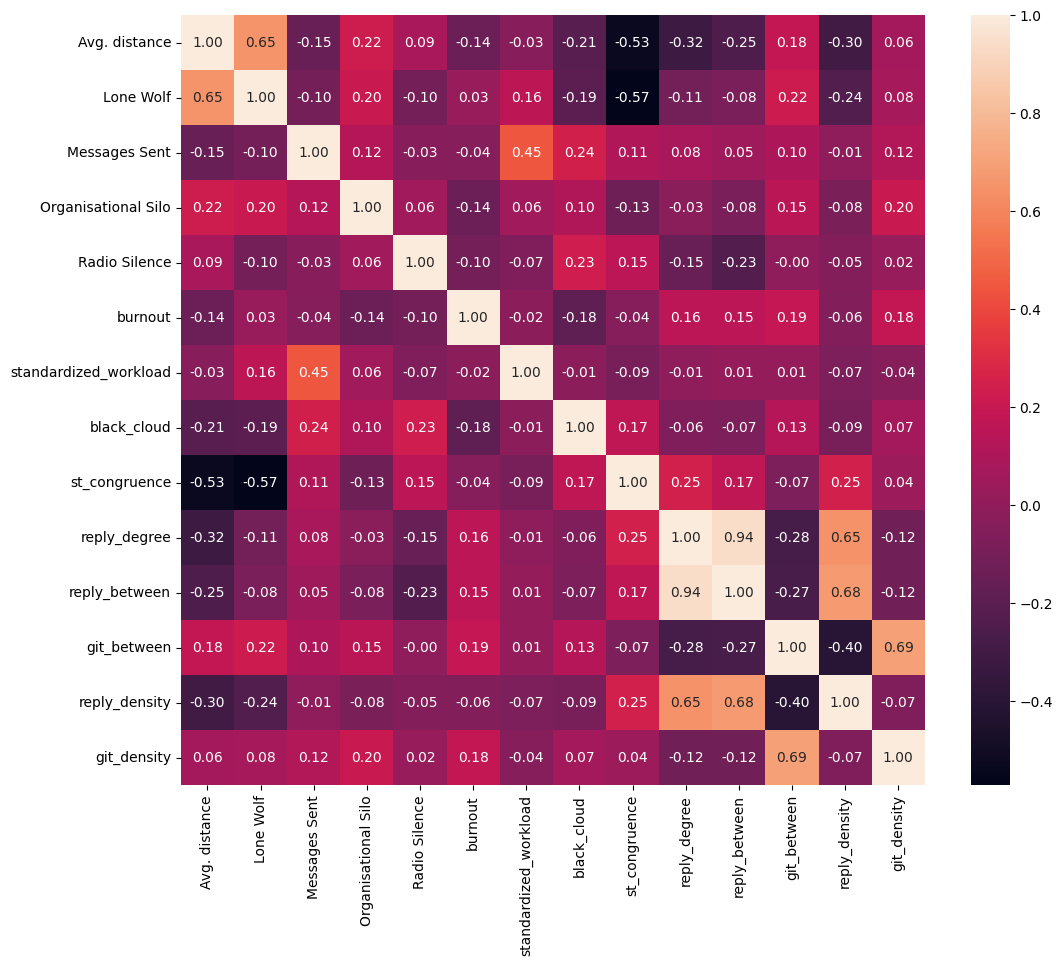

In [151]:
fig = plt.figure(figsize=(12,10))
ax= plt.subplot()
sns.heatmap(logistic_train_data.astype(float).corr(), annot=True, ax = ax, fmt = '.2f');
# fig.savefig('correlations_geronimo.png')

In [152]:
lr_model = LogisticRegressionCV(max_iter = 1000000).fit(logistic_train_data.drop('burnout', axis = 1), logistic_train_data['burnout'])

Text(45.722222222222214, 0.5, 'True class')

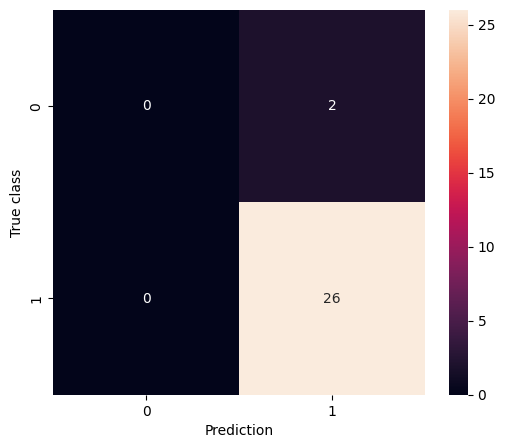

In [153]:
cm = confusion_matrix(logistic_test_data['burnout'], lr_model.predict(logistic_test_data.drop('burnout', axis = 1)))
fig = plt.figure(figsize=(6,5))
ax= plt.subplot()
sns.heatmap(cm, annot=True, ax = ax, fmt = 'g');
ax.set_xlabel('Prediction')
ax.set_ylabel('True class')

statsmodels

In [154]:
stat_model = sm.Logit(logistic_train_data['burnout'].astype(float), sm.add_constant(logistic_train_data[['Avg. distance', 'Lone Wolf', 'standardized_workload',
 'Organisational Silo', 'Radio Silence',  'black_cloud', 'Messages Sent', 'st_congruence', 'reply_between', 'git_between']]).astype(float)).fit(disp = 0)
stat_model.summary()

C:\Users\woute\OneDrive\Documenten\JADS\Thesis\venv_Thesis\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                burnout   No. Observations:                  112
Model:                          Logit   Df Residuals:                      101
Method:                           MLE   Df Model:                           10
Date:                Thu, 29 May 2025   Pseudo R-squ.:                  0.5082
Time:                        16:11:01   Log-Likelihood:                -12.877
converged:                      False   LL-Null:                       -26.185
Covariance Type:            nonrobust   LLR p-value:                  0.002996
=========================================================================================
                            coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                    21.9853   8243.813      0.003      0.998   -1.61e+04    1.62e+04
Avg. distance            -1.8341      0.943     -1.945      0.052      -3.682       0.014
Lone Wolf                 3.8714      3.253      1.190      0.234      -2.503      10.246
standardized_workload     0.0526      0.210      0.251      0.802      -0.358       0.463
Organisational Silo      -0.0180      1.836     -0.010      0.992      -3.617       3.581
Radio Silence           -17.0076   8243.812     -0.002      0.998   -1.62e+04    1.61e+04
black_cloud              -1.3557      1.448     -0.936      0.349      -4.193       1.482
Messages Sent            -0.0571      0.038     -1.504      0.132      -0.131       0.017
st_congruence            -3.8750      3.261     -1.188      0.235     -10.266       2.516
reply_between            35.2836     18.511      1.906      0.057      -0.997      71.564
git_between              24.5690     11.396      2.156      0.031       2.234      46.904
=========================================================================================

Possibly complete quasi-separation: A fraction 0.38 of observations can be
perfectly predicted. This might indicate that there is complete
quasi-separation. In this case some parameters will not be identified.
"""

Text(45.722222222222214, 0.5, 'True class')

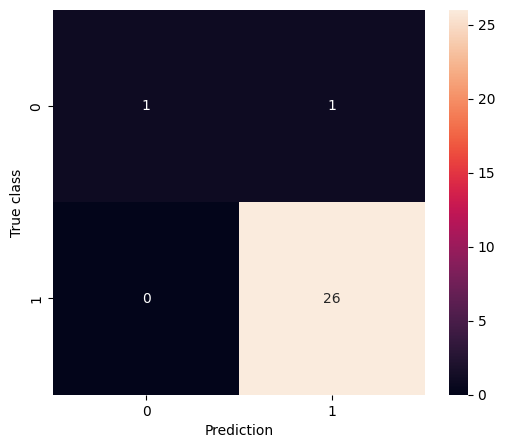

In [155]:
cm = confusion_matrix(logistic_test_data['burnout'], round(stat_model.predict(sm.add_constant(logistic_test_data[['Avg. distance', 'Lone Wolf', 'standardized_workload',
 'Organisational Silo', 'Radio Silence',  'black_cloud', 'Messages Sent', 'st_congruence', 'reply_between', 'git_between']]).astype(float))).astype(int))
fig = plt.figure(figsize=(6,5))
ax= plt.subplot()
sns.heatmap(cm, annot=True, ax = ax, fmt = 'g');
ax.set_xlabel('Prediction')
ax.set_ylabel('True class')

### Burnout NB

In [12]:
message_data = all_test[['reply_body', 'burnout']].dropna()

nlp = spacy.load('en_core_web_sm')
tqdm.pandas()

message_data['lemmas'] = message_data.reply_body.progress_apply(lambda x: [token.lemma_ for token in nlp(handle_negation(x)) if not token.is_stop and token.is_alpha])
message_data['burnout'] = message_data['burnout'].astype(bool)
message_data

100%|██████████| 269/269 [00:03<00:00, 68.44it/s]


,reply_body,burnout,lemmas
0,thanks ! i will look into the after,False,"[thanks, look]"
4,+1,False,[]
8,it seems makes protocol + buffered transport n...,True,"[make, protocol, buffer, transport, normal, rp..."
12,"why not instead to the file, i do not think we...",True,"[file, want, introduce, build, handle]"
13,"as , it is a workaround against resources by b...",True,"[workaround, resource]"
...,...,...,...
3914,@jeking3 where would the build encounter nodejs,False,"[build, encounter, nodejs]"
3918,from grunt-external-daemongrunt-shell to grunt to,False,"[grunt, external, daemongrunt, shell, grunt]"
3919,â¦ data types,False,"[datum, type]"
3922,removes the dependency on outdated npm test wa...,False,"[remove, dependency, outdated, npm, test, prev..."


In [13]:
message_data = message_data[message_data.apply(lambda x: len(x.lemmas), axis = 1) > 0]

message_train, message_test = train_test_split(message_data, test_size=0.15, random_state=404, stratify = message_data['burnout'])
message_train, message_val = train_test_split(message_train, test_size=(0.15/0.85), random_state=404, stratify = message_train['burnout'])

print(f'length of train set: {len(message_train)}\nlength of validation set: {len(message_val)}\nlength of test set: {len(message_test)}')
message_train = message_train[message_data.apply(lambda x: len(x.lemmas), axis = 1) > 3] # remove shorter messages

# Oversample on the True cases in the train set
if 2*message_train["burnout"].sum()<len(message_train):
   # True is the minority class
    if 3*message_train["burnout"].sum()<len(message_train):
        # We need to over- and undersample to create balance
        message_train = pd.concat([message_train.loc[message_train[message_train['burnout']==1].index], message_train])
        print(f'Positive cases: {message_train["burnout"].sum()}')

        if 3*message_train["burnout"].sum()<len(message_train):
            # Check for massive imbalance
            message_train = pd.concat([message_train.loc[message_train[message_train['burnout']==1].index], message_train])
            print(f'Positive cases: {message_train["burnout"].sum()}')

        nMax = message_train["burnout"].sum()
        message_train = message_train.groupby('burnout').apply(lambda x: x.sample(n=min(nMax, len(x)))).reset_index(drop = True).sample(frac=1)

        print(f'New length of train set: {len(message_train)}')
    else:
        nMax = message_train["burnout"].sum()
        # Only undersampling will do
        print(f'Positive cases: {message_train["burnout"].sum()}')
        message_train = message_train.groupby('burnout').apply(lambda x: x.sample(n=min(nMax, len(x)))).reset_index(drop = True).sample(frac=1)

        print(f'New length of train set: {len(message_train)}')


else:
    if message_train["burnout"].sum()>0.67*len(message_train):
        # False is the minority class and we need to over- and undersample
        message_train = pd.concat([message_train.loc[message_train[message_train['burnout']==0].index], message_train])
        print(f'Positive cases: {message_train["burnout"].sum()}')

        if message_train["burnout"].sum()>0.67*len(message_train):
            # Check for massive imbalance (mainly ragequit case)
            message_train = pd.concat([message_train.loc[message_train[message_train['burnout']==0].index], message_train])
            print(f'Positive cases: {message_train["burnout"].sum()}')

        nMax = len(message_train) - message_train["burnout"].sum()
        message_train = message_train.groupby('burnout').apply(lambda x: x.sample(n=min(nMax, len(x)))).reset_index(drop = True).sample(frac=1)

        print(f'New length of train set: {len(message_train)}')

    else:
        nMax = len(message_train) - message_train["burnout"].sum()
        print(f'Positive cases: {message_train["burnout"].sum()}')
        message_train = message_train.groupby('burnout').apply(lambda x: x.sample(n=min(nMax, len(x)))).reset_index(drop = True).sample(frac=1)

        print(f'New length of train set: {len(message_train)}')

length of train set: 181
length of validation set: 39
length of test set: 39
Positive cases: 50
New length of train set: 100


C:\Users\woute\AppData\Local\Temp\ipykernel_22328\1081622227.py:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  message_train = message_train[message_data.apply(lambda x: len(x.lemmas), axis = 1) > 3] # remove shorter messages
C:\Users\woute\AppData\Local\Temp\ipykernel_22328\1081622227.py:30: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  message_train = message_train.groupby('burnout').apply(lambda x: x.sample(n=min(nMax, len(x)))).reset_index(drop = True).sample(frac=1)


In [14]:
pos_labels, pos_values = zip(*Counter(itertools.chain(*message_data[message_data['burnout']].lemmas.tolist())).items())
neg_labels, neg_values = zip(*Counter(itertools.chain(*message_data[~message_data['burnout']].lemmas.tolist())).items())

importance_df = pd.DataFrame(index = list(set(pos_labels + neg_labels)), data = {'pos_occur': pd.Series(pos_values, index = pos_labels), 'neg_occur': pd.Series(neg_values, index = neg_labels)})
importance_df.fillna(0, inplace = True)
importance_df['total_appearances'] = importance_df['pos_occur'] + importance_df['neg_occur']

for i in range(0,125,25):
    p = i
    importance_df['pos_importance'] = (importance_df['pos_occur'] + p)/(importance_df['total_appearances']+2*p)
    importance_df['neg_importance'] = (importance_df['neg_occur'] + p)/(importance_df['total_appearances']+2*p)
    print(f'positive {i}:')
    print(importance_df[importance_df['total_appearances']>100].sort_values(by = 'pos_importance', ascending = False)[['pos_importance', 'pos_occur', 'total_appearances']].head(20))
    print(f'negative {i}:')
    print(importance_df[importance_df['total_appearances']>100].sort_values(by = 'neg_importance', ascending = False)[['neg_importance', 'neg_occur', 'total_appearances']].head(20))
    print('----------------------------------------------------------------------------------------------------------------------------------------------')

positive 0:
Empty DataFrame
Columns: [pos_importance, pos_occur, total_appearances]
Index: []
negative 0:
Empty DataFrame
Columns: [neg_importance, neg_occur, total_appearances]
Index: []
----------------------------------------------------------------------------------------------------------------------------------------------
positive 25:
Empty DataFrame
Columns: [pos_importance, pos_occur, total_appearances]
Index: []
negative 25:
Empty DataFrame
Columns: [neg_importance, neg_occur, total_appearances]
Index: []
----------------------------------------------------------------------------------------------------------------------------------------------
positive 50:
Empty DataFrame
Columns: [pos_importance, pos_occur, total_appearances]
Index: []
negative 50:
Empty DataFrame
Columns: [neg_importance, neg_occur, total_appearances]
Index: []
----------------------------------------------------------------------------------------------------------------------------------------------
pos

In [15]:
def identity_tokenizer(text):
    return text

tfidf = TfidfVectorizer(tokenizer=identity_tokenizer, lowercase=False, sublinear_tf = True, min_df = round(len(message_train)/1000)+1, max_df = 0.6)

train_tf = tfidf.fit_transform(message_train['lemmas'])
validate_tf = tfidf.transform(message_val['lemmas'])

vocab = tfidf.get_feature_names_out()

# Train Naive Bayes classifier


classifier = MultinomialNB()
classifier.fit(train_tf, message_train['burnout'])

classification_report(message_val['burnout'], classifier.predict(validate_tf))

C:\Users\woute\OneDrive\Documenten\JADS\Thesis\venv_Thesis\Lib\site-packages\sklearn\feature_extraction\text.py:517: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


'              precision    recall  f1-score   support\n\n       False       0.68      0.50      0.58        26\n        True       0.35      0.54      0.42        13\n\n    accuracy                           0.51        39\n   macro avg       0.52      0.52      0.50        39\nweighted avg       0.57      0.51      0.53        39\n'

Text(45.722222222222214, 0.5, 'True class')

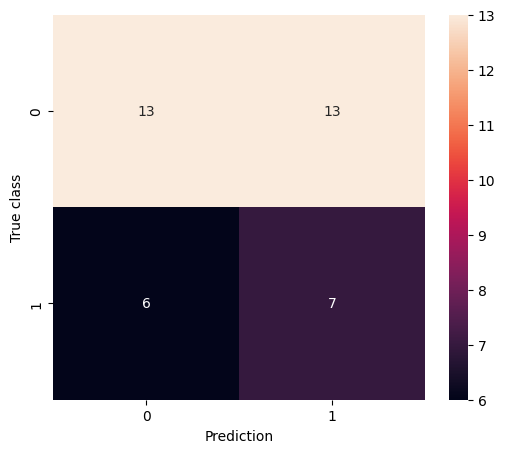

In [16]:
cm = confusion_matrix(message_val['burnout'], classifier.predict(validate_tf))
fig = plt.figure(figsize=(6,5))
ax= plt.subplot()
sns.heatmap(cm, annot=True, ax = ax, fmt = 'g');
ax.set_xlabel('Prediction')
ax.set_ylabel('True class')

In [17]:
def create_embedding(product_name, word_embeddings, vector_size = 300):
    embeddings = list()
    for token in product_name:
        if token in word_embeddings:
            embeddings.append(word_embeddings[token])
    if embeddings:
        return np.mean(embeddings, axis=0)
    else:
        return np.zeros(vector_size)

model = Word2Vec(sentences = message_data.lemmas.to_list(), vector_size = 300, min_count = 50, sg = 1)

message_train['doc_embeddings'] = message_train.lemmas.apply(lambda x: create_embedding(x, model.wv))

message_val['doc_embeddings'] = message_val.lemmas.apply(lambda x: create_embedding(x, model.wv))

classifier = GaussianNB()
classifier.fit(np.array(message_train['doc_embeddings'].tolist()), message_train['burnout'])

classification_report(message_val['burnout'], classifier.predict(np.array(message_val['doc_embeddings'].tolist()),))

'              precision    recall  f1-score   support\n\n       False       0.75      0.23      0.35        26\n        True       0.35      0.85      0.50        13\n\n    accuracy                           0.44        39\n   macro avg       0.55      0.54      0.43        39\nweighted avg       0.62      0.44      0.40        39\n'

Text(45.722222222222214, 0.5, 'True class')

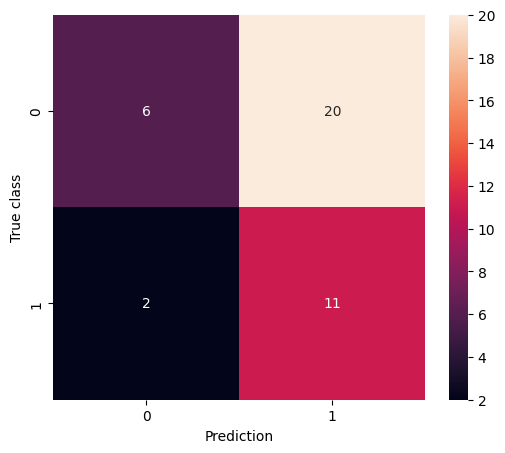

In [18]:
cm = confusion_matrix(message_val['burnout'], classifier.predict(np.array(message_val['doc_embeddings'].tolist()),))
fig = plt.figure(figsize=(6,5))
ax= plt.subplot()
sns.heatmap(cm, annot=True, ax = ax, fmt = 'g');
ax.set_xlabel('Prediction')
ax.set_ylabel('True class')

In [19]:
model = KeyedVectors.load_word2vec_format("SO_vectors_200.bin", binary=True)

message_train['doc_embeddings'] = message_train.lemmas.apply(lambda x: create_embedding(x, model, vector_size=200))

message_val['doc_embeddings'] = message_val.lemmas.apply(lambda x: create_embedding(x, model, vector_size=200))

classifier = GaussianNB()
classifier.fit(np.array(message_train['doc_embeddings'].tolist()), message_train['burnout'])

classification_report(message_val['burnout'], classifier.predict(np.array(message_val['doc_embeddings'].tolist()),))

'              precision    recall  f1-score   support\n\n       False       0.65      0.58      0.61        26\n        True       0.31      0.38      0.34        13\n\n    accuracy                           0.51        39\n   macro avg       0.48      0.48      0.48        39\nweighted avg       0.54      0.51      0.52        39\n'

Text(45.722222222222214, 0.5, 'True class')

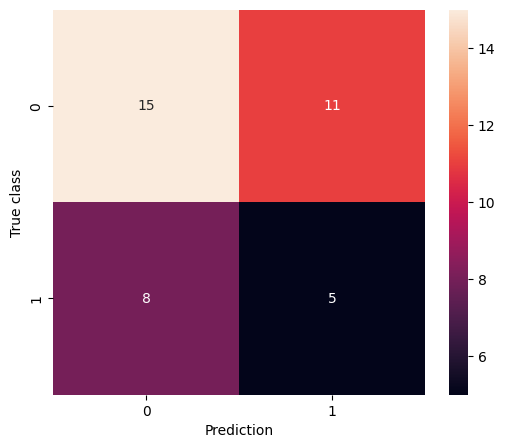

In [20]:
cm = confusion_matrix(message_val['burnout'], classifier.predict(np.array(message_val['doc_embeddings'].tolist()),))
fig = plt.figure(figsize=(6,5))
ax= plt.subplot()
sns.heatmap(cm, annot=True, ax = ax, fmt = 'g');
ax.set_xlabel('Prediction')
ax.set_ylabel('True class')

# RF models

In [21]:
def identity_tokenizer(text):
    return text

tfidf = TfidfVectorizer(tokenizer=identity_tokenizer, lowercase=False, sublinear_tf = True, min_df = round(len(message_train)/1000)+1, max_df = 0.6)

train_tf = tfidf.fit_transform(message_train['lemmas'])
validate_tf = tfidf.transform(message_val['lemmas'])

vocab = tfidf.get_feature_names_out()

# Train Naive Bayes classifier


classifier = RandomForestClassifier(n_estimators = 500, random_state = 404)
classifier.fit(train_tf, message_train['burnout'])

classification_report(message_val['burnout'], classifier.predict(validate_tf))

C:\Users\woute\OneDrive\Documenten\JADS\Thesis\venv_Thesis\Lib\site-packages\sklearn\feature_extraction\text.py:517: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


'              precision    recall  f1-score   support\n\n       False       0.68      0.58      0.62        26\n        True       0.35      0.46      0.40        13\n\n    accuracy                           0.54        39\n   macro avg       0.52      0.52      0.51        39\nweighted avg       0.57      0.54      0.55        39\n'

Text(45.722222222222214, 0.5, 'True class')

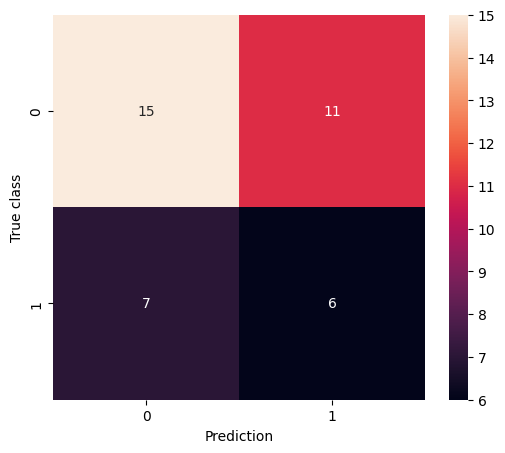

In [22]:
cm = confusion_matrix(message_val['burnout'], classifier.predict(validate_tf))
fig = plt.figure(figsize=(6,5))
ax= plt.subplot()
sns.heatmap(cm, annot=True, ax = ax, fmt = 'g');
ax.set_xlabel('Prediction')
ax.set_ylabel('True class')

In [23]:
def create_embedding(product_name, word_embeddings, vector_size = 300):
    embeddings = list()
    for token in product_name:
        if token in word_embeddings:
            embeddings.append(word_embeddings[token])
    if embeddings:
        return np.mean(embeddings, axis=0)
    else:
        return np.zeros(vector_size)

model = Word2Vec(sentences = message_data.lemmas.to_list(), vector_size = 300, min_count = 50, sg = 1)

message_train['doc_embeddings'] = message_train.lemmas.apply(lambda x: create_embedding(x, model.wv))

message_val['doc_embeddings'] = message_val.lemmas.apply(lambda x: create_embedding(x, model.wv))

classifier = RandomForestClassifier(n_estimators = 500, random_state = 404)
classifier.fit(np.array(message_train['doc_embeddings'].tolist()), message_train['burnout'])

classification_report(message_val['burnout'], classifier.predict(np.array(message_val['doc_embeddings'].tolist()),))

'              precision    recall  f1-score   support\n\n       False       0.69      0.85      0.76        26\n        True       0.43      0.23      0.30        13\n\n    accuracy                           0.64        39\n   macro avg       0.56      0.54      0.53        39\nweighted avg       0.60      0.64      0.61        39\n'

Text(45.722222222222214, 0.5, 'True class')

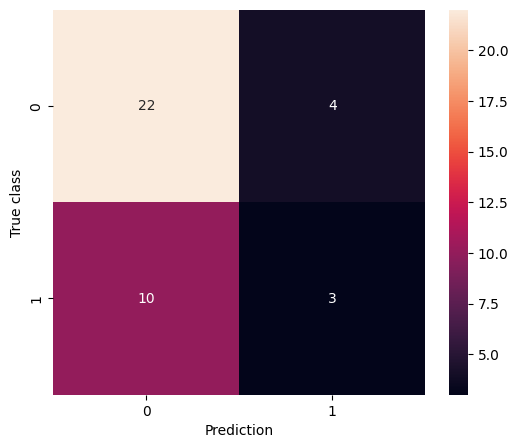

In [24]:
cm = confusion_matrix(message_val['burnout'], classifier.predict(np.array(message_val['doc_embeddings'].tolist()),))
fig = plt.figure(figsize=(6,5))
ax= plt.subplot()
sns.heatmap(cm, annot=True, ax = ax, fmt = 'g');
ax.set_xlabel('Prediction')
ax.set_ylabel('True class')

In [25]:
model = KeyedVectors.load_word2vec_format("SO_vectors_200.bin", binary=True)

message_train['doc_embeddings'] = message_train.lemmas.apply(lambda x: create_embedding(x, model, vector_size=200))

message_val['doc_embeddings'] = message_val.lemmas.apply(lambda x: create_embedding(x, model, vector_size=200))

classifier = RandomForestClassifier(n_estimators = 500, random_state = 404)
classifier.fit(np.array(message_train['doc_embeddings'].tolist()), message_train['burnout'])

classification_report(message_val['burnout'], classifier.predict(np.array(message_val['doc_embeddings'].tolist()),))

'              precision    recall  f1-score   support\n\n       False       0.70      0.62      0.65        26\n        True       0.38      0.46      0.41        13\n\n    accuracy                           0.56        39\n   macro avg       0.54      0.54      0.53        39\nweighted avg       0.59      0.56      0.57        39\n'

Text(45.722222222222214, 0.5, 'True class')

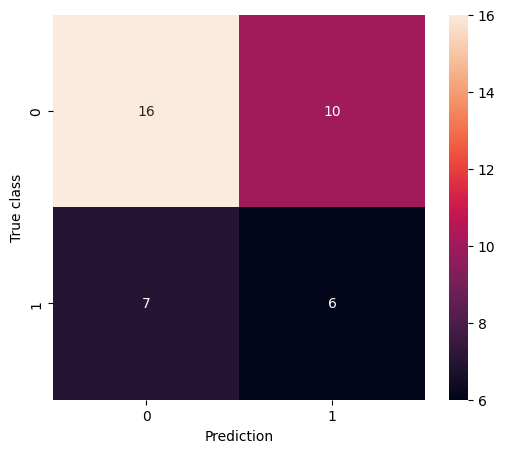

In [26]:
cm = confusion_matrix(message_val['burnout'], classifier.predict(np.array(message_val['doc_embeddings'].tolist()),))
fig = plt.figure(figsize=(6,5))
ax= plt.subplot()
sns.heatmap(cm, annot=True, ax = ax, fmt = 'g');
ax.set_xlabel('Prediction')
ax.set_ylabel('True class')

# Ragequit - LR

sklearn

In [27]:
burnout_logistic_data = logistic_data[~logistic_data['ragequit_t+1'].isna()].drop(['burnout_t+1', 'burnout_t+3', 'burnout_t+12', 'burnout', 'ragequit_t+3', 'ragequit_t+12', 'git_close'], axis = 1).drop_duplicates().drop(['Alias', 'From', 'To', 'start_datetime', 'end_datetime', 'lagged_burnout', 'reply_close', 'working_months', 'quit', 'first_quit_month', 'git_degree', 'Workload'], axis = 1).dropna().astype({'ragequit_t+1':bool})
logistic_train_data, logistic_test_data = train_test_split(burnout_logistic_data, test_size = 0.2, random_state = 404, stratify = burnout_logistic_data[['ragequit_t+1', 'Lone Wolf']])


In [28]:
burnout_logistic_data.describe(include = 'all')

,Avg. distance,Lone Wolf,Messages Sent,Organisational Silo,Radio Silence,standardized_workload,black_cloud,ragequit_t+1,st_congruence,reply_degree,reply_between,git_between,reply_density,git_density
count,140.000000,140,140.000000,140,140,140.000000,140,140,140.000000,140.000000,140.000000,140.000000,140.000000,140.000000
unique,NaN,2,NaN,2,2,NaN,2,2,NaN,NaN,NaN,NaN,NaN,NaN
top,NaN,True,NaN,False,True,NaN,False,False,NaN,NaN,NaN,NaN,NaN,NaN
freq,NaN,107,NaN,119,120,NaN,104,131,NaN,NaN,NaN,NaN,NaN,NaN
mean,2.866111,NaN,18.164286,NaN,NaN,1.749195,NaN,NaN,0.337880,0.269215,0.128843,0.130741,0.029376,0.088081
std,1.638060,NaN,32.396734,NaN,NaN,3.468955,NaN,NaN,0.272713,0.140275,0.111687,0.131858,0.014830,0.044010
min,1.000000,NaN,1.000000,NaN,NaN,0.000954,NaN,NaN,0.000000,0.050528,0.002338,0.000000,0.008296,0.022222
25%,1.383333,NaN,3.000000,NaN,NaN,0.044834,NaN,NaN,0.142857,0.151020,0.036012,0.000000,0.018893,0.058480
50%,2.500000,NaN,7.000000,NaN,NaN,0.252288,NaN,NaN,0.333333,0.227837,0.089962,0.127163,0.027692,0.076923
75%,4.000000,NaN,19.000000,NaN,NaN,1.781790,NaN,NaN,0.500000,0.348837,0.185314,0.169643,0.034146,0.108135


In [29]:
lr_model = LogisticRegressionCV(max_iter = 1000000).fit(logistic_train_data.drop('ragequit_t+1', axis = 1), logistic_train_data['ragequit_t+1'])

Text(45.722222222222214, 0.5, 'True class')

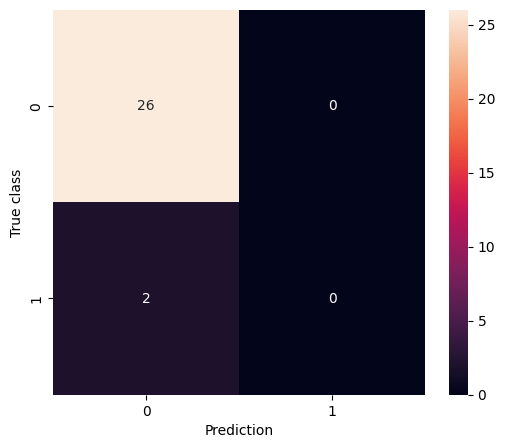

In [30]:
cm = confusion_matrix(logistic_test_data['ragequit_t+1'], lr_model.predict(logistic_test_data.drop('ragequit_t+1', axis = 1)))
fig = plt.figure(figsize=(6,5))
ax= plt.subplot()
sns.heatmap(cm, annot=True, ax = ax, fmt = 'g');
ax.set_xlabel('Prediction')
ax.set_ylabel('True class')

statsmodels

In [31]:
stat_model = sm.Logit(logistic_train_data['ragequit_t+1'].astype(float), sm.add_constant(logistic_train_data[['Avg. distance', 'Lone Wolf', 'standardized_workload',
 'Organisational Silo', 'Radio Silence',  'black_cloud', 'Messages Sent', 'st_congruence', 'reply_between', 'git_between']]).astype(float)).fit(disp = 0)
stat_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:           ragequit_t+1   No. Observations:                  112
Model:                          Logit   Df Residuals:                      101
Method:                           MLE   Df Model:                           10
Date:                Thu, 29 May 2025   Pseudo R-squ.:                  0.1702
Time:                        15:02:25   Log-Likelihood:                -21.729
converged:                       True   LL-Null:                       -26.185
Covariance Type:            nonrobust   LLR p-value:                    0.5406
=========================================================================================
                            coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                    -0.9085      2.152     -0.422      0.673      -5.126       3.309
Avg. distance            -0.2645      0.362     -0.730      0.466      -0.975       0.446
Lone Wolf                 0.7401      1.672      0.443      0.658      -2.537       4.017
standardized_workload    -1.1421      1.171     -0.975      0.329      -3.438       1.153
Organisational Silo       0.5788      1.290      0.449      0.654      -1.950       3.108
Radio Silence             0.4083      1.244      0.328      0.743      -2.030       2.847
black_cloud              -0.3257      1.323     -0.246      0.806      -2.919       2.268
Messages Sent            -0.0305      0.060     -0.512      0.608      -0.147       0.086
st_congruence            -1.6101      2.119     -0.760      0.447      -5.763       2.543
reply_between            -1.0483      4.333     -0.242      0.809      -9.541       7.444
git_between              -5.3682      5.076     -1.058      0.290     -15.317       4.580
=========================================================================================

Possibly complete quasi-separation: A fraction 0.13 of observations can be
perfectly predicted. This might indicate that there is complete
quasi-separation. In this case some parameters will not be identified.
"""

Text(45.722222222222214, 0.5, 'True class')

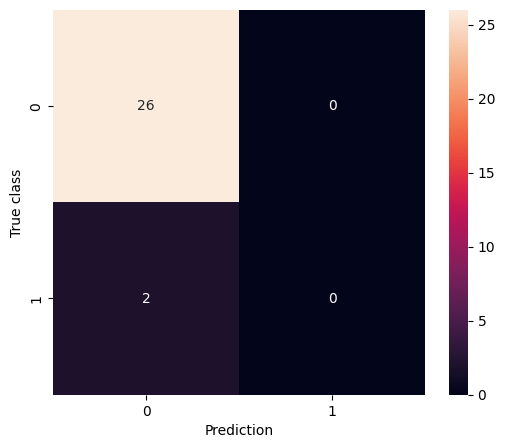

In [32]:
cm = confusion_matrix(logistic_test_data['ragequit_t+1'], round(stat_model.predict(sm.add_constant(logistic_test_data[['Avg. distance', 'Lone Wolf', 'standardized_workload',
 'Organisational Silo', 'Radio Silence',  'black_cloud', 'Messages Sent', 'st_congruence', 'reply_between', 'git_between']]).astype(float))).astype(int))
fig = plt.figure(figsize=(6,5))
ax= plt.subplot()
sns.heatmap(cm, annot=True, ax = ax, fmt = 'g');
ax.set_xlabel('Prediction')
ax.set_ylabel('True class')

### Burnout NB

In [33]:
message_data = all_test[['reply_body', 'ragequit_t+1']].dropna()

nlp = spacy.load('en_core_web_sm')
tqdm.pandas()

message_data['lemmas'] = message_data.reply_body.progress_apply(lambda x: [token.lemma_ for token in nlp(handle_negation(x)) if not token.is_stop and token.is_alpha])
message_data['ragequit_t+1'] = message_data['ragequit_t+1'].astype(bool)
message_data

100%|██████████| 3646/3646 [00:52<00:00, 69.21it/s] 


,reply_body,ragequit_t+1,lemmas
0,thanks ! i will look into the after,False,"[thanks, look]"
1,"@jens-g yeah, that is what is happening is rec...",False,"[g, yeah, happen, recently, add, cross, limite..."
2,stumbled upon a todo:,False,"[stumble, todo]"
3,it is essentially caused by method that is not...,False,"[essentially, cause, method]"
4,+1,False,[]
...,...,...,...
4290,changes are backwards compatible never did,False,"[change, backwards, compatible]"
4291,"this seems an obvious problem, do not know why...",False,"[obvious, problem, maybe, wrong, build, compil..."
4292,"this seems an obvious problem, do not know why...",False,"[obvious, problem, maybe, wrong, build, compil..."
4294,some helpful tipsa successfulthrift pr: * did ...,False,"[helpful, tipsa, successfulthrift, pr, test, c..."


In [34]:
message_data = message_data[message_data.apply(lambda x: len(x.lemmas), axis = 1) > 0]

message_train, message_test = train_test_split(message_data, test_size=0.15, random_state=404, stratify = message_data['ragequit_t+1'])
message_train, message_val = train_test_split(message_train, test_size=(0.15/0.85), random_state=404, stratify = message_train['ragequit_t+1'])

print(f'length of train set: {len(message_train)}\nlength of validation set: {len(message_val)}\nlength of test set: {len(message_test)}')
message_train = message_train[message_data.apply(lambda x: len(x.lemmas), axis = 1) > 3] # remove shorter messages

# Oversample on the True cases in the train set
if 2*message_train["ragequit_t+1"].sum()<len(message_train):
   # True is the minority class
    if 3*message_train["ragequit_t+1"].sum()<len(message_train):
        # We need to over- and undersample to create balance
        message_train = pd.concat([message_train.loc[message_train[message_train["ragequit_t+1"]==1].index], message_train])
        print(f'Positive cases: {message_train["ragequit_t+1"].sum()}')

        if 3*message_train["ragequit_t+1"].sum()<len(message_train):
            # Check for massive imbalance
            message_train = pd.concat([message_train.loc[message_train[message_train["ragequit_t+1"]==1].index], message_train])
            print(f'Positive cases: {message_train["ragequit_t+1"].sum()}')

        nMax = message_train["ragequit_t+1"].sum()
        message_train = message_train.groupby("ragequit_t+1").apply(lambda x: x.sample(n=min(nMax, len(x)))).reset_index(drop = True).sample(frac=1)

        print(f'New length of train set: {len(message_train)}')
    else:
        nMax = message_train["ragequit_t+1"].sum()
        # Only undersampling will do
        print(f'Positive cases: {message_train["ragequit_t+1"].sum()}')
        message_train = message_train.groupby("ragequit_t+1").apply(lambda x: x.sample(n=min(nMax, len(x)))).reset_index(drop = True).sample(frac=1)

        print(f'New length of train set: {len(message_train)}')


else:
    if message_train["ragequit_t+1"].sum()>0.67*len(message_train):
        # False is the minority class and we need to over- and undersample
        message_train = pd.concat([message_train.loc[message_train[message_train["ragequit_t+1"]==0].index], message_train])
        print(f'Positive cases: {message_train["ragequit_t+1"].sum()}')

        if message_train["ragequit_t+1"].sum()>0.67*len(message_train):
            # Check for massive imbalance (mainly ragequit case)
            message_train = pd.concat([message_train.loc[message_train[message_train["ragequit_t+1"]==0].index], message_train])
            print(f'Positive cases: {message_train["ragequit_t+1"].sum()}')

        nMax = len(message_train) - message_train["ragequit_t+1"].sum()
        message_train = message_train.groupby("ragequit_t+1").apply(lambda x: x.sample(n=min(nMax, len(x)))).reset_index(drop = True).sample(frac=1)

        print(f'New length of train set: {len(message_train)}')

    else:
        nMax = len(message_train) - message_train["ragequit_t+1"].sum()
        print(f'Positive cases: {message_train["ragequit_t+1"].sum()}')
        message_train = message_train.groupby("ragequit_t+1").apply(lambda x: x.sample(n=min(nMax, len(x)))).reset_index(drop = True).sample(frac=1)

        print(f'New length of train set: {len(message_train)}')

length of train set: 2483
length of validation set: 533
length of test set: 533
Positive cases: 106
Positive cases: 318
New length of train set: 636


C:\Users\woute\AppData\Local\Temp\ipykernel_22328\1360335003.py:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  message_train = message_train[message_data.apply(lambda x: len(x.lemmas), axis = 1) > 3] # remove shorter messages
C:\Users\woute\AppData\Local\Temp\ipykernel_22328\1360335003.py:23: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  message_train = message_train.groupby("ragequit_t+1").apply(lambda x: x.sample(n=min(nMax, len(x)))).reset_index(drop = True).sample(frac=1)


In [35]:
pos_labels, pos_values = zip(*Counter(itertools.chain(*message_data[message_data['ragequit_t+1']].lemmas.tolist())).items())
neg_labels, neg_values = zip(*Counter(itertools.chain(*message_data[~message_data['ragequit_t+1']].lemmas.tolist())).items())

importance_df = pd.DataFrame(index = list(set(pos_labels + neg_labels)), data = {'pos_occur': pd.Series(pos_values, index = pos_labels), 'neg_occur': pd.Series(neg_values, index = neg_labels)})
importance_df.fillna(0, inplace = True)
importance_df['total_appearances'] = importance_df['pos_occur'] + importance_df['neg_occur']

for i in range(0,125,25):
    p = i
    importance_df['pos_importance'] = (importance_df['pos_occur'] + p)/(importance_df['total_appearances']+2*p)
    importance_df['neg_importance'] = (importance_df['neg_occur'] + p)/(importance_df['total_appearances']+2*p)
    print(f'positive {i}:')
    print(importance_df[importance_df['total_appearances']>100].sort_values(by = 'pos_importance', ascending = False)[['pos_importance', 'pos_occur', 'total_appearances']].head(20))
    print(f'negative {i}:')
    print(importance_df[importance_df['total_appearances']>100].sort_values(by = 'neg_importance', ascending = False)[['neg_importance', 'neg_occur', 'total_appearances']].head(20))
    print('----------------------------------------------------------------------------------------------------------------------------------------------')

positive 0:
            pos_importance  pos_occur  total_appearances
dependency        0.461538       54.0              117.0
resolve           0.400000       50.0              125.0
exception         0.337662       52.0              154.0
server            0.165289       60.0              363.0
client            0.153846       66.0              429.0
failure           0.142105       27.0              190.0
directory         0.122807       14.0              114.0
version           0.109155       31.0              284.0
test              0.104208      104.0              998.0
check             0.098214       22.0              224.0
instead           0.093220       11.0              118.0
job               0.074713       13.0              174.0
type              0.060870       14.0              230.0
protocol          0.059524       10.0              168.0
work              0.058366       15.0              257.0
bit               0.057143        6.0              105.0
line              0

In [36]:
def identity_tokenizer(text):
    return text

tfidf = TfidfVectorizer(tokenizer=identity_tokenizer, lowercase=False, sublinear_tf = True, min_df = round(len(message_train)/1000), max_df = 0.6)

train_tf = tfidf.fit_transform(message_train['lemmas'])
validate_tf = tfidf.transform(message_val['lemmas'])

vocab = tfidf.get_feature_names_out()

# Train Naive Bayes classifier


classifier = MultinomialNB()
classifier.fit(train_tf, message_train['ragequit_t+1'])

classification_report(message_val['ragequit_t+1'], classifier.predict(validate_tf))

C:\Users\woute\OneDrive\Documenten\JADS\Thesis\venv_Thesis\Lib\site-packages\sklearn\feature_extraction\text.py:517: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


'              precision    recall  f1-score   support\n\n       False       0.98      0.85      0.91       517\n        True       0.08      0.44      0.14        16\n\n    accuracy                           0.84       533\n   macro avg       0.53      0.65      0.53       533\nweighted avg       0.95      0.84      0.89       533\n'

Text(45.722222222222214, 0.5, 'True class')

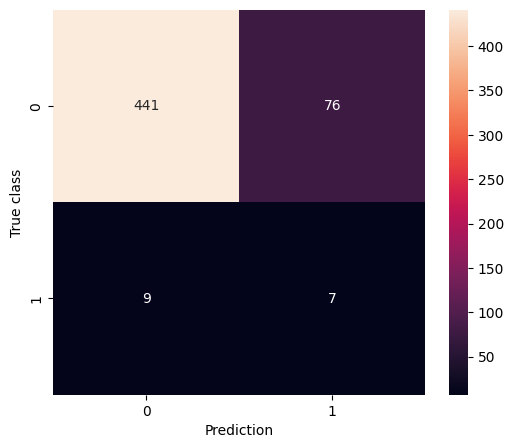

In [37]:
cm = confusion_matrix(message_val['ragequit_t+1'], classifier.predict(validate_tf))
fig = plt.figure(figsize=(6,5))
ax= plt.subplot()
sns.heatmap(cm, annot=True, ax = ax, fmt = 'g');
ax.set_xlabel('Prediction')
ax.set_ylabel('True class')

In [38]:
def create_embedding(product_name, word_embeddings, vector_size = 300):
    embeddings = list()
    for token in product_name:
        if token in word_embeddings:
            embeddings.append(word_embeddings[token])
    if embeddings:
        return np.mean(embeddings, axis=0)
    else:
        return np.zeros(vector_size)

model = Word2Vec(sentences = message_train.lemmas.to_list(), vector_size = 300, min_count = 50, sg = 1)

message_train['doc_embeddings'] = message_train.lemmas.apply(lambda x: create_embedding(x, model.wv))

message_val['doc_embeddings'] = message_val.lemmas.apply(lambda x: create_embedding(x, model.wv))

classifier = GaussianNB()
classifier.fit(np.array(message_train['doc_embeddings'].tolist()), message_train['ragequit_t+1'])

classification_report(message_val['ragequit_t+1'], classifier.predict(np.array(message_val['doc_embeddings'].tolist()),))

'              precision    recall  f1-score   support\n\n       False       0.97      0.75      0.84       517\n        True       0.03      0.25      0.05        16\n\n    accuracy                           0.73       533\n   macro avg       0.50      0.50      0.45       533\nweighted avg       0.94      0.73      0.82       533\n'

Text(45.722222222222214, 0.5, 'True class')

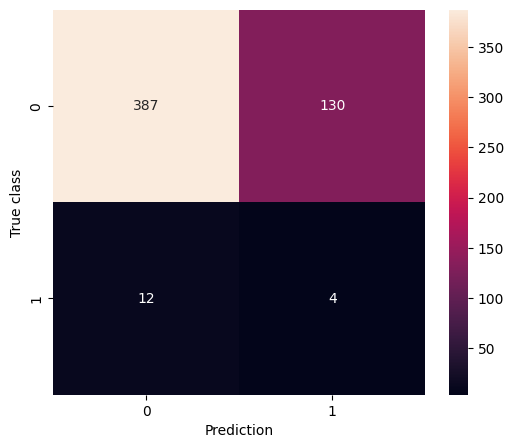

In [39]:
cm = confusion_matrix(message_val['ragequit_t+1'], classifier.predict(np.array(message_val['doc_embeddings'].tolist()),))
fig = plt.figure(figsize=(6,5))
ax= plt.subplot()
sns.heatmap(cm, annot=True, ax = ax, fmt = 'g');
ax.set_xlabel('Prediction')
ax.set_ylabel('True class')

In [40]:
model = KeyedVectors.load_word2vec_format("SO_vectors_200.bin", binary=True)

message_train['doc_embeddings'] = message_train.lemmas.apply(lambda x: create_embedding(x, model, vector_size=200))

message_val['doc_embeddings'] = message_val.lemmas.apply(lambda x: create_embedding(x, model, vector_size=200))

classifier = GaussianNB()
classifier.fit(np.array(message_train['doc_embeddings'].tolist()), message_train['ragequit_t+1'])

classification_report(message_val['ragequit_t+1'], classifier.predict(np.array(message_val['doc_embeddings'].tolist()),))

'              precision    recall  f1-score   support\n\n       False       0.97      0.78      0.87       517\n        True       0.03      0.19      0.05        16\n\n    accuracy                           0.77       533\n   macro avg       0.50      0.49      0.46       533\nweighted avg       0.94      0.77      0.84       533\n'

Text(45.722222222222214, 0.5, 'True class')

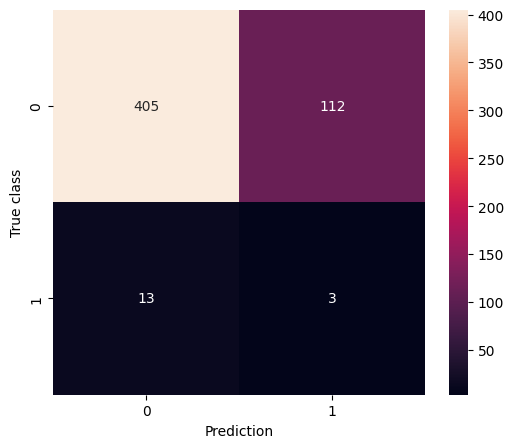

In [41]:
cm = confusion_matrix(message_val['ragequit_t+1'], classifier.predict(np.array(message_val['doc_embeddings'].tolist()),))
fig = plt.figure(figsize=(6,5))
ax= plt.subplot()
sns.heatmap(cm, annot=True, ax = ax, fmt = 'g');
ax.set_xlabel('Prediction')
ax.set_ylabel('True class')

# RF models

In [42]:
def identity_tokenizer(text):
    return text

tfidf = TfidfVectorizer(tokenizer=identity_tokenizer, lowercase=False, sublinear_tf = True, min_df = round(len(message_train)/1000), max_df = 0.6)

train_tf = tfidf.fit_transform(message_train['lemmas'])
validate_tf = tfidf.transform(message_val['lemmas'])

vocab = tfidf.get_feature_names_out()

# Train Naive Bayes classifier


classifier = RandomForestClassifier(n_estimators = 500, random_state = 404)
classifier.fit(train_tf, message_train['ragequit_t+1'])

classification_report(message_val['ragequit_t+1'], classifier.predict(validate_tf))

C:\Users\woute\OneDrive\Documenten\JADS\Thesis\venv_Thesis\Lib\site-packages\sklearn\feature_extraction\text.py:517: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


'              precision    recall  f1-score   support\n\n       False       0.97      0.99      0.98       517\n        True       0.40      0.12      0.19        16\n\n    accuracy                           0.97       533\n   macro avg       0.69      0.56      0.59       533\nweighted avg       0.96      0.97      0.96       533\n'

Text(45.722222222222214, 0.5, 'True class')

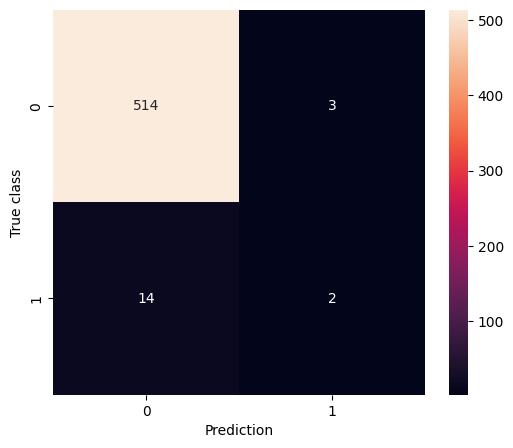

In [43]:
cm = confusion_matrix(message_val['ragequit_t+1'], classifier.predict(validate_tf))
fig = plt.figure(figsize=(6,5))
ax= plt.subplot()
sns.heatmap(cm, annot=True, ax = ax, fmt = 'g');
ax.set_xlabel('Prediction')
ax.set_ylabel('True class')

In [44]:
def create_embedding(product_name, word_embeddings, vector_size = 300):
    embeddings = list()
    for token in product_name:
        if token in word_embeddings:
            embeddings.append(word_embeddings[token])
    if embeddings:
        return np.mean(embeddings, axis=0)
    else:
        return np.zeros(vector_size)

model = Word2Vec(sentences = message_train.lemmas.to_list(), vector_size = 300, min_count = 50, sg = 1)

message_train['doc_embeddings'] = message_train.lemmas.apply(lambda x: create_embedding(x, model.wv))

message_val['doc_embeddings'] = message_val.lemmas.apply(lambda x: create_embedding(x, model.wv))

classifier = RandomForestClassifier(n_estimators = 500, random_state = 404)
classifier.fit(np.array(message_train['doc_embeddings'].tolist()), message_train['ragequit_t+1'])

classification_report(message_val['ragequit_t+1'], classifier.predict(np.array(message_val['doc_embeddings'].tolist()),))

'              precision    recall  f1-score   support\n\n       False       0.97      0.68      0.80       517\n        True       0.04      0.44      0.07        16\n\n    accuracy                           0.67       533\n   macro avg       0.51      0.56      0.44       533\nweighted avg       0.95      0.67      0.78       533\n'

Text(45.722222222222214, 0.5, 'True class')

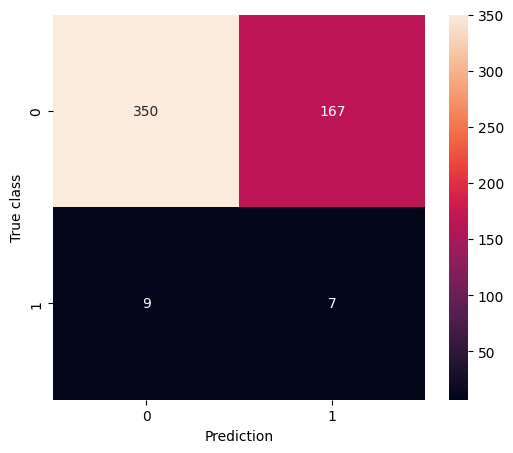

In [45]:
cm = confusion_matrix(message_val['ragequit_t+1'], classifier.predict(np.array(message_val['doc_embeddings'].tolist()),))
fig = plt.figure(figsize=(6,5))
ax= plt.subplot()
sns.heatmap(cm, annot=True, ax = ax, fmt = 'g');
ax.set_xlabel('Prediction')
ax.set_ylabel('True class')

In [46]:
model = KeyedVectors.load_word2vec_format("SO_vectors_200.bin", binary=True)

message_train['doc_embeddings'] = message_train.lemmas.apply(lambda x: create_embedding(x, model, vector_size=200))

message_val['doc_embeddings'] = message_val.lemmas.apply(lambda x: create_embedding(x, model, vector_size=200))

classifier = RandomForestClassifier(n_estimators = 500, random_state = 404)
classifier.fit(np.array(message_train['doc_embeddings'].tolist()), message_train['ragequit_t+1'])

classification_report(message_val['ragequit_t+1'], classifier.predict(np.array(message_val['doc_embeddings'].tolist()),))

'              precision    recall  f1-score   support\n\n       False       0.97      1.00      0.99       517\n        True       1.00      0.06      0.12        16\n\n    accuracy                           0.97       533\n   macro avg       0.99      0.53      0.55       533\nweighted avg       0.97      0.97      0.96       533\n'

Text(45.722222222222214, 0.5, 'True class')

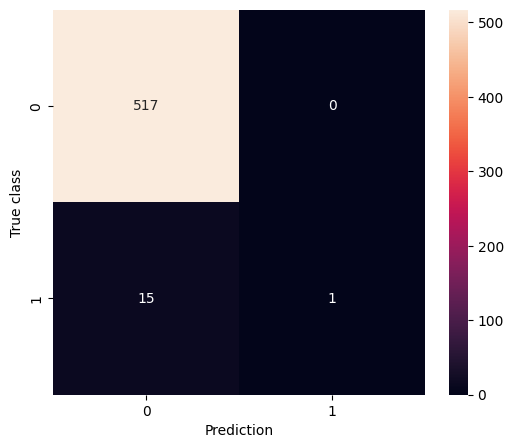

In [47]:
cm = confusion_matrix(message_val['ragequit_t+1'], classifier.predict(np.array(message_val['doc_embeddings'].tolist()),))
fig = plt.figure(figsize=(6,5))
ax= plt.subplot()
sns.heatmap(cm, annot=True, ax = ax, fmt = 'g');
ax.set_xlabel('Prediction')
ax.set_ylabel('True class')

# Lagged variables

## Burnout t+1

In [156]:
burnout_logistic_data = logistic_data[~logistic_data['burnout_t+1'].isna()].drop(['burnout', 'burnout_t+3', 'burnout_t+12', 'ragequit_t+1', 'ragequit_t+3', 'ragequit_t+12', 'git_close'], axis = 1).drop_duplicates().drop(['Alias', 'From', 'To', 'start_datetime', 'end_datetime', 'lagged_burnout', 'reply_close', 'working_months', 'quit', 'first_quit_month', 'git_degree', 'Workload'], axis = 1).dropna().astype({'burnout_t+1':bool})
logistic_train_data, logistic_test_data = train_test_split(burnout_logistic_data, test_size = 0.2, random_state = 404, stratify = burnout_logistic_data['burnout_t+1'])


In [162]:
logistic_data[~logistic_data.burnout.isna()].drop(['burnout', 'burnout_t+3', 'burnout_t+12', 'ragequit_t+1', 'ragequit_t+3', 'ragequit_t+12', 'git_close'], axis = 1).drop_duplicates().drop(['Alias', 'From', 'To', 'start_datetime', 'end_datetime', 'lagged_burnout', 'reply_close', 'working_months', 'quit', 'first_quit_month', 'git_degree', 'Workload'], axis = 1)

,Avg. distance,Lone Wolf,Messages Sent,Organisational Silo,Radio Silence,standardized_workload,burnout_t+1,black_cloud,st_congruence,reply_degree,reply_between,git_between,reply_density,git_density
0,NaN,False,2.0,False,True,0.012388,NaN,False,0.714286,0.515854,0.285833,0.101010,0.034146,0.089744
1,NaN,False,2.0,False,True,0.013564,NaN,False,1.000000,0.046032,0.001633,0.000000,0.011111,0.000000
2,NaN,False,0.0,False,False,0.008259,NaN,False,0.100000,0.131579,0.030879,0.128540,0.011278,0.058480
3,NaN,False,4.0,False,True,0.073856,NaN,False,0.000000,0.172222,0.034836,0.000000,0.032323,0.027778
4,2.333333,True,2.0,True,True,3.151197,NaN,False,0.250000,0.348837,0.126246,0.055556,0.023256,0.088889
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
370,3.000000,True,2.0,False,True,0.003406,NaN,False,0.000000,0.141649,0.019831,0.000000,0.021142,0.030303
371,NaN,False,4.0,False,True,0.008038,NaN,False,0.000000,0.274704,0.075659,0.000000,0.043478,0.047619
372,NaN,False,0.0,False,False,0.012193,NaN,False,0.142857,0.139001,0.036404,0.352679,0.018893,0.194444
373,NaN,False,2.0,False,True,0.053681,NaN,False,0.100000,0.131579,0.030879,0.128540,0.011278,0.058480


In [157]:
lr_model = LogisticRegressionCV(max_iter = 1000000).fit(logistic_train_data.drop('burnout_t+1', axis = 1), logistic_train_data['burnout_t+1'])

Text(45.722222222222214, 0.5, 'True class')

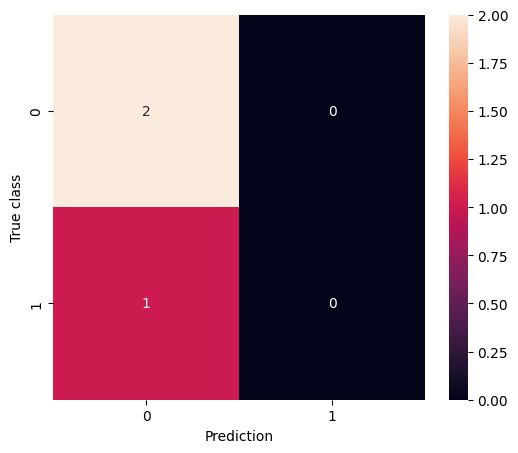

In [158]:
cm = confusion_matrix(logistic_test_data['burnout_t+1'], lr_model.predict(logistic_test_data.drop('burnout_t+1', axis = 1)))
fig = plt.figure(figsize=(6,5))
ax= plt.subplot()
sns.heatmap(cm, annot=True, ax = ax, fmt = 'g');
ax.set_xlabel('Prediction')
ax.set_ylabel('True class')

statsmodels

In [159]:
stat_model = sm.Logit(logistic_train_data['burnout_t+1'].astype(float), sm.add_constant(logistic_train_data[['Avg. distance', 'Lone Wolf', 'standardized_workload',
 'Organisational Silo', 'Radio Silence',  'black_cloud', 'Messages Sent', 'st_congruence', 'reply_between', 'git_between']]).astype(float)).fit(disp = 0)
stat_model.summary()

C:\Users\woute\OneDrive\Documenten\JADS\Thesis\venv_Thesis\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:            burnout_t+1   No. Observations:                   11
Model:                          Logit   Df Residuals:                        1
Method:                           MLE   Df Model:                            9
Date:                Thu, 29 May 2025   Pseudo R-squ.:                  0.9999
Time:                        16:11:33   Log-Likelihood:            -0.00061204
converged:                      False   LL-Null:                       -7.5791
Covariance Type:            nonrobust   LLR p-value:                   0.08671
=========================================================================================
                            coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                    31.8029        nan        nan        nan         nan         nan
Avg. distance            -6.5566        nan        nan        nan         nan         nan
Lone Wolf               156.1326   4.44e+05      0.000      1.000    -8.7e+05     8.7e+05
standardized_workload   -17.3763   1.81e+04     -0.001      0.999   -3.56e+04    3.55e+04
Organisational Silo    -182.8052   5.02e+05     -0.000      1.000   -9.83e+05    9.83e+05
Radio Silence            31.8030        nan        nan        nan         nan         nan
black_cloud             -33.5122   5.94e+05  -5.64e-05      1.000   -1.17e+06    1.17e+06
Messages Sent            -1.8228   9055.713     -0.000      1.000   -1.78e+04    1.77e+04
st_congruence           -29.2439   1.56e+06  -1.88e-05      1.000   -3.05e+06    3.05e+06
reply_between           569.4665        nan        nan        nan         nan         nan
git_between            -172.3312         -0        inf      0.000    -172.331    -172.331
=========================================================================================

Possibly complete quasi-separation: A fraction 0.82 of observations can be
perfectly predicted. This might indicate that there is complete
quasi-separation. In this case some parameters will not be identified.
"""

Text(45.722222222222214, 0.5, 'True class')

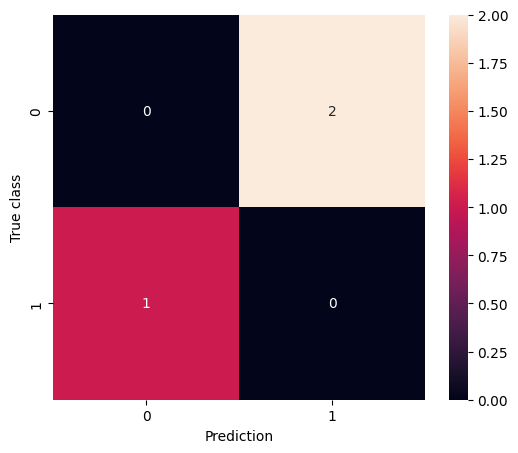

In [160]:
cm = confusion_matrix(logistic_test_data['burnout_t+1'], round(stat_model.predict(sm.add_constant(logistic_test_data[['Avg. distance', 'Lone Wolf', 'standardized_workload',
 'Organisational Silo', 'Radio Silence',  'black_cloud', 'Messages Sent', 'st_congruence', 'reply_between', 'git_between']]).astype(float))).astype(int))
fig = plt.figure(figsize=(6,5))
ax= plt.subplot()
sns.heatmap(cm, annot=True, ax = ax, fmt = 'g');
ax.set_xlabel('Prediction')
ax.set_ylabel('True class')

### Burnout NB

In [53]:
message_data = all_test[['reply_body', 'burnout_t+1']].dropna()

nlp = spacy.load('en_core_web_sm')
tqdm.pandas()

message_data['lemmas'] = message_data.reply_body.progress_apply(lambda x: [token.lemma_ for token in nlp(handle_negation(x)) if not token.is_stop and token.is_alpha])
message_data['burnout_t+1'] = message_data['burnout_t+1'].astype(bool)
message_data

100%|██████████| 393/393 [00:05<00:00, 76.59it/s] 


,reply_body,burnout_t+1,lemmas
0,thanks ! i will look into the after,True,"[thanks, look]"
4,+1,True,[]
8,it seems makes protocol + buffered transport n...,True,"[make, protocol, buffer, transport, normal, rp..."
12,"why not instead to the file, i do not think we...",True,"[file, want, introduce, build, handle]"
13,"as , it is a workaround against resources by b...",True,"[workaround, resource]"
...,...,...,...
3914,@jeking3 where would the build encounter nodejs,False,"[build, encounter, nodejs]"
3918,from grunt-external-daemongrunt-shell to grunt to,False,"[grunt, external, daemongrunt, shell, grunt]"
3919,â¦ data types,False,"[datum, type]"
3922,removes the dependency on outdated npm test wa...,False,"[remove, dependency, outdated, npm, test, prev..."


In [54]:
message_data = message_data[message_data.apply(lambda x: len(x.lemmas), axis = 1) > 0]

message_train, message_test = train_test_split(message_data, test_size=0.15, random_state=404, stratify = message_data['burnout_t+1'])
message_train, message_val = train_test_split(message_train, test_size=(0.15/0.85), random_state=404, stratify = message_train['burnout_t+1'])

print(f'length of train set: {len(message_train)}\nlength of validation set: {len(message_val)}\nlength of test set: {len(message_test)}')
message_train = message_train[message_data.apply(lambda x: len(x.lemmas), axis = 1) > 3] # remove shorter messages

# Oversample on the True cases in the train set
if 2*message_train["burnout_t+1"].sum()<len(message_train):
   # True is the minority class
    if 3*message_train["burnout_t+1"].sum()<len(message_train):
        # We need to over- and undersample to create balance
        message_train = pd.concat([message_train.loc[message_train[message_train['burnout_t+1']==1].index], message_train])
        print(f'Positive cases: {message_train["burnout_t+1"].sum()}')

        if 3*message_train["burnout_t+1"].sum()<len(message_train):
            # Check for massive imbalance
            message_train = pd.concat([message_train.loc[message_train[message_train["burnout_t+1"]==1].index], message_train])
            print(f'Positive cases: {message_train["burnout_t+1"].sum()}')

        nMax = message_train["burnout_t+1"].sum()
        message_train = message_train.groupby("burnout_t+1").apply(lambda x: x.sample(n=min(nMax, len(x)))).reset_index(drop = True).sample(frac=1)

        print(f'New length of train set: {len(message_train)}')
    else:
        nMax = message_train["burnout_t+1"].sum()
        # Only undersampling will do
        print(f'Positive cases: {message_train["burnout_t+1"].sum()}')
        message_train = message_train.groupby("burnout_t+1").apply(lambda x: x.sample(n=min(nMax, len(x)))).reset_index(drop = True).sample(frac=1)

        print(f'New length of train set: {len(message_train)}')


else:
    if message_train["burnout_t+1"].sum()>0.67*len(message_train):
        # False is the minority class and we need to over- and undersample
        message_train = pd.concat([message_train.loc[message_train[message_train["burnout_t+1"]==0].index], message_train])
        print(f'Positive cases: {message_train["burnout_t+1"].sum()}')

        if message_train["burnout_t+1"].sum()>0.67*len(message_train):
            # Check for massive imbalance (mainly ragequit case)
            message_train = pd.concat([message_train.loc[message_train[message_train["burnout_t+1"]==0].index], message_train])
            print(f'Positive cases: {message_train["burnout_t+1"].sum()}')

        nMax = len(message_train) - message_train["burnout_t+1"].sum()
        message_train = message_train.groupby("burnout_t+1").apply(lambda x: x.sample(n=min(nMax, len(x)))).reset_index(drop = True).sample(frac=1)

        print(f'New length of train set: {len(message_train)}')

    else:
        nMax = len(message_train) - message_train["burnout_t+1"].sum()
        print(f'Positive cases: {message_train["burnout_t+1"].sum()}')
        message_train = message_train.groupby("burnout_t+1").apply(lambda x: x.sample(n=min(nMax, len(x)))).reset_index(drop = True).sample(frac=1)

        print(f'New length of train set: {len(message_train)}')

length of train set: 266
length of validation set: 58
length of test set: 58
Positive cases: 112
New length of train set: 180


C:\Users\woute\AppData\Local\Temp\ipykernel_22328\995443566.py:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  message_train = message_train[message_data.apply(lambda x: len(x.lemmas), axis = 1) > 3] # remove shorter messages
C:\Users\woute\AppData\Local\Temp\ipykernel_22328\995443566.py:54: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  message_train = message_train.groupby("burnout_t+1").apply(lambda x: x.sample(n=min(nMax, len(x)))).reset_index(drop = True).sample(frac=1)


In [55]:
pos_labels, pos_values = zip(*Counter(itertools.chain(*message_data[message_data['burnout_t+1']].lemmas.tolist())).items())
neg_labels, neg_values = zip(*Counter(itertools.chain(*message_data[~message_data['burnout_t+1']].lemmas.tolist())).items())

importance_df = pd.DataFrame(index = list(set(pos_labels + neg_labels)), data = {'pos_occur': pd.Series(pos_values, index = pos_labels), 'neg_occur': pd.Series(neg_values, index = neg_labels)})
importance_df.fillna(0, inplace = True)
importance_df['total_appearances'] = importance_df['pos_occur'] + importance_df['neg_occur']

for i in range(0,125,25):
    p = i
    importance_df['pos_importance'] = (importance_df['pos_occur'] + p)/(importance_df['total_appearances']+2*p)
    importance_df['neg_importance'] = (importance_df['neg_occur'] + p)/(importance_df['total_appearances']+2*p)
    print(f'positive {i}:')
    print(importance_df[importance_df['total_appearances']>100].sort_values(by = 'pos_importance', ascending = False)[['pos_importance', 'pos_occur', 'total_appearances']].head(20))
    print(f'negative {i}:')
    print(importance_df[importance_df['total_appearances']>100].sort_values(by = 'neg_importance', ascending = False)[['neg_importance', 'neg_occur', 'total_appearances']].head(20))
    print('----------------------------------------------------------------------------------------------------------------------------------------------')

positive 0:
Empty DataFrame
Columns: [pos_importance, pos_occur, total_appearances]
Index: []
negative 0:
Empty DataFrame
Columns: [neg_importance, neg_occur, total_appearances]
Index: []
----------------------------------------------------------------------------------------------------------------------------------------------
positive 25:
Empty DataFrame
Columns: [pos_importance, pos_occur, total_appearances]
Index: []
negative 25:
Empty DataFrame
Columns: [neg_importance, neg_occur, total_appearances]
Index: []
----------------------------------------------------------------------------------------------------------------------------------------------
positive 50:
Empty DataFrame
Columns: [pos_importance, pos_occur, total_appearances]
Index: []
negative 50:
Empty DataFrame
Columns: [neg_importance, neg_occur, total_appearances]
Index: []
----------------------------------------------------------------------------------------------------------------------------------------------
pos

In [57]:
def identity_tokenizer(text):
    return text

tfidf = TfidfVectorizer(tokenizer=identity_tokenizer, lowercase=False, sublinear_tf = True, min_df = round(len(message_train)/1000)+1, max_df = 0.6)

train_tf = tfidf.fit_transform(message_train['lemmas'])
validate_tf = tfidf.transform(message_val['lemmas'])

vocab = tfidf.get_feature_names_out()

# Train Naive Bayes classifier


classifier = MultinomialNB()
classifier.fit(train_tf, message_train['burnout_t+1'])

classification_report(message_val['burnout_t+1'], classifier.predict(validate_tf))

C:\Users\woute\OneDrive\Documenten\JADS\Thesis\venv_Thesis\Lib\site-packages\sklearn\feature_extraction\text.py:517: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


'              precision    recall  f1-score   support\n\n       False       0.59      0.57      0.58        28\n        True       0.61      0.63      0.62        30\n\n    accuracy                           0.60        58\n   macro avg       0.60      0.60      0.60        58\nweighted avg       0.60      0.60      0.60        58\n'

Text(45.722222222222214, 0.5, 'True class')

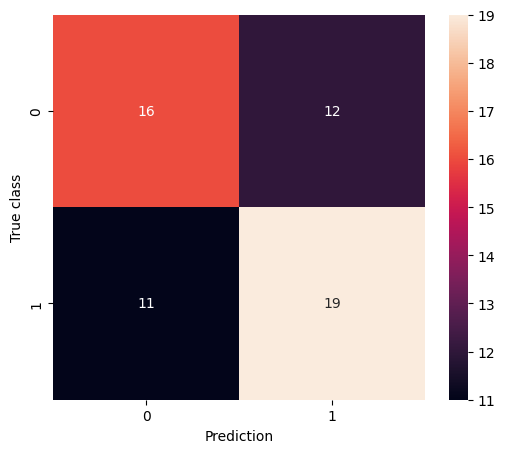

In [58]:
cm = confusion_matrix(message_val['burnout_t+1'], classifier.predict(validate_tf))
fig = plt.figure(figsize=(6,5))
ax= plt.subplot()
sns.heatmap(cm, annot=True, ax = ax, fmt = 'g');
ax.set_xlabel('Prediction')
ax.set_ylabel('True class')

In [59]:
def create_embedding(product_name, word_embeddings, vector_size = 300):
    embeddings = list()
    for token in product_name:
        if token in word_embeddings:
            embeddings.append(word_embeddings[token])
    if embeddings:
        return np.mean(embeddings, axis=0)
    else:
        return np.zeros(vector_size)

model = Word2Vec(sentences = message_data.lemmas.to_list(), vector_size = 300, min_count = 50, sg = 1)

message_train['doc_embeddings'] = message_train.lemmas.apply(lambda x: create_embedding(x, model.wv))

message_val['doc_embeddings'] = message_val.lemmas.apply(lambda x: create_embedding(x, model.wv))

classifier = GaussianNB()
classifier.fit(np.array(message_train['doc_embeddings'].tolist()), message_train['burnout_t+1'])

classification_report(message_val['burnout_t+1'], classifier.predict(np.array(message_val['doc_embeddings'].tolist()),))

'              precision    recall  f1-score   support\n\n       False       0.62      0.46      0.53        28\n        True       0.59      0.73      0.66        30\n\n    accuracy                           0.60        58\n   macro avg       0.61      0.60      0.59        58\nweighted avg       0.61      0.60      0.60        58\n'

Text(45.722222222222214, 0.5, 'True class')

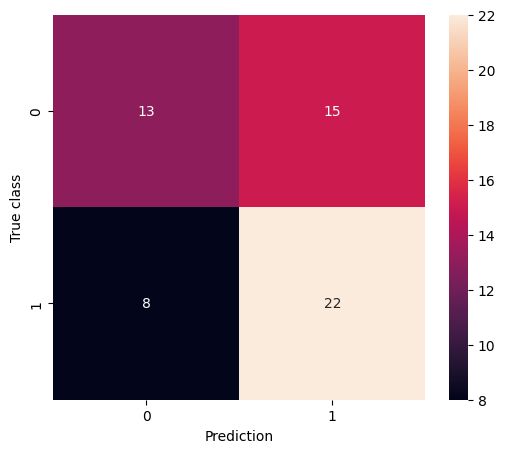

In [60]:
cm = confusion_matrix(message_val['burnout_t+1'], classifier.predict(np.array(message_val['doc_embeddings'].tolist()),))
fig = plt.figure(figsize=(6,5))
ax= plt.subplot()
sns.heatmap(cm, annot=True, ax = ax, fmt = 'g');
ax.set_xlabel('Prediction')
ax.set_ylabel('True class')

In [61]:
model = KeyedVectors.load_word2vec_format("SO_vectors_200.bin", binary=True)

message_train['doc_embeddings'] = message_train.lemmas.apply(lambda x: create_embedding(x, model, vector_size=200))

message_val['doc_embeddings'] = message_val.lemmas.apply(lambda x: create_embedding(x, model, vector_size=200))

classifier = GaussianNB()
classifier.fit(np.array(message_train['doc_embeddings'].tolist()), message_train['burnout_t+1'])

classification_report(message_val['burnout_t+1'], classifier.predict(np.array(message_val['doc_embeddings'].tolist()),))

'              precision    recall  f1-score   support\n\n       False       0.65      0.46      0.54        28\n        True       0.61      0.77      0.68        30\n\n    accuracy                           0.62        58\n   macro avg       0.63      0.62      0.61        58\nweighted avg       0.63      0.62      0.61        58\n'

Text(45.722222222222214, 0.5, 'True class')

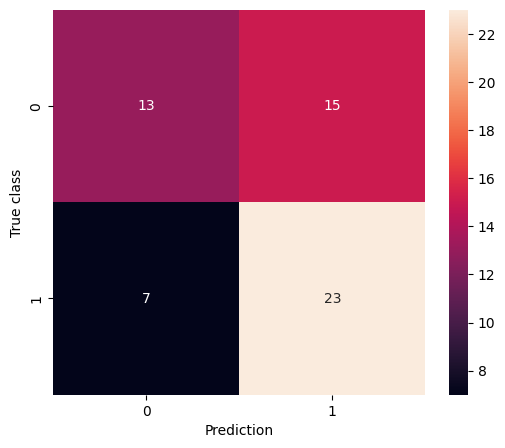

In [62]:
cm = confusion_matrix(message_val['burnout_t+1'], classifier.predict(np.array(message_val['doc_embeddings'].tolist()),))
fig = plt.figure(figsize=(6,5))
ax= plt.subplot()
sns.heatmap(cm, annot=True, ax = ax, fmt = 'g');
ax.set_xlabel('Prediction')
ax.set_ylabel('True class')

# RF models

In [63]:
def identity_tokenizer(text):
    return text

tfidf = TfidfVectorizer(tokenizer=identity_tokenizer, lowercase=False, sublinear_tf = True, min_df = round(len(message_train)/1000)+1, max_df = 0.6)

train_tf = tfidf.fit_transform(message_train['lemmas'])
validate_tf = tfidf.transform(message_val['lemmas'])

vocab = tfidf.get_feature_names_out()

# Train Naive Bayes classifier


classifier = RandomForestClassifier(n_estimators = 500, random_state = 404)
classifier.fit(train_tf, message_train['burnout_t+1'])

classification_report(message_val['burnout_t+1'], classifier.predict(validate_tf))

C:\Users\woute\OneDrive\Documenten\JADS\Thesis\venv_Thesis\Lib\site-packages\sklearn\feature_extraction\text.py:517: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


'              precision    recall  f1-score   support\n\n       False       0.67      0.57      0.62        28\n        True       0.65      0.73      0.69        30\n\n    accuracy                           0.66        58\n   macro avg       0.66      0.65      0.65        58\nweighted avg       0.66      0.66      0.65        58\n'

Text(45.722222222222214, 0.5, 'True class')

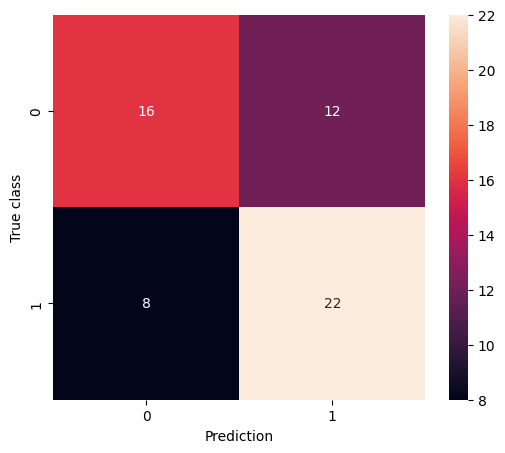

In [64]:
cm = confusion_matrix(message_val['burnout_t+1'], classifier.predict(validate_tf))
fig = plt.figure(figsize=(6,5))
ax= plt.subplot()
sns.heatmap(cm, annot=True, ax = ax, fmt = 'g');
ax.set_xlabel('Prediction')
ax.set_ylabel('True class')

In [65]:
def create_embedding(product_name, word_embeddings, vector_size = 300):
    embeddings = list()
    for token in product_name:
        if token in word_embeddings:
            embeddings.append(word_embeddings[token])
    if embeddings:
        return np.mean(embeddings, axis=0)
    else:
        return np.zeros(vector_size)

model = Word2Vec(sentences = message_data.lemmas.to_list(), vector_size = 300, min_count = 50, sg = 1)

message_train['doc_embeddings'] = message_train.lemmas.apply(lambda x: create_embedding(x, model.wv))

message_val['doc_embeddings'] = message_val.lemmas.apply(lambda x: create_embedding(x, model.wv))

classifier = RandomForestClassifier(n_estimators = 500, random_state = 404)
classifier.fit(np.array(message_train['doc_embeddings'].tolist()), message_train['burnout_t+1'])

classification_report(message_val['burnout_t+1'], classifier.predict(np.array(message_val['doc_embeddings'].tolist()),))

'              precision    recall  f1-score   support\n\n       False       0.67      0.36      0.47        28\n        True       0.58      0.83      0.68        30\n\n    accuracy                           0.60        58\n   macro avg       0.62      0.60      0.58        58\nweighted avg       0.62      0.60      0.58        58\n'

Text(45.722222222222214, 0.5, 'True class')

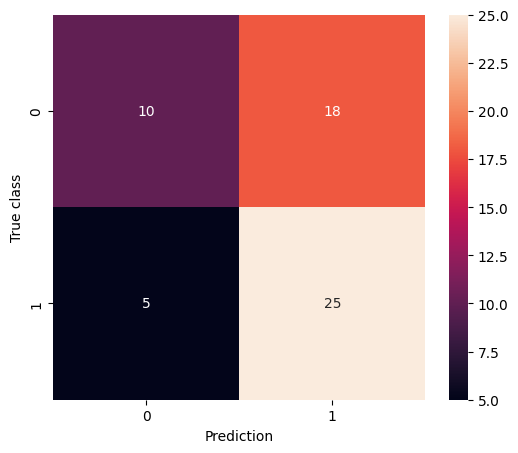

In [66]:
cm = confusion_matrix(message_val['burnout_t+1'], classifier.predict(np.array(message_val['doc_embeddings'].tolist()),))
fig = plt.figure(figsize=(6,5))
ax= plt.subplot()
sns.heatmap(cm, annot=True, ax = ax, fmt = 'g');
ax.set_xlabel('Prediction')
ax.set_ylabel('True class')

In [67]:
model = KeyedVectors.load_word2vec_format("SO_vectors_200.bin", binary=True)

message_train['doc_embeddings'] = message_train.lemmas.apply(lambda x: create_embedding(x, model, vector_size=200))

message_val['doc_embeddings'] = message_val.lemmas.apply(lambda x: create_embedding(x, model, vector_size=200))

classifier = RandomForestClassifier(n_estimators = 500, random_state = 404)
classifier.fit(np.array(message_train['doc_embeddings'].tolist()), message_train['burnout_t+1'])

classification_report(message_val['burnout_t+1'], classifier.predict(np.array(message_val['doc_embeddings'].tolist()),))

'              precision    recall  f1-score   support\n\n       False       0.65      0.54      0.59        28\n        True       0.63      0.73      0.68        30\n\n    accuracy                           0.64        58\n   macro avg       0.64      0.63      0.63        58\nweighted avg       0.64      0.64      0.63        58\n'

Text(45.722222222222214, 0.5, 'True class')

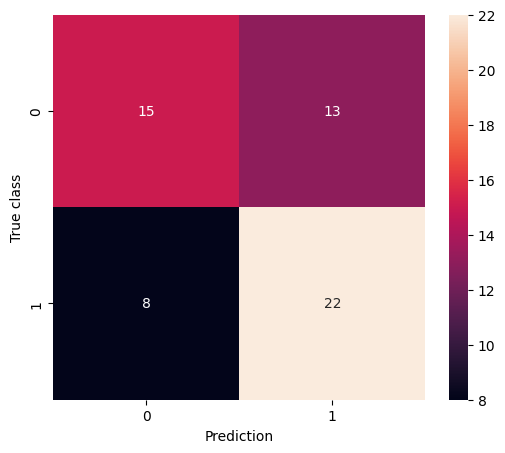

In [68]:
cm = confusion_matrix(message_val['burnout_t+1'], classifier.predict(np.array(message_val['doc_embeddings'].tolist()),))
fig = plt.figure(figsize=(6,5))
ax= plt.subplot()
sns.heatmap(cm, annot=True, ax = ax, fmt = 'g');
ax.set_xlabel('Prediction')
ax.set_ylabel('True class')

## Burnout_t+3

In [69]:
burnout_logistic_data = logistic_data[~logistic_data.burnout.isna()].drop(['burnout_t+1', 'burnout', 'burnout_t+12', 'ragequit_t+1', 'ragequit_t+3', 'ragequit_t+12', 'git_close'], axis = 1).drop_duplicates().drop(['Alias', 'From', 'To', 'start_datetime', 'end_datetime', 'lagged_burnout', 'reply_close', 'working_months', 'quit', 'first_quit_month', 'git_degree', 'Workload'], axis = 1).dropna().astype({'burnout_t+3':bool})
logistic_train_data, logistic_test_data = train_test_split(burnout_logistic_data, test_size = 0.2, random_state = 404, stratify = burnout_logistic_data['burnout_t+3'])

In [70]:
lr_model = LogisticRegressionCV(max_iter = 1000000).fit(logistic_train_data.drop('burnout_t+3', axis = 1), logistic_train_data['burnout_t+3'])

Text(45.722222222222214, 0.5, 'True class')

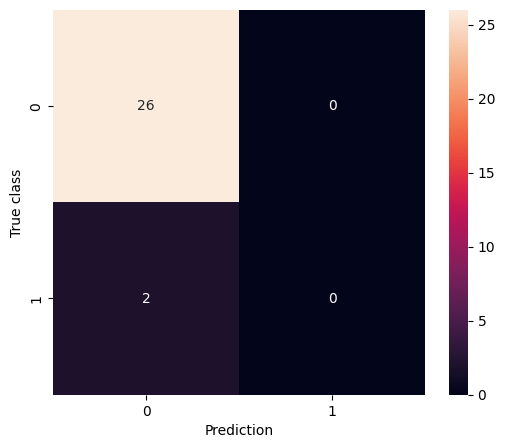

In [71]:
cm = confusion_matrix(logistic_test_data['burnout_t+3'], lr_model.predict(logistic_test_data.drop('burnout_t+3', axis = 1)))
fig = plt.figure(figsize=(6,5))
ax= plt.subplot()
sns.heatmap(cm, annot=True, ax = ax, fmt = 'g');
ax.set_xlabel('Prediction')
ax.set_ylabel('True class')

statsmodels

In [72]:
stat_model = sm.Logit(logistic_train_data['burnout_t+3'].astype(float), sm.add_constant(logistic_train_data.drop('burnout_t+3', axis = 1)).astype(float)).fit(disp = 0)
stat_model.summary()

C:\Users\woute\OneDrive\Documenten\JADS\Thesis\venv_Thesis\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:            burnout_t+3   No. Observations:                  112
Model:                          Logit   Df Residuals:                       98
Method:                           MLE   Df Model:                           13
Date:                Thu, 29 May 2025   Pseudo R-squ.:                  0.6034
Time:                        15:05:57   Log-Likelihood:                -13.363
converged:                      False   LL-Null:                       -33.699
Covariance Type:            nonrobust   LLR p-value:                 0.0001077
=========================================================================================
                            coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                   -16.4129   4.42e+04     -0.000      1.000   -8.67e+04    8.66e+04
Avg. distance            -0.2719      0.772     -0.352      0.725      -1.785       1.241
Lone Wolf                -1.4700      2.139     -0.687      0.492      -5.662       2.722
Messages Sent             0.0494      0.030      1.632      0.103      -0.010       0.109
Organisational Silo       0.4369      2.477      0.176      0.860      -4.418       5.292
Radio Silence            18.1219   4.42e+04      0.000      1.000   -8.66e+04    8.67e+04
standardized_workload     0.2337      0.186      1.255      0.210      -0.131       0.599
black_cloud               2.8968      1.614      1.795      0.073      -0.267       6.060
st_congruence             0.6757      3.332      0.203      0.839      -5.855       7.206
reply_degree            -38.0444     37.545     -1.013      0.311    -111.631      35.542
reply_between            -1.6183     34.783     -0.047      0.963     -69.793      66.556
git_between              31.1822     15.340      2.033      0.042       1.117      61.248
reply_density           200.4365    141.635      1.415      0.157     -77.162     478.035
git_density            -102.2582     52.980     -1.930      0.054    -206.096       1.580
=========================================================================================

Possibly complete quasi-separation: A fraction 0.40 of observations can be
perfectly predicted. This might indicate that there is complete
quasi-separation. In this case some parameters will not be identified.
"""

Text(45.722222222222214, 0.5, 'True class')

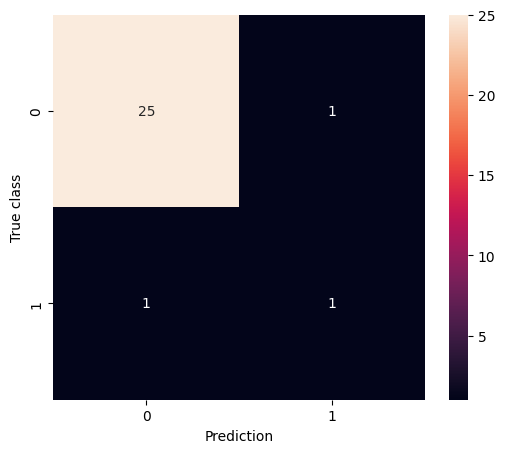

In [73]:
cm = confusion_matrix(logistic_test_data['burnout_t+3'], round(stat_model.predict(sm.add_constant(logistic_test_data.drop('burnout_t+3', axis = 1)).astype(float))).astype(int))
fig = plt.figure(figsize=(6,5))
ax= plt.subplot()
sns.heatmap(cm, annot=True, ax = ax, fmt = 'g');
ax.set_xlabel('Prediction')
ax.set_ylabel('True class')

### Burnout NB

In [74]:
message_data = all_test[['reply_body', 'burnout_t+3']].dropna()

nlp = spacy.load('en_core_web_sm')
tqdm.pandas()

message_data['lemmas'] = message_data.reply_body.progress_apply(lambda x: [token.lemma_ for token in nlp(handle_negation(x)) if not token.is_stop and token.is_alpha])
message_data['burnout_t+3'] = message_data['burnout_t+3'].astype(bool)
message_data

100%|██████████| 3646/3646 [00:41<00:00, 87.68it/s] 


,reply_body,burnout_t+3,lemmas
0,thanks ! i will look into the after,True,"[thanks, look]"
1,"@jens-g yeah, that is what is happening is rec...",True,"[g, yeah, happen, recently, add, cross, limite..."
2,stumbled upon a todo:,True,"[stumble, todo]"
3,it is essentially caused by method that is not...,True,"[essentially, cause, method]"
4,+1,True,[]
...,...,...,...
4290,changes are backwards compatible never did,False,"[change, backwards, compatible]"
4291,"this seems an obvious problem, do not know why...",False,"[obvious, problem, maybe, wrong, build, compil..."
4292,"this seems an obvious problem, do not know why...",False,"[obvious, problem, maybe, wrong, build, compil..."
4294,some helpful tipsa successfulthrift pr: * did ...,False,"[helpful, tipsa, successfulthrift, pr, test, c..."


In [75]:
message_data = message_data[message_data.apply(lambda x: len(x.lemmas), axis = 1) > 0]

message_train, message_test = train_test_split(message_data, test_size=0.15, random_state=404, stratify = message_data['burnout_t+3'])
message_train, message_val = train_test_split(message_train, test_size=(0.15/0.85), random_state=404, stratify = message_train['burnout_t+3'])

print(f'length of train set: {len(message_train)}\nlength of validation set: {len(message_val)}\nlength of test set: {len(message_test)}')
message_train = message_train[message_data.apply(lambda x: len(x.lemmas), axis = 1) > 3] # remove shorter messages

# Oversample on the True cases in the train set
if 2*message_train["burnout_t+3"].sum()<len(message_train):
   # True is the minority class
    if 3*message_train["burnout_t+3"].sum()<len(message_train):
        # We need to over- and undersample to create balance
        message_train = pd.concat([message_train.loc[message_train[message_train["burnout_t+3"]==1].index], message_train])
        print(f'Positive cases: {message_train["burnout_t+3"].sum()}')

        if 3*message_train["burnout_t+3"].sum()<len(message_train):
            # Check for massive imbalance
            message_train = pd.concat([message_train.loc[message_train[message_train["burnout_t+3"]==1].index], message_train])
            print(f'Positive cases: {message_train["burnout_t+3"].sum()}')

        nMax = message_train["burnout_t+3"].sum()
        message_train = message_train.groupby("burnout_t+3").apply(lambda x: x.sample(n=min(nMax, len(x)))).reset_index(drop = True).sample(frac=1)

        print(f'New length of train set: {len(message_train)}')
    else:
        nMax = message_train["burnout_t+3"].sum()
        # Only undersampling will do
        print(f'Positive cases: {message_train["burnout_t+3"].sum()}')
        message_train = message_train.groupby("burnout_t+3").apply(lambda x: x.sample(n=min(nMax, len(x)))).reset_index(drop = True).sample(frac=1)

        print(f'New length of train set: {len(message_train)}')


else:
    if message_train["burnout_t+3"].sum()>0.67*len(message_train):
        # False is the minority class and we need to over- and undersample
        message_train = pd.concat([message_train.loc[message_train[message_train["burnout_t+3"]==0].index], message_train])
        print(f'Positive cases: {message_train["burnout_t+3"].sum()}')

        if message_train["burnout_t+3"].sum()>0.67*len(message_train):
            # Check for massive imbalance (mainly ragequit case)
            message_train = pd.concat([message_train.loc[message_train[message_train["burnout_t+3"]==0].index], message_train])
            print(f'Positive cases: {message_train["burnout_t+3"].sum()}')

        nMax = len(message_train) - message_train["burnout_t+3"].sum()
        message_train = message_train.groupby("burnout_t+3").apply(lambda x: x.sample(n=min(nMax, len(x)))).reset_index(drop = True).sample(frac=1)

        print(f'New length of train set: {len(message_train)}')

    else:
        nMax = len(message_train) - message_train["burnout_t+3"].sum()
        print(f'Positive cases: {message_train["burnout_t+3"].sum()}')
        message_train = message_train.groupby("burnout_t+3").apply(lambda x: x.sample(n=min(nMax, len(x)))).reset_index(drop = True).sample(frac=1)

        print(f'New length of train set: {len(message_train)}')

C:\Users\woute\AppData\Local\Temp\ipykernel_22328\1913014158.py:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  message_train = message_train[message_data.apply(lambda x: len(x.lemmas), axis = 1) > 3] # remove shorter messages
C:\Users\woute\AppData\Local\Temp\ipykernel_22328\1913014158.py:23: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  message_train = message_train.groupby("burnout_t+3").apply(lambda x: x.sample(n=min(nMax, len(x)))).reset_index(drop = True).sample(frac=1)


length of train set: 2483
length of validation set: 533
length of test set: 533
Positive cases: 488
Positive cases: 1464
New length of train set: 2928


In [76]:
pos_labels, pos_values = zip(*Counter(itertools.chain(*message_data[message_data['burnout_t+3']].lemmas.tolist())).items())
neg_labels, neg_values = zip(*Counter(itertools.chain(*message_data[~message_data['burnout_t+3']].lemmas.tolist())).items())

importance_df = pd.DataFrame(index = list(set(pos_labels + neg_labels)), data = {'pos_occur': pd.Series(pos_values, index = pos_labels), 'neg_occur': pd.Series(neg_values, index = neg_labels)})
importance_df.fillna(0, inplace = True)
importance_df['total_appearances'] = importance_df['pos_occur'] + importance_df['neg_occur']

for i in range(0,125,25):
    p = i
    importance_df['pos_importance'] = (importance_df['pos_occur'] + p)/(importance_df['total_appearances']+2*p)
    importance_df['neg_importance'] = (importance_df['neg_occur'] + p)/(importance_df['total_appearances']+2*p)
    print(f'positive {i}:')
    print(importance_df[importance_df['total_appearances']>100].sort_values(by = 'pos_importance', ascending = False)[['pos_importance', 'pos_occur', 'total_appearances']].head(20))
    print(f'negative {i}:')
    print(importance_df[importance_df['total_appearances']>100].sort_values(by = 'neg_importance', ascending = False)[['neg_importance', 'neg_occur', 'total_appearances']].head(20))
    print('----------------------------------------------------------------------------------------------------------------------------------------------')

positive 0:
         pos_importance  pos_occur  total_appearances
pull           0.255639       68.0              266.0
patch          0.230392       47.0              204.0
request        0.206406       58.0              281.0
jira           0.189349       32.0              169.0
travis         0.187500       27.0              144.0
failure        0.157895       30.0              190.0
hi             0.156522       18.0              115.0
fix            0.152425       66.0              433.0
cause          0.151079       21.0              139.0
value          0.149123       17.0              114.0
way            0.147239       24.0              163.0
info           0.144828       21.0              145.0
work           0.143969       37.0              257.0
pass           0.143713       24.0              167.0
code           0.140086       65.0              464.0
master         0.138686       19.0              137.0
time           0.136054       20.0              147.0
fail           0

In [77]:
def identity_tokenizer(text):
    return text

tfidf = TfidfVectorizer(tokenizer=identity_tokenizer, lowercase=False, sublinear_tf = True, min_df = round(len(message_train)/1000)+1, max_df = 0.6)

train_tf = tfidf.fit_transform(message_train['lemmas'])
validate_tf = tfidf.transform(message_val['lemmas'])

vocab = tfidf.get_feature_names_out()

# Train Naive Bayes classifier


classifier = MultinomialNB()
classifier.fit(train_tf, message_train['burnout_t+3'])

classification_report(message_val['burnout_t+3'], classifier.predict(validate_tf))

C:\Users\woute\OneDrive\Documenten\JADS\Thesis\venv_Thesis\Lib\site-packages\sklearn\feature_extraction\text.py:517: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


'              precision    recall  f1-score   support\n\n       False       0.90      0.81      0.85       464\n        True       0.24      0.42      0.31        69\n\n    accuracy                           0.76       533\n   macro avg       0.57      0.61      0.58       533\nweighted avg       0.82      0.76      0.78       533\n'

Text(45.722222222222214, 0.5, 'True class')

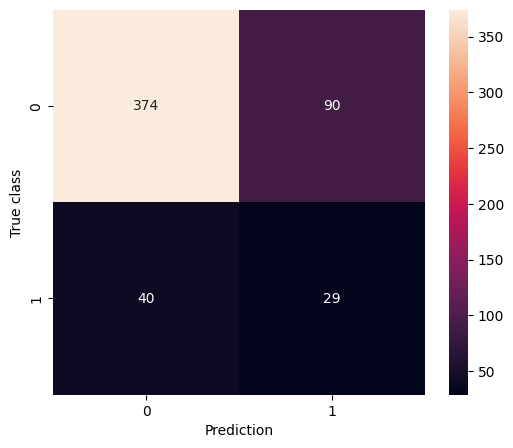

In [78]:
cm = confusion_matrix(message_val['burnout_t+3'], classifier.predict(validate_tf))
fig = plt.figure(figsize=(6,5))
ax= plt.subplot()
sns.heatmap(cm, annot=True, ax = ax, fmt = 'g');
ax.set_xlabel('Prediction')
ax.set_ylabel('True class')

In [79]:
def create_embedding(product_name, word_embeddings, vector_size = 300):
    embeddings = list()
    for token in product_name:
        if token in word_embeddings:
            embeddings.append(word_embeddings[token])
    if embeddings:
        return np.mean(embeddings, axis=0)
    else:
        return np.zeros(vector_size)

model = Word2Vec(sentences = message_data.lemmas.to_list(), vector_size = 300, min_count = 50, sg = 1)

message_train['doc_embeddings'] = message_train.lemmas.apply(lambda x: create_embedding(x, model.wv))

message_val['doc_embeddings'] = message_val.lemmas.apply(lambda x: create_embedding(x, model.wv))

classifier = GaussianNB()
classifier.fit(np.array(message_train['doc_embeddings'].tolist()), message_train['burnout_t+3'])

classification_report(message_val['burnout_t+3'], classifier.predict(np.array(message_val['doc_embeddings'].tolist()),))

'              precision    recall  f1-score   support\n\n       False       0.88      0.66      0.75       464\n        True       0.14      0.38      0.20        69\n\n    accuracy                           0.62       533\n   macro avg       0.51      0.52      0.48       533\nweighted avg       0.78      0.62      0.68       533\n'

Text(45.722222222222214, 0.5, 'True class')

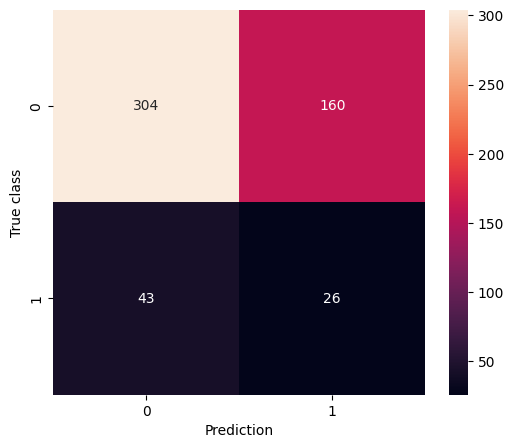

In [80]:
cm = confusion_matrix(message_val['burnout_t+3'], classifier.predict(np.array(message_val['doc_embeddings'].tolist()),))
fig = plt.figure(figsize=(6,5))
ax= plt.subplot()
sns.heatmap(cm, annot=True, ax = ax, fmt = 'g');
ax.set_xlabel('Prediction')
ax.set_ylabel('True class')

In [81]:
model = KeyedVectors.load_word2vec_format("SO_vectors_200.bin", binary=True)

message_train['doc_embeddings'] = message_train.lemmas.apply(lambda x: create_embedding(x, model, vector_size=200))

message_val['doc_embeddings'] = message_val.lemmas.apply(lambda x: create_embedding(x, model, vector_size=200))

classifier = GaussianNB()
classifier.fit(np.array(message_train['doc_embeddings'].tolist()), message_train['burnout_t+3'])

classification_report(message_val['burnout_t+3'], classifier.predict(np.array(message_val['doc_embeddings'].tolist()),))

'              precision    recall  f1-score   support\n\n       False       0.90      0.61      0.73       464\n        True       0.17      0.54      0.26        69\n\n    accuracy                           0.60       533\n   macro avg       0.53      0.57      0.49       533\nweighted avg       0.80      0.60      0.67       533\n'

Text(45.722222222222214, 0.5, 'True class')

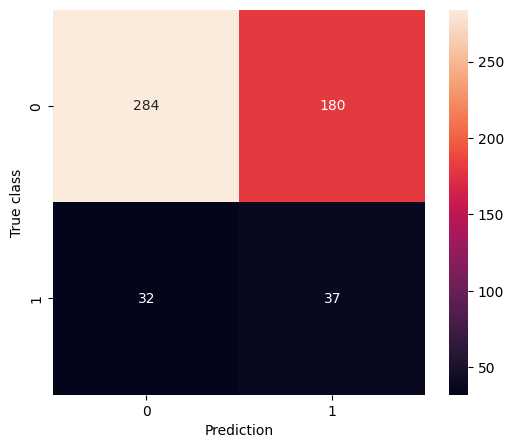

In [82]:
cm = confusion_matrix(message_val['burnout_t+3'], classifier.predict(np.array(message_val['doc_embeddings'].tolist()),))
fig = plt.figure(figsize=(6,5))
ax= plt.subplot()
sns.heatmap(cm, annot=True, ax = ax, fmt = 'g');
ax.set_xlabel('Prediction')
ax.set_ylabel('True class')

# RF models

In [83]:
def identity_tokenizer(text):
    return text

tfidf = TfidfVectorizer(tokenizer=identity_tokenizer, lowercase=False, sublinear_tf = True, min_df = round(len(message_train)/1000)+1, max_df = 0.6)

train_tf = tfidf.fit_transform(message_train['lemmas'])
validate_tf = tfidf.transform(message_val['lemmas'])

vocab = tfidf.get_feature_names_out()

# Train Naive Bayes classifier


classifier = RandomForestClassifier(n_estimators = 500, random_state = 404)
classifier.fit(train_tf, message_train['burnout_t+3'])

classification_report(message_val['burnout_t+3'], classifier.predict(validate_tf))

C:\Users\woute\OneDrive\Documenten\JADS\Thesis\venv_Thesis\Lib\site-packages\sklearn\feature_extraction\text.py:517: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


'              precision    recall  f1-score   support\n\n       False       0.89      0.97      0.93       464\n        True       0.48      0.16      0.24        69\n\n    accuracy                           0.87       533\n   macro avg       0.68      0.57      0.58       533\nweighted avg       0.83      0.87      0.84       533\n'

Text(45.722222222222214, 0.5, 'True class')

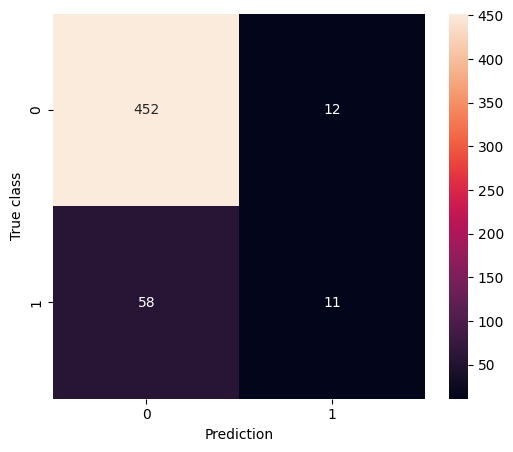

In [84]:
cm = confusion_matrix(message_val['burnout_t+3'], classifier.predict(validate_tf))
fig = plt.figure(figsize=(6,5))
ax= plt.subplot()
sns.heatmap(cm, annot=True, ax = ax, fmt = 'g');
ax.set_xlabel('Prediction')
ax.set_ylabel('True class')

In [85]:
def create_embedding(product_name, word_embeddings, vector_size = 300):
    embeddings = list()
    for token in product_name:
        if token in word_embeddings:
            embeddings.append(word_embeddings[token])
    if embeddings:
        return np.mean(embeddings, axis=0)
    else:
        return np.zeros(vector_size)

model = Word2Vec(sentences = message_data.lemmas.to_list(), vector_size = 300, min_count = 50, sg = 1)

message_train['doc_embeddings'] = message_train.lemmas.apply(lambda x: create_embedding(x, model.wv))

message_val['doc_embeddings'] = message_val.lemmas.apply(lambda x: create_embedding(x, model.wv))

classifier = RandomForestClassifier(n_estimators = 500, random_state = 404)
classifier.fit(np.array(message_train['doc_embeddings'].tolist()), message_train['burnout_t+3'])

classification_report(message_val['burnout_t+3'], classifier.predict(np.array(message_val['doc_embeddings'].tolist()),))

'              precision    recall  f1-score   support\n\n       False       0.88      0.92      0.90       464\n        True       0.24      0.17      0.20        69\n\n    accuracy                           0.82       533\n   macro avg       0.56      0.54      0.55       533\nweighted avg       0.80      0.82      0.81       533\n'

Text(45.722222222222214, 0.5, 'True class')

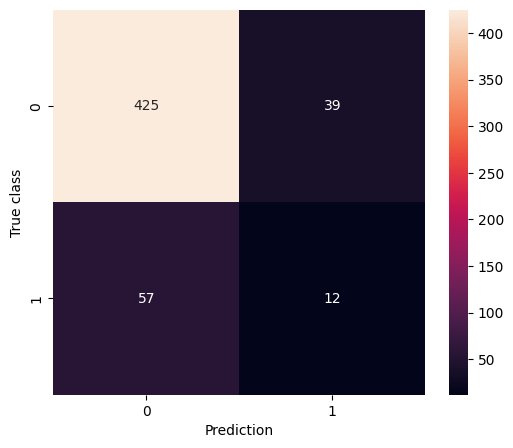

In [86]:
cm = confusion_matrix(message_val['burnout_t+3'], classifier.predict(np.array(message_val['doc_embeddings'].tolist()),))
fig = plt.figure(figsize=(6,5))
ax= plt.subplot()
sns.heatmap(cm, annot=True, ax = ax, fmt = 'g');
ax.set_xlabel('Prediction')
ax.set_ylabel('True class')

In [87]:
model = KeyedVectors.load_word2vec_format("SO_vectors_200.bin", binary=True)

message_train['doc_embeddings'] = message_train.lemmas.apply(lambda x: create_embedding(x, model, vector_size=200))

message_val['doc_embeddings'] = message_val.lemmas.apply(lambda x: create_embedding(x, model, vector_size=200))

classifier = RandomForestClassifier(n_estimators = 500, random_state = 404)
classifier.fit(np.array(message_train['doc_embeddings'].tolist()), message_train['burnout_t+3'])

classification_report(message_val['burnout_t+3'], classifier.predict(np.array(message_val['doc_embeddings'].tolist()),))

'              precision    recall  f1-score   support\n\n       False       0.89      1.00      0.94       464\n        True       0.90      0.13      0.23        69\n\n    accuracy                           0.89       533\n   macro avg       0.89      0.56      0.58       533\nweighted avg       0.89      0.89      0.85       533\n'

Text(45.722222222222214, 0.5, 'True class')

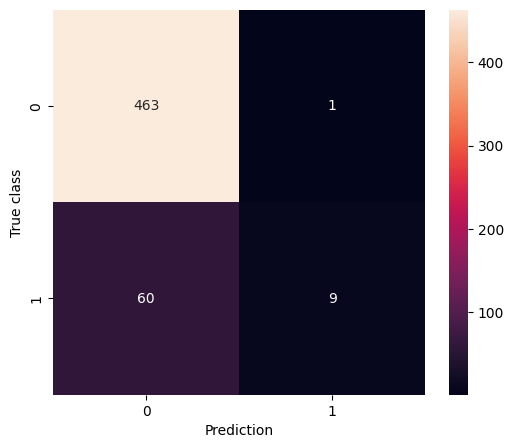

In [88]:
cm = confusion_matrix(message_val['burnout_t+3'], classifier.predict(np.array(message_val['doc_embeddings'].tolist()),))
fig = plt.figure(figsize=(6,5))
ax= plt.subplot()
sns.heatmap(cm, annot=True, ax = ax, fmt = 'g');
ax.set_xlabel('Prediction')
ax.set_ylabel('True class')

## Burnout T+12

In [89]:
burnout_logistic_data = logistic_data[~logistic_data.burnout.isna()].drop(['burnout_t+1', 'burnout_t+3', 'burnout', 'ragequit_t+1', 'ragequit_t+3', 'ragequit_t+12', 'git_close'], axis = 1).drop_duplicates().drop(['Alias', 'From', 'To', 'start_datetime', 'end_datetime', 'lagged_burnout', 'reply_close', 'working_months', 'quit', 'first_quit_month', 'git_degree', 'Workload'], axis = 1).dropna().astype({'burnout_t+12':bool})
logistic_train_data, logistic_test_data = train_test_split(burnout_logistic_data, test_size = 0.2, random_state = 404, stratify = burnout_logistic_data['burnout_t+12'])

In [90]:
lr_model = LogisticRegressionCV(max_iter = 1000000).fit(logistic_train_data.drop('burnout_t+12', axis = 1), logistic_train_data['burnout_t+12'])

Text(45.722222222222214, 0.5, 'True class')

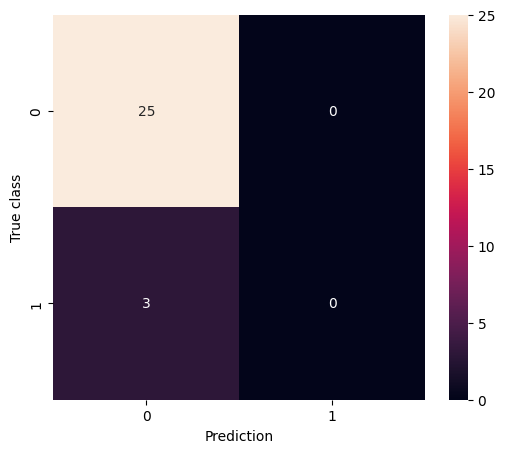

In [91]:
cm = confusion_matrix(logistic_test_data['burnout_t+12'], lr_model.predict(logistic_test_data.drop('burnout_t+12', axis = 1)))
fig = plt.figure(figsize=(6,5))
ax= plt.subplot()
sns.heatmap(cm, annot=True, ax = ax, fmt = 'g');
ax.set_xlabel('Prediction')
ax.set_ylabel('True class')

statsmodels

In [92]:
stat_model = sm.Logit(logistic_train_data['burnout_t+12'].astype(float), sm.add_constant(logistic_train_data.drop('burnout_t+12', axis = 1)).astype(float)).fit(disp = 0)
stat_model.summary()

C:\Users\woute\OneDrive\Documenten\JADS\Thesis\venv_Thesis\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:           burnout_t+12   No. Observations:                  112
Model:                          Logit   Df Residuals:                       98
Method:                           MLE   Df Model:                           13
Date:                Thu, 29 May 2025   Pseudo R-squ.:                  0.4463
Time:                        15:08:01   Log-Likelihood:                -22.265
converged:                      False   LL-Null:                       -40.211
Covariance Type:            nonrobust   LLR p-value:                 0.0006167
=========================================================================================
                            coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                   -21.4308   4.06e+04     -0.001      1.000   -7.95e+04    7.95e+04
Avg. distance            -0.0166      0.430     -0.039      0.969      -0.860       0.827
Lone Wolf                -1.9133      1.423     -1.344      0.179      -4.703       0.876
Messages Sent             0.0197      0.021      0.953      0.341      -0.021       0.060
Organisational Silo       1.4711      1.546      0.951      0.341      -1.559       4.502
Radio Silence            18.9603   4.06e+04      0.000      1.000   -7.95e+04    7.95e+04
standardized_workload     0.1281      0.134      0.956      0.339      -0.135       0.391
black_cloud               1.6357      0.937      1.745      0.081      -0.202       3.473
st_congruence             1.8462      2.483      0.744      0.457      -3.020       6.712
reply_degree             10.2215     20.442      0.500      0.617     -29.845      50.288
reply_between           -47.0982     33.934     -1.388      0.165    -113.608      19.412
git_between              13.2515      6.494      2.041      0.041       0.524      25.979
reply_density            96.7598     75.485      1.282      0.200     -51.189     244.709
git_density             -39.5077     19.498     -2.026      0.043     -77.723      -1.293
=========================================================================================

Possibly complete quasi-separation: A fraction 0.27 of observations can be
perfectly predicted. This might indicate that there is complete
quasi-separation. In this case some parameters will not be identified.
"""

Text(45.722222222222214, 0.5, 'True class')

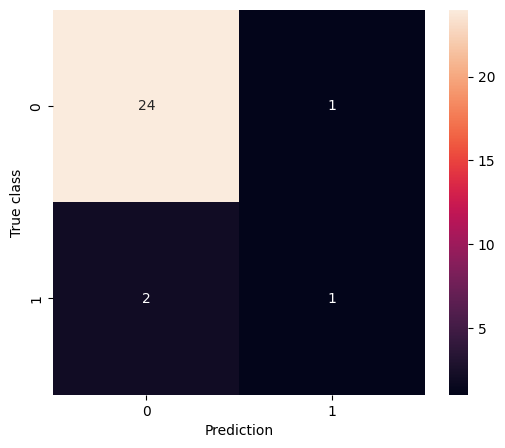

In [93]:
cm = confusion_matrix(logistic_test_data['burnout_t+12'], round(stat_model.predict(sm.add_constant(logistic_test_data.drop('burnout_t+12', axis = 1)).astype(float))).astype(int))
fig = plt.figure(figsize=(6,5))
ax= plt.subplot()
sns.heatmap(cm, annot=True, ax = ax, fmt = 'g');
ax.set_xlabel('Prediction')
ax.set_ylabel('True class')

### Burnout NB

In [94]:
message_data = all_test[['reply_body', 'burnout_t+12']].dropna()

nlp = spacy.load('en_core_web_sm')
tqdm.pandas()

message_data['lemmas'] = message_data.reply_body.progress_apply(lambda x: [token.lemma_ for token in nlp(handle_negation(x)) if not token.is_stop and token.is_alpha])
message_data['burnout_t+12'] = message_data['burnout_t+12'].astype(bool)
message_data

100%|██████████| 3646/3646 [00:40<00:00, 89.22it/s] 


,reply_body,burnout_t+12,lemmas
0,thanks ! i will look into the after,True,"[thanks, look]"
1,"@jens-g yeah, that is what is happening is rec...",True,"[g, yeah, happen, recently, add, cross, limite..."
2,stumbled upon a todo:,True,"[stumble, todo]"
3,it is essentially caused by method that is not...,True,"[essentially, cause, method]"
4,+1,True,[]
...,...,...,...
4290,changes are backwards compatible never did,False,"[change, backwards, compatible]"
4291,"this seems an obvious problem, do not know why...",False,"[obvious, problem, maybe, wrong, build, compil..."
4292,"this seems an obvious problem, do not know why...",False,"[obvious, problem, maybe, wrong, build, compil..."
4294,some helpful tipsa successfulthrift pr: * did ...,False,"[helpful, tipsa, successfulthrift, pr, test, c..."


In [95]:
message_data = message_data[message_data.apply(lambda x: len(x.lemmas), axis = 1) > 0]

message_train, message_test = train_test_split(message_data, test_size=0.15, random_state=404, stratify = message_data['burnout_t+12'])
message_train, message_val = train_test_split(message_train, test_size=(0.15/0.85), random_state=404, stratify = message_train['burnout_t+12'])

print(f'length of train set: {len(message_train)}\nlength of validation set: {len(message_val)}\nlength of test set: {len(message_test)}')
message_train = message_train[message_data.apply(lambda x: len(x.lemmas), axis = 1) > 3] # remove shorter messages

# Oversample on the True cases in the train set
if 2*message_train["burnout_t+12"].sum()<len(message_train):
   # True is the minority class
    if 3*message_train["burnout_t+12"].sum()<len(message_train):
        # We need to over- and undersample to create balance
        message_train = pd.concat([message_train.loc[message_train[message_train["burnout_t+12"]==1].index], message_train])
        print(f'Positive cases: {message_train["burnout_t+12"].sum()}')

        if 3*message_train["burnout_t+12"].sum()<len(message_train):
            # Check for massive imbalance
            message_train = pd.concat([message_train.loc[message_train[message_train["burnout_t+12"]==1].index], message_train])
            print(f'Positive cases: {message_train["burnout_t+12"].sum()}')

        nMax = message_train["burnout_t+12"].sum()
        message_train = message_train.groupby("burnout_t+12").apply(lambda x: x.sample(n=min(nMax, len(x)))).reset_index(drop = True).sample(frac=1)

        print(f'New length of train set: {len(message_train)}')
    else:
        nMax = message_train["burnout_t+12"].sum()
        # Only undersampling will do
        print(f'Positive cases: {message_train["burnout_t+12"].sum()}')
        message_train = message_train.groupby("burnout_t+12").apply(lambda x: x.sample(n=min(nMax, len(x)))).reset_index(drop = True).sample(frac=1)

        print(f'New length of train set: {len(message_train)}')


else:
    if message_train["burnout_t+12"].sum()>0.67*len(message_train):
        # False is the minority class and we need to over- and undersample
        message_train = pd.concat([message_train.loc[message_train[message_train["burnout_t+12"]==0].index], message_train])
        print(f'Positive cases: {message_train["burnout_t+12"].sum()}')

        if message_train["burnout_t+12"].sum()>0.67*len(message_train):
            # Check for massive imbalance (mainly ragequit case)
            message_train = pd.concat([message_train.loc[message_train[message_train["burnout_t+12"]==0].index], message_train])
            print(f'Positive cases: {message_train["burnout_t+12"].sum()}')

        nMax = len(message_train) - message_train["burnout_t+12"].sum()
        message_train = message_train.groupby("burnout_t+12").apply(lambda x: x.sample(n=min(nMax, len(x)))).reset_index(drop = True).sample(frac=1)

        print(f'New length of train set: {len(message_train)}')

    else:
        nMax = len(message_train) - message_train["burnout_t+12"].sum()
        print(f'Positive cases: {message_train["burnout_t+12"].sum()}')
        message_train = message_train.groupby("burnout_t+12").apply(lambda x: x.sample(n=min(nMax, len(x)))).reset_index(drop = True).sample(frac=1)

        print(f'New length of train set: {len(message_train)}')

length of train set: 2483
length of validation set: 533
length of test set: 533
Positive cases: 532
Positive cases: 1596
New length of train set: 3192


C:\Users\woute\AppData\Local\Temp\ipykernel_22328\188543492.py:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  message_train = message_train[message_data.apply(lambda x: len(x.lemmas), axis = 1) > 3] # remove shorter messages
C:\Users\woute\AppData\Local\Temp\ipykernel_22328\188543492.py:23: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  message_train = message_train.groupby("burnout_t+12").apply(lambda x: x.sample(n=min(nMax, len(x)))).reset_index(drop = True).sample(frac=1)


In [96]:
pos_labels, pos_values = zip(*Counter(itertools.chain(*message_data[message_data['burnout_t+12']].lemmas.tolist())).items())
neg_labels, neg_values = zip(*Counter(itertools.chain(*message_data[~message_data['burnout_t+12']].lemmas.tolist())).items())

importance_df = pd.DataFrame(index = list(set(pos_labels + neg_labels)), data = {'pos_occur': pd.Series(pos_values, index = pos_labels), 'neg_occur': pd.Series(neg_values, index = neg_labels)})
importance_df.fillna(0, inplace = True)
importance_df['total_appearances'] = importance_df['pos_occur'] + importance_df['neg_occur']

for i in range(0,125,25):
    p = i
    importance_df['pos_importance'] = (importance_df['pos_occur'] + p)/(importance_df['total_appearances']+2*p)
    importance_df['neg_importance'] = (importance_df['neg_occur'] + p)/(importance_df['total_appearances']+2*p)
    print(f'positive {i}:')
    print(importance_df[importance_df['total_appearances']>100].sort_values(by = 'pos_importance', ascending = False)[['pos_importance', 'pos_occur', 'total_appearances']].head(20))
    print(f'negative {i}:')
    print(importance_df[importance_df['total_appearances']>100].sort_values(by = 'neg_importance', ascending = False)[['neg_importance', 'neg_occur', 'total_appearances']].head(20))
    print('----------------------------------------------------------------------------------------------------------------------------------------------')

positive 0:
          pos_importance  pos_occur  total_appearances
pull            0.263158       70.0              266.0
patch           0.245098       50.0              204.0
request         0.209964       59.0              281.0
hi              0.208696       24.0              115.0
jira            0.195266       33.0              169.0
travis          0.187500       27.0              144.0
cause           0.172662       24.0              139.0
way             0.171779       28.0              163.0
protocol        0.166667       28.0              168.0
follow          0.165289       20.0              121.0
time            0.163265       24.0              147.0
fix             0.159353       69.0              433.0
failure         0.157895       30.0              190.0
work            0.155642       40.0              257.0
value           0.149123       17.0              114.0
like            0.147826       68.0              460.0
cross           0.146341       30.0              205.

In [97]:
def identity_tokenizer(text):
    return text

tfidf = TfidfVectorizer(tokenizer=identity_tokenizer, lowercase=False, sublinear_tf = True, min_df = round(len(message_train)/1000)+1, max_df = 0.6)

train_tf = tfidf.fit_transform(message_train['lemmas'])
validate_tf = tfidf.transform(message_val['lemmas'])

vocab = tfidf.get_feature_names_out()

# Train Naive Bayes classifier


classifier = MultinomialNB()
classifier.fit(train_tf, message_train['burnout_t+12'])

classification_report(message_val['burnout_t+12'], classifier.predict(validate_tf))

C:\Users\woute\OneDrive\Documenten\JADS\Thesis\venv_Thesis\Lib\site-packages\sklearn\feature_extraction\text.py:517: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


'              precision    recall  f1-score   support\n\n       False       0.90      0.78      0.83       459\n        True       0.24      0.45      0.31        74\n\n    accuracy                           0.73       533\n   macro avg       0.57      0.61      0.57       533\nweighted avg       0.81      0.73      0.76       533\n'

Text(45.722222222222214, 0.5, 'True class')

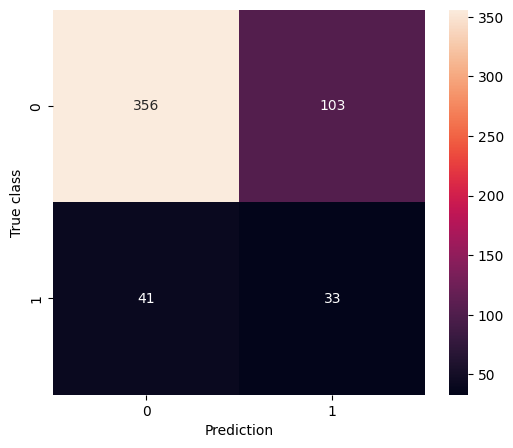

In [98]:
cm = confusion_matrix(message_val['burnout_t+12'], classifier.predict(validate_tf))
fig = plt.figure(figsize=(6,5))
ax= plt.subplot()
sns.heatmap(cm, annot=True, ax = ax, fmt = 'g');
ax.set_xlabel('Prediction')
ax.set_ylabel('True class')

In [99]:
def create_embedding(product_name, word_embeddings, vector_size = 300):
    embeddings = list()
    for token in product_name:
        if token in word_embeddings:
            embeddings.append(word_embeddings[token])
    if embeddings:
        return np.mean(embeddings, axis=0)
    else:
        return np.zeros(vector_size)

model = Word2Vec(sentences = message_data.lemmas.to_list(), vector_size = 300, min_count = 50, sg = 1)

message_train['doc_embeddings'] = message_train.lemmas.apply(lambda x: create_embedding(x, model.wv))

message_val['doc_embeddings'] = message_val.lemmas.apply(lambda x: create_embedding(x, model.wv))

classifier = GaussianNB()
classifier.fit(np.array(message_train['doc_embeddings'].tolist()), message_train['burnout_t+12'])

classification_report(message_val['burnout_t+12'], classifier.predict(np.array(message_val['doc_embeddings'].tolist()),))

'              precision    recall  f1-score   support\n\n       False       0.87      0.67      0.75       459\n        True       0.15      0.36      0.21        74\n\n    accuracy                           0.62       533\n   macro avg       0.51      0.52      0.48       533\nweighted avg       0.77      0.62      0.68       533\n'

Text(45.722222222222214, 0.5, 'True class')

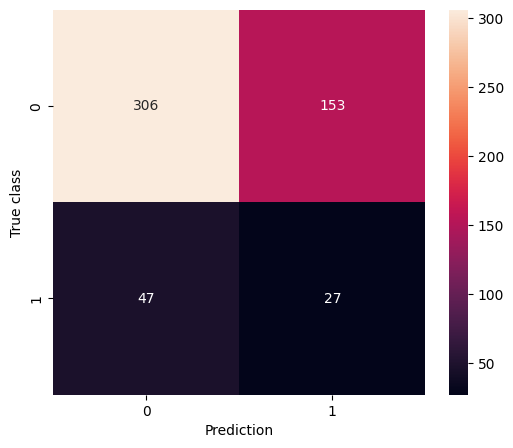

In [100]:
cm = confusion_matrix(message_val['burnout_t+12'], classifier.predict(np.array(message_val['doc_embeddings'].tolist()),))
fig = plt.figure(figsize=(6,5))
ax= plt.subplot()
sns.heatmap(cm, annot=True, ax = ax, fmt = 'g');
ax.set_xlabel('Prediction')
ax.set_ylabel('True class')

In [101]:
model = KeyedVectors.load_word2vec_format("SO_vectors_200.bin", binary=True)

message_train['doc_embeddings'] = message_train.lemmas.apply(lambda x: create_embedding(x, model, vector_size=200))

message_val['doc_embeddings'] = message_val.lemmas.apply(lambda x: create_embedding(x, model, vector_size=200))

classifier = GaussianNB()
classifier.fit(np.array(message_train['doc_embeddings'].tolist()), message_train['burnout_t+12'])

classification_report(message_val['burnout_t+12'], classifier.predict(np.array(message_val['doc_embeddings'].tolist()),))

'              precision    recall  f1-score   support\n\n       False       0.88      0.67      0.76       459\n        True       0.18      0.45      0.25        74\n\n    accuracy                           0.64       533\n   macro avg       0.53      0.56      0.51       533\nweighted avg       0.78      0.64      0.69       533\n'

Text(45.722222222222214, 0.5, 'True class')

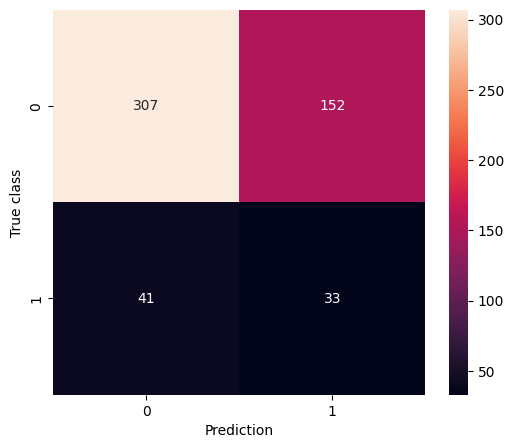

In [102]:
cm = confusion_matrix(message_val['burnout_t+12'], classifier.predict(np.array(message_val['doc_embeddings'].tolist()),))
fig = plt.figure(figsize=(6,5))
ax= plt.subplot()
sns.heatmap(cm, annot=True, ax = ax, fmt = 'g');
ax.set_xlabel('Prediction')
ax.set_ylabel('True class')

# RF models

In [103]:
def identity_tokenizer(text):
    return text

tfidf = TfidfVectorizer(tokenizer=identity_tokenizer, lowercase=False, sublinear_tf = True, min_df = round(len(message_train)/1000)+1, max_df = 0.6)

train_tf = tfidf.fit_transform(message_train['lemmas'])
validate_tf = tfidf.transform(message_val['lemmas'])

vocab = tfidf.get_feature_names_out()

# Train Naive Bayes classifier


classifier = RandomForestClassifier(n_estimators = 500, random_state = 404)
classifier.fit(train_tf, message_train['burnout_t+12'])

classification_report(message_val['burnout_t+12'], classifier.predict(validate_tf))

C:\Users\woute\OneDrive\Documenten\JADS\Thesis\venv_Thesis\Lib\site-packages\sklearn\feature_extraction\text.py:517: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


'              precision    recall  f1-score   support\n\n       False       0.88      0.98      0.93       459\n        True       0.55      0.16      0.25        74\n\n    accuracy                           0.86       533\n   macro avg       0.71      0.57      0.59       533\nweighted avg       0.83      0.86      0.83       533\n'

Text(45.722222222222214, 0.5, 'True class')

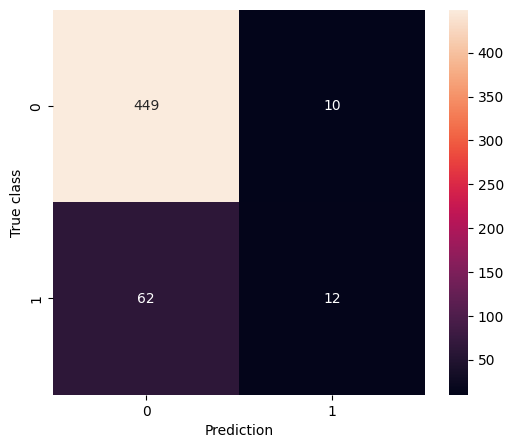

In [104]:
cm = confusion_matrix(message_val['burnout_t+12'], classifier.predict(validate_tf))
fig = plt.figure(figsize=(6,5))
ax= plt.subplot()
sns.heatmap(cm, annot=True, ax = ax, fmt = 'g');
ax.set_xlabel('Prediction')
ax.set_ylabel('True class')

In [105]:
def create_embedding(product_name, word_embeddings, vector_size = 300):
    embeddings = list()
    for token in product_name:
        if token in word_embeddings:
            embeddings.append(word_embeddings[token])
    if embeddings:
        return np.mean(embeddings, axis=0)
    else:
        return np.zeros(vector_size)

model = Word2Vec(sentences = message_data.lemmas.to_list(), vector_size = 300, min_count = 50, sg = 1)

message_train['doc_embeddings'] = message_train.lemmas.apply(lambda x: create_embedding(x, model.wv))

message_val['doc_embeddings'] = message_val.lemmas.apply(lambda x: create_embedding(x, model.wv))

classifier = RandomForestClassifier(n_estimators = 500, random_state = 404)
classifier.fit(np.array(message_train['doc_embeddings'].tolist()), message_train['burnout_t+12'])

classification_report(message_val['burnout_t+12'], classifier.predict(np.array(message_val['doc_embeddings'].tolist()),))

'              precision    recall  f1-score   support\n\n       False       0.87      0.98      0.92       459\n        True       0.39      0.09      0.15        74\n\n    accuracy                           0.85       533\n   macro avg       0.63      0.54      0.54       533\nweighted avg       0.80      0.85      0.81       533\n'

Text(45.722222222222214, 0.5, 'True class')

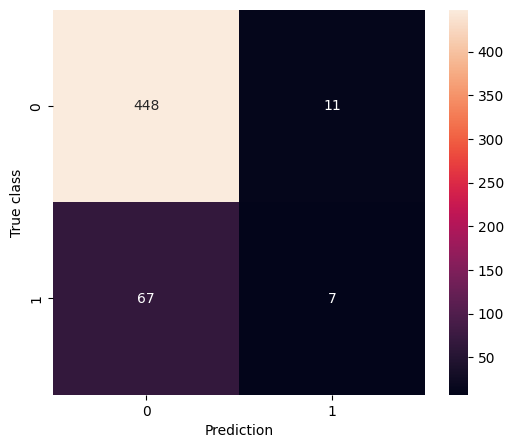

In [106]:
cm = confusion_matrix(message_val['burnout_t+12'], classifier.predict(np.array(message_val['doc_embeddings'].tolist()),))
fig = plt.figure(figsize=(6,5))
ax= plt.subplot()
sns.heatmap(cm, annot=True, ax = ax, fmt = 'g');
ax.set_xlabel('Prediction')
ax.set_ylabel('True class')

In [107]:
model = KeyedVectors.load_word2vec_format("SO_vectors_200.bin", binary=True)

message_train['doc_embeddings'] = message_train.lemmas.apply(lambda x: create_embedding(x, model, vector_size=200))

message_val['doc_embeddings'] = message_val.lemmas.apply(lambda x: create_embedding(x, model, vector_size=200))

classifier = RandomForestClassifier(n_estimators = 500, random_state = 404)
classifier.fit(np.array(message_train['doc_embeddings'].tolist()), message_train['burnout_t+12'])

classification_report(message_val['burnout_t+12'], classifier.predict(np.array(message_val['doc_embeddings'].tolist()),))

'              precision    recall  f1-score   support\n\n       False       0.87      1.00      0.93       459\n        True       0.78      0.09      0.17        74\n\n    accuracy                           0.87       533\n   macro avg       0.82      0.55      0.55       533\nweighted avg       0.86      0.87      0.82       533\n'

Text(45.722222222222214, 0.5, 'True class')

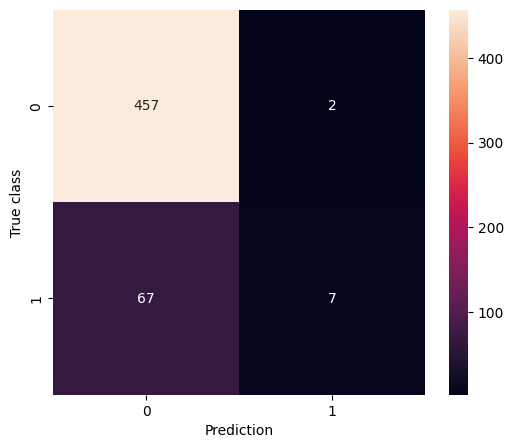

In [108]:
cm = confusion_matrix(message_val['burnout_t+12'], classifier.predict(np.array(message_val['doc_embeddings'].tolist()),))
fig = plt.figure(figsize=(6,5))
ax= plt.subplot()
sns.heatmap(cm, annot=True, ax = ax, fmt = 'g');
ax.set_xlabel('Prediction')
ax.set_ylabel('True class')

## Ragequit T+3

In [109]:
burnout_logistic_data = logistic_data[~logistic_data.burnout.isna()].drop(['burnout_t+1', 'burnout_t+3', 'burnout_t+12', 'ragequit_t+1', 'burnout', 'ragequit_t+12', 'git_close'], axis = 1).drop_duplicates().drop(['Alias', 'From', 'To', 'start_datetime', 'end_datetime', 'lagged_burnout', 'reply_close', 'working_months', 'quit', 'first_quit_month', 'Workload'], axis = 1).dropna().astype({'ragequit_t+3':bool})
logistic_train_data, logistic_test_data = train_test_split(burnout_logistic_data, test_size = 0.2, random_state = 404, stratify = burnout_logistic_data['ragequit_t+3'])

In [110]:
lr_model = LogisticRegressionCV(max_iter = 1000000).fit(logistic_train_data.drop('ragequit_t+3', axis = 1), logistic_train_data['ragequit_t+3'])

Text(45.722222222222214, 0.5, 'True class')

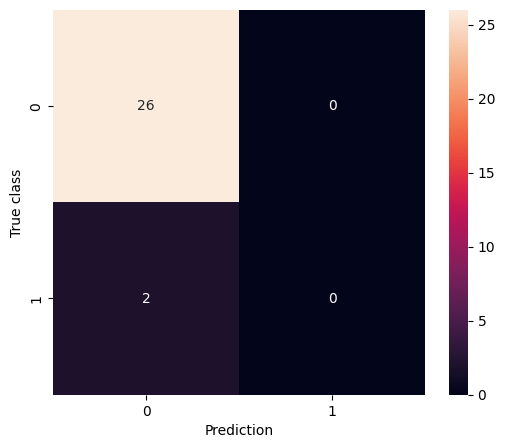

In [111]:
cm = confusion_matrix(logistic_test_data['ragequit_t+3'], lr_model.predict(logistic_test_data.drop('ragequit_t+3', axis = 1)))
fig = plt.figure(figsize=(6,5))
ax= plt.subplot()
sns.heatmap(cm, annot=True, ax = ax, fmt = 'g');
ax.set_xlabel('Prediction')
ax.set_ylabel('True class')

statsmodels

In [112]:
stat_model = sm.Logit(logistic_train_data['ragequit_t+3'].astype(float), sm.add_constant(logistic_train_data.drop('ragequit_t+3', axis = 1)).astype(float)).fit(disp = 0)
stat_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:           ragequit_t+3   No. Observations:                  112
Model:                          Logit   Df Residuals:                       97
Method:                           MLE   Df Model:                           14
Date:                Thu, 29 May 2025   Pseudo R-squ.:                  0.1918
Time:                        15:10:06   Log-Likelihood:                -25.313
converged:                       True   LL-Null:                       -31.320
Covariance Type:            nonrobust   LLR p-value:                    0.6053
=========================================================================================
                            coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                     0.5590      2.796      0.200      0.842      -4.921       6.039
Avg. distance             0.0990      0.381      0.260      0.795      -0.648       0.846
Lone Wolf                -1.1760      1.544     -0.762      0.446      -4.203       1.851
Messages Sent            -0.0918      0.082     -1.116      0.265      -0.253       0.069
Organisational Silo       0.0790      1.398      0.057      0.955      -2.661       2.819
Radio Silence            -1.2134      1.269     -0.956      0.339      -3.701       1.274
standardized_workload    -0.4798      0.691     -0.695      0.487      -1.834       0.874
black_cloud               0.0610      1.302      0.047      0.963      -2.491       2.613
st_congruence            -2.2472      2.225     -1.010      0.313      -6.609       2.114
reply_degree              8.6589      9.435      0.918      0.359      -9.834      27.152
reply_between           -11.0171     13.159     -0.837      0.402     -36.808      14.774
git_degree               -4.5689      8.684     -0.526      0.599     -21.590      12.452
git_between               3.7949      9.721      0.390      0.696     -15.258      22.847
reply_density            13.8901     48.123      0.289      0.773     -80.429     108.209
git_density              -7.4125     13.990     -0.530      0.596     -34.832      20.007
=========================================================================================
"""

Text(45.722222222222214, 0.5, 'True class')

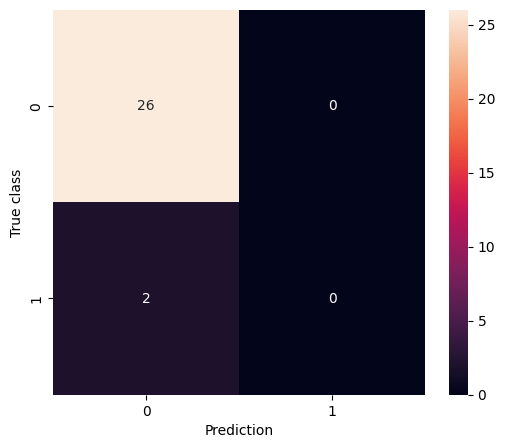

In [113]:
cm = confusion_matrix(logistic_test_data['ragequit_t+3'], round(stat_model.predict(sm.add_constant(logistic_test_data.drop('ragequit_t+3', axis = 1)).astype(float))).astype(int))
fig = plt.figure(figsize=(6,5))
ax= plt.subplot()
sns.heatmap(cm, annot=True, ax = ax, fmt = 'g');
ax.set_xlabel('Prediction')
ax.set_ylabel('True class')

### Burnout NB

In [114]:
message_data = all_test[['reply_body', 'ragequit_t+3']].dropna()

nlp = spacy.load('en_core_web_sm')
tqdm.pandas()

message_data['lemmas'] = message_data.reply_body.progress_apply(lambda x: [token.lemma_ for token in nlp(handle_negation(x)) if not token.is_stop and token.is_alpha])
message_data['ragequit_t+3'] = message_data['ragequit_t+3'].astype(bool)
message_data

100%|██████████| 3646/3646 [00:45<00:00, 79.35it/s] 


,reply_body,ragequit_t+3,lemmas
0,thanks ! i will look into the after,False,"[thanks, look]"
1,"@jens-g yeah, that is what is happening is rec...",False,"[g, yeah, happen, recently, add, cross, limite..."
2,stumbled upon a todo:,False,"[stumble, todo]"
3,it is essentially caused by method that is not...,False,"[essentially, cause, method]"
4,+1,False,[]
...,...,...,...
4290,changes are backwards compatible never did,False,"[change, backwards, compatible]"
4291,"this seems an obvious problem, do not know why...",False,"[obvious, problem, maybe, wrong, build, compil..."
4292,"this seems an obvious problem, do not know why...",False,"[obvious, problem, maybe, wrong, build, compil..."
4294,some helpful tipsa successfulthrift pr: * did ...,False,"[helpful, tipsa, successfulthrift, pr, test, c..."


In [115]:
message_data = message_data[message_data.apply(lambda x: len(x.lemmas), axis = 1) > 0]

message_train, message_test = train_test_split(message_data, test_size=0.15, random_state=404, stratify = message_data['ragequit_t+3'])
message_train, message_val = train_test_split(message_train, test_size=(0.15/0.85), random_state=404, stratify = message_train['ragequit_t+3'])

print(f'length of train set: {len(message_train)}\nlength of validation set: {len(message_val)}\nlength of test set: {len(message_test)}')
message_train = message_train[message_data.apply(lambda x: len(x.lemmas), axis = 1) > 3] # remove shorter messages

# Oversample on the True cases in the train set
if 2*message_train["ragequit_t+3"].sum()<len(message_train):
   # True is the minority class
    if 3*message_train["ragequit_t+3"].sum()<len(message_train):
        # We need to over- and undersample to create balance
        message_train = pd.concat([message_train.loc[message_train[message_train["ragequit_t+3"]==1].index], message_train])
        print(f'Positive cases: {message_train["ragequit_t+3"].sum()}')

        if 3*message_train["ragequit_t+3"].sum()<len(message_train):
            # Check for massive imbalance
            message_train = pd.concat([message_train.loc[message_train[message_train["ragequit_t+3"]==1].index], message_train])
            print(f'Positive cases: {message_train["ragequit_t+3"].sum()}')

        nMax = message_train["ragequit_t+3"].sum()
        message_train = message_train.groupby("ragequit_t+3").apply(lambda x: x.sample(n=min(nMax, len(x)))).reset_index(drop = True).sample(frac=1)

        print(f'New length of train set: {len(message_train)}')
    else:
        nMax = message_train["ragequit_t+3"].sum()
        # Only undersampling will do
        print(f'Positive cases: {message_train["ragequit_t+3"].sum()}')
        message_train = message_train.groupby("ragequit_t+3").apply(lambda x: x.sample(n=min(nMax, len(x)))).reset_index(drop = True).sample(frac=1)

        print(f'New length of train set: {len(message_train)}')


else:
    if message_train["ragequit_t+3"].sum()>0.67*len(message_train):
        # False is the minority class and we need to over- and undersample
        message_train = pd.concat([message_train.loc[message_train[message_train["ragequit_t+3"]==0].index], message_train])
        print(f'Positive cases: {message_train["ragequit_t+3"].sum()}')

        if message_train["ragequit_t+3"].sum()>0.67*len(message_train):
            # Check for massive imbalance (mainly ragequit case)
            message_train = pd.concat([message_train.loc[message_train[message_train["ragequit_t+3"]==0].index], message_train])
            print(f'Positive cases: {message_train["ragequit_t+3"].sum()}')

        nMax = len(message_train) - message_train["ragequit_t+3"].sum()
        message_train = message_train.groupby("ragequit_t+3").apply(lambda x: x.sample(n=min(nMax, len(x)))).reset_index(drop = True).sample(frac=1)

        print(f'New length of train set: {len(message_train)}')

    else:
        nMax = len(message_train) - message_train["ragequit_t+3"].sum()
        print(f'Positive cases: {message_train["ragequit_t+3"].sum()}')
        message_train = message_train.groupby("ragequit_t+3").apply(lambda x: x.sample(n=min(nMax, len(x)))).reset_index(drop = True).sample(frac=1)

        print(f'New length of train set: {len(message_train)}')

length of train set: 2483
length of validation set: 533
length of test set: 533
Positive cases: 186
Positive cases: 558
New length of train set: 1116


C:\Users\woute\AppData\Local\Temp\ipykernel_22328\3232222597.py:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  message_train = message_train[message_data.apply(lambda x: len(x.lemmas), axis = 1) > 3] # remove shorter messages
C:\Users\woute\AppData\Local\Temp\ipykernel_22328\3232222597.py:23: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  message_train = message_train.groupby("ragequit_t+3").apply(lambda x: x.sample(n=min(nMax, len(x)))).reset_index(drop = True).sample(frac=1)


In [116]:
pos_labels, pos_values = zip(*Counter(itertools.chain(*message_data[message_data['ragequit_t+3']].lemmas.tolist())).items())
neg_labels, neg_values = zip(*Counter(itertools.chain(*message_data[~message_data['ragequit_t+3']].lemmas.tolist())).items())

importance_df = pd.DataFrame(index = list(set(pos_labels + neg_labels)), data = {'pos_occur': pd.Series(pos_values, index = pos_labels), 'neg_occur': pd.Series(neg_values, index = neg_labels)})
importance_df.fillna(0, inplace = True)
importance_df['total_appearances'] = importance_df['pos_occur'] + importance_df['neg_occur']

for i in range(0,125,25):
    p = i
    importance_df['pos_importance'] = (importance_df['pos_occur'] + p)/(importance_df['total_appearances']+2*p)
    importance_df['neg_importance'] = (importance_df['neg_occur'] + p)/(importance_df['total_appearances']+2*p)
    print(f'positive {i}:')
    print(importance_df[importance_df['total_appearances']>100].sort_values(by = 'pos_importance', ascending = False)[['pos_importance', 'pos_occur', 'total_appearances']].head(20))
    print(f'negative {i}:')
    print(importance_df[importance_df['total_appearances']>100].sort_values(by = 'neg_importance', ascending = False)[['neg_importance', 'neg_occur', 'total_appearances']].head(20))
    print('----------------------------------------------------------------------------------------------------------------------------------------------')

positive 0:
                   pos_importance  pos_occur  total_appearances
dependency               0.504274       59.0              117.0
resolve                  0.408000       51.0              125.0
exception                0.350649       54.0              154.0
server                   0.176309       64.0              363.0
client                   0.174825       75.0              429.0
failure                  0.168421       32.0              190.0
version                  0.161972       46.0              284.0
test                     0.129259      129.0              998.0
directory                0.122807       14.0              114.0
java                     0.117647       12.0              102.0
compiler                 0.112299       21.0              187.0
generate                 0.111111       26.0              234.0
instead                  0.110169       13.0              118.0
check                    0.102679       23.0              224.0
work                     0.0

In [117]:
def identity_tokenizer(text):
    return text

tfidf = TfidfVectorizer(tokenizer=identity_tokenizer, lowercase=False, sublinear_tf = True, min_df = round(len(message_train)/1000)+1, max_df = 0.6)

train_tf = tfidf.fit_transform(message_train['lemmas'])
validate_tf = tfidf.transform(message_val['lemmas'])

vocab = tfidf.get_feature_names_out()

# Train Naive Bayes classifier


classifier = MultinomialNB()
classifier.fit(train_tf, message_train['ragequit_t+3'])

classification_report(message_val['ragequit_t+3'], classifier.predict(validate_tf))

C:\Users\woute\OneDrive\Documenten\JADS\Thesis\venv_Thesis\Lib\site-packages\sklearn\feature_extraction\text.py:517: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


'              precision    recall  f1-score   support\n\n       False       0.97      0.82      0.89       505\n        True       0.13      0.50      0.21        28\n\n    accuracy                           0.80       533\n   macro avg       0.55      0.66      0.55       533\nweighted avg       0.92      0.80      0.85       533\n'

Text(45.722222222222214, 0.5, 'True class')

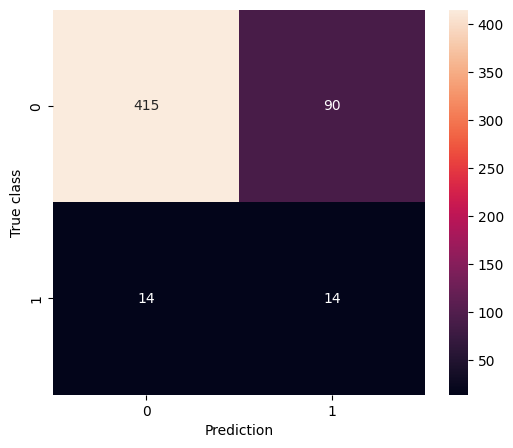

In [118]:
cm = confusion_matrix(message_val['ragequit_t+3'], classifier.predict(validate_tf))
fig = plt.figure(figsize=(6,5))
ax= plt.subplot()
sns.heatmap(cm, annot=True, ax = ax, fmt = 'g');
ax.set_xlabel('Prediction')
ax.set_ylabel('True class')

In [119]:
def create_embedding(product_name, word_embeddings, vector_size = 300):
    embeddings = list()
    for token in product_name:
        if token in word_embeddings:
            embeddings.append(word_embeddings[token])
    if embeddings:
        return np.mean(embeddings, axis=0)
    else:
        return np.zeros(vector_size)

model = Word2Vec(sentences = message_data.lemmas.to_list(), vector_size = 300, min_count = 50, sg = 1)

message_train['doc_embeddings'] = message_train.lemmas.apply(lambda x: create_embedding(x, model.wv))

message_val['doc_embeddings'] = message_val.lemmas.apply(lambda x: create_embedding(x, model.wv))

classifier = GaussianNB()
classifier.fit(np.array(message_train['doc_embeddings'].tolist()), message_train['ragequit_t+3'])

classification_report(message_val['ragequit_t+3'], classifier.predict(np.array(message_val['doc_embeddings'].tolist()),))

'              precision    recall  f1-score   support\n\n       False       0.96      0.45      0.61       505\n        True       0.06      0.64      0.11        28\n\n    accuracy                           0.46       533\n   macro avg       0.51      0.54      0.36       533\nweighted avg       0.91      0.46      0.58       533\n'

Text(45.722222222222214, 0.5, 'True class')

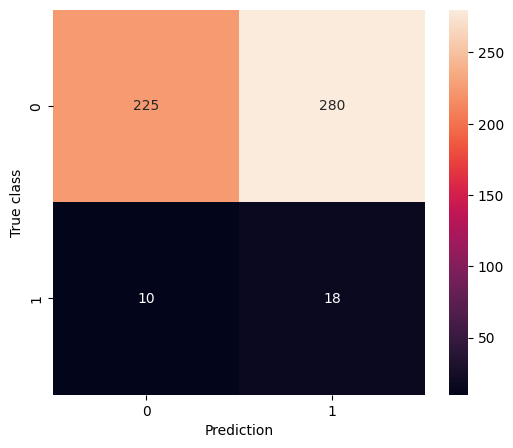

In [120]:
cm = confusion_matrix(message_val['ragequit_t+3'], classifier.predict(np.array(message_val['doc_embeddings'].tolist()),))
fig = plt.figure(figsize=(6,5))
ax= plt.subplot()
sns.heatmap(cm, annot=True, ax = ax, fmt = 'g');
ax.set_xlabel('Prediction')
ax.set_ylabel('True class')

In [121]:
model = KeyedVectors.load_word2vec_format("SO_vectors_200.bin", binary=True)

message_train['doc_embeddings'] = message_train.lemmas.apply(lambda x: create_embedding(x, model, vector_size=200))

message_val['doc_embeddings'] = message_val.lemmas.apply(lambda x: create_embedding(x, model, vector_size=200))

classifier = GaussianNB()
classifier.fit(np.array(message_train['doc_embeddings'].tolist()), message_train['ragequit_t+3'])

classification_report(message_val['ragequit_t+3'], classifier.predict(np.array(message_val['doc_embeddings'].tolist()),))

'              precision    recall  f1-score   support\n\n       False       0.94      0.70      0.80       505\n        True       0.04      0.25      0.07        28\n\n    accuracy                           0.67       533\n   macro avg       0.49      0.47      0.44       533\nweighted avg       0.90      0.67      0.76       533\n'

Text(45.722222222222214, 0.5, 'True class')

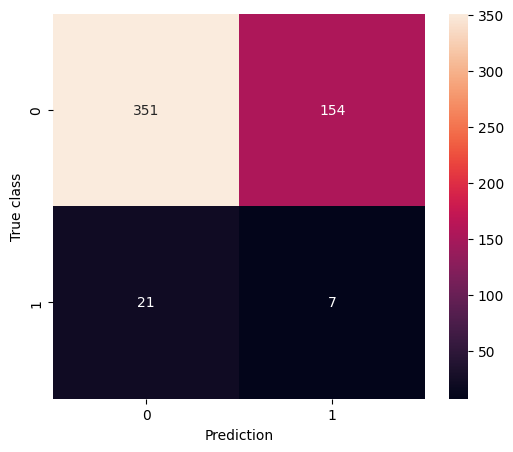

In [122]:
cm = confusion_matrix(message_val['ragequit_t+3'], classifier.predict(np.array(message_val['doc_embeddings'].tolist()),))
fig = plt.figure(figsize=(6,5))
ax= plt.subplot()
sns.heatmap(cm, annot=True, ax = ax, fmt = 'g');
ax.set_xlabel('Prediction')
ax.set_ylabel('True class')

# RF models

In [123]:
def identity_tokenizer(text):
    return text

tfidf = TfidfVectorizer(tokenizer=identity_tokenizer, lowercase=False, sublinear_tf = True, min_df = round(len(message_train)/1000)+1, max_df = 0.6)

train_tf = tfidf.fit_transform(message_train['lemmas'])
validate_tf = tfidf.transform(message_val['lemmas'])

vocab = tfidf.get_feature_names_out()

# Train Naive Bayes classifier


classifier = RandomForestClassifier(n_estimators = 500, random_state = 404)
classifier.fit(train_tf, message_train['ragequit_t+3'])

classification_report(message_val['ragequit_t+3'], classifier.predict(validate_tf))

C:\Users\woute\OneDrive\Documenten\JADS\Thesis\venv_Thesis\Lib\site-packages\sklearn\feature_extraction\text.py:517: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


'              precision    recall  f1-score   support\n\n       False       0.95      0.99      0.97       505\n        True       0.44      0.14      0.22        28\n\n    accuracy                           0.95       533\n   macro avg       0.70      0.57      0.59       533\nweighted avg       0.93      0.95      0.93       533\n'

Text(45.722222222222214, 0.5, 'True class')

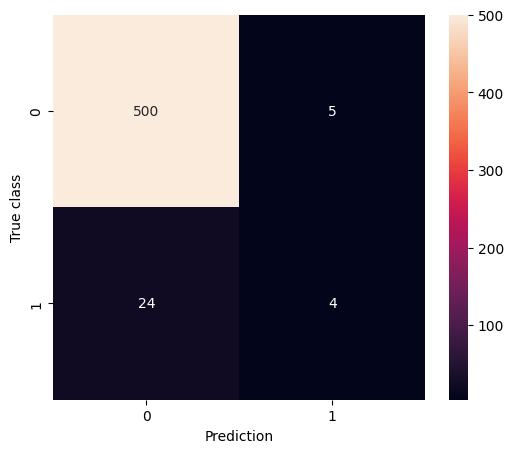

In [124]:
cm = confusion_matrix(message_val['ragequit_t+3'], classifier.predict(validate_tf))
fig = plt.figure(figsize=(6,5))
ax= plt.subplot()
sns.heatmap(cm, annot=True, ax = ax, fmt = 'g');
ax.set_xlabel('Prediction')
ax.set_ylabel('True class')

In [125]:
def create_embedding(product_name, word_embeddings, vector_size = 300):
    embeddings = list()
    for token in product_name:
        if token in word_embeddings:
            embeddings.append(word_embeddings[token])
    if embeddings:
        return np.mean(embeddings, axis=0)
    else:
        return np.zeros(vector_size)

model = Word2Vec(sentences = message_data.lemmas.to_list(), vector_size = 300, min_count = 50, sg = 1)

message_train['doc_embeddings'] = message_train.lemmas.apply(lambda x: create_embedding(x, model.wv))

message_val['doc_embeddings'] = message_val.lemmas.apply(lambda x: create_embedding(x, model.wv))

classifier = RandomForestClassifier(n_estimators = 500, random_state = 404)
classifier.fit(np.array(message_train['doc_embeddings'].tolist()), message_train['ragequit_t+3'])

classification_report(message_val['ragequit_t+3'], classifier.predict(np.array(message_val['doc_embeddings'].tolist()),))

'              precision    recall  f1-score   support\n\n       False       0.95      0.92      0.94       505\n        True       0.07      0.11      0.09        28\n\n    accuracy                           0.88       533\n   macro avg       0.51      0.51      0.51       533\nweighted avg       0.90      0.88      0.89       533\n'

Text(45.722222222222214, 0.5, 'True class')

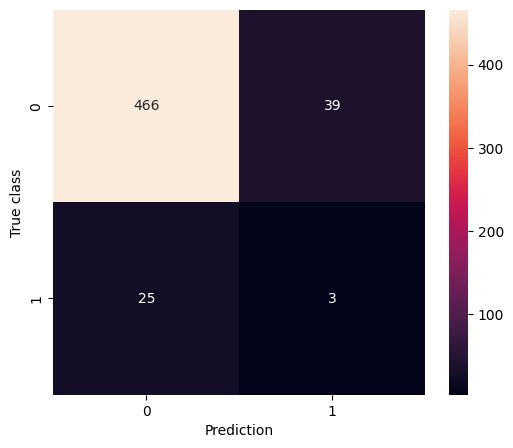

In [126]:
cm = confusion_matrix(message_val['ragequit_t+3'], classifier.predict(np.array(message_val['doc_embeddings'].tolist()),))
fig = plt.figure(figsize=(6,5))
ax= plt.subplot()
sns.heatmap(cm, annot=True, ax = ax, fmt = 'g');
ax.set_xlabel('Prediction')
ax.set_ylabel('True class')

In [127]:
model = KeyedVectors.load_word2vec_format("SO_vectors_200.bin", binary=True)

message_train['doc_embeddings'] = message_train.lemmas.apply(lambda x: create_embedding(x, model, vector_size=200))

message_val['doc_embeddings'] = message_val.lemmas.apply(lambda x: create_embedding(x, model, vector_size=200))

classifier = RandomForestClassifier(n_estimators = 500, random_state = 404)
classifier.fit(np.array(message_train['doc_embeddings'].tolist()), message_train['ragequit_t+3'])

classification_report(message_val['ragequit_t+3'], classifier.predict(np.array(message_val['doc_embeddings'].tolist()),))

'              precision    recall  f1-score   support\n\n       False       0.95      1.00      0.97       505\n        True       0.75      0.11      0.19        28\n\n    accuracy                           0.95       533\n   macro avg       0.85      0.55      0.58       533\nweighted avg       0.94      0.95      0.93       533\n'

Text(45.722222222222214, 0.5, 'True class')

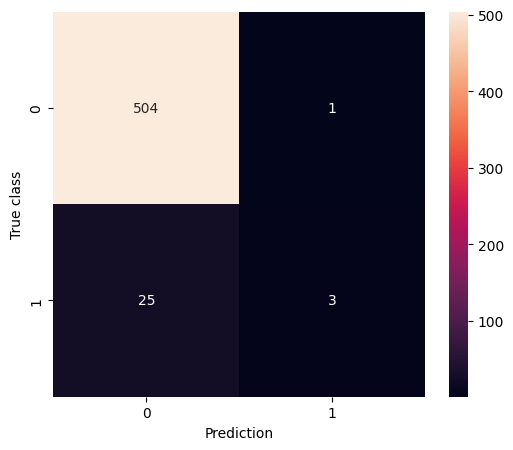

In [128]:
cm = confusion_matrix(message_val['ragequit_t+3'], classifier.predict(np.array(message_val['doc_embeddings'].tolist()),))
fig = plt.figure(figsize=(6,5))
ax= plt.subplot()
sns.heatmap(cm, annot=True, ax = ax, fmt = 'g');
ax.set_xlabel('Prediction')
ax.set_ylabel('True class')

## Ragequit T+12

In [129]:
burnout_logistic_data = logistic_data[~logistic_data.burnout.isna()].drop(['burnout_t+1', 'burnout_t+3', 'burnout_t+12', 'ragequit_t+1', 'ragequit_t+3', 'burnout', 'git_close'], axis = 1).drop_duplicates().drop(['Alias', 'From', 'To', 'start_datetime', 'end_datetime', 'lagged_burnout', 'reply_close', 'working_months', 'quit', 'first_quit_month', 'git_degree', 'Workload'], axis = 1).dropna().astype({'ragequit_t+12':bool})
logistic_train_data, logistic_test_data = train_test_split(burnout_logistic_data, test_size = 0.2, random_state = 404, stratify = burnout_logistic_data['ragequit_t+12'])

In [130]:
lr_model = LogisticRegressionCV(max_iter = 1000000).fit(logistic_train_data.drop('ragequit_t+12', axis = 1), logistic_train_data['ragequit_t+12'])

Text(45.722222222222214, 0.5, 'True class')

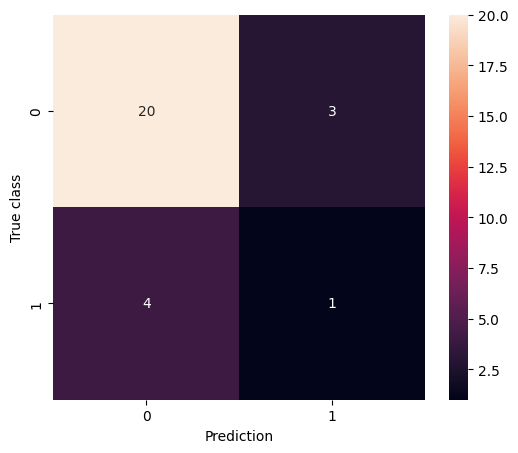

In [131]:
cm = confusion_matrix(logistic_test_data['ragequit_t+12'], lr_model.predict(logistic_test_data.drop('ragequit_t+12', axis = 1)))
fig = plt.figure(figsize=(6,5))
ax= plt.subplot()
sns.heatmap(cm, annot=True, ax = ax, fmt = 'g');
ax.set_xlabel('Prediction')
ax.set_ylabel('True class')

statsmodels

In [132]:
stat_model = sm.Logit(logistic_train_data['ragequit_t+12'].astype(float), sm.add_constant(logistic_train_data.drop('ragequit_t+12', axis = 1)).astype(float)).fit(disp = 0)
stat_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:          ragequit_t+12   No. Observations:                  112
Model:                          Logit   Df Residuals:                       98
Method:                           MLE   Df Model:                           13
Date:                Thu, 29 May 2025   Pseudo R-squ.:                  0.3072
Time:                        15:11:43   Log-Likelihood:                -34.208
converged:                       True   LL-Null:                       -49.375
Covariance Type:            nonrobust   LLR p-value:                  0.004213
=========================================================================================
                            coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                     3.8566      2.165      1.782      0.075      -0.386       8.099
Avg. distance            -0.0077      0.327     -0.024      0.981      -0.649       0.633
Lone Wolf                -1.4598      1.240     -1.178      0.239      -3.889       0.970
Messages Sent            -0.2298      0.090     -2.558      0.011      -0.406      -0.054
Organisational Silo      -1.5126      1.324     -1.143      0.253      -4.107       1.082
Radio Silence            -3.0316      1.195     -2.536      0.011      -5.374      -0.689
standardized_workload     0.1528      0.100      1.523      0.128      -0.044       0.349
black_cloud               2.1598      0.941      2.295      0.022       0.315       4.004
st_congruence            -0.0835      1.829     -0.046      0.964      -3.667       3.501
reply_degree             -0.5387      7.870     -0.068      0.945     -15.964      14.887
reply_between           -11.1647     11.297     -0.988      0.323     -33.306      10.977
git_between               1.5310      4.153      0.369      0.712      -6.608       9.670
reply_density             7.3316     43.475      0.169      0.866     -77.878      92.541
git_density              -0.9217     11.529     -0.080      0.936     -23.518      21.675
=========================================================================================

Possibly complete quasi-separation: A fraction 0.12 of observations can be
perfectly predicted. This might indicate that there is complete
quasi-separation. In this case some parameters will not be identified.
"""

Text(45.722222222222214, 0.5, 'True class')

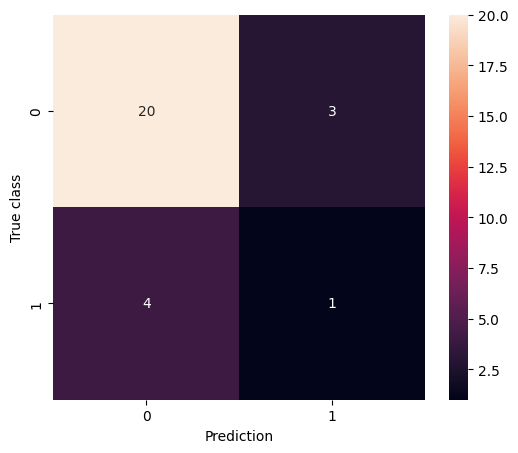

In [133]:
cm = confusion_matrix(logistic_test_data['ragequit_t+12'], round(stat_model.predict(sm.add_constant(logistic_test_data.drop('ragequit_t+12', axis = 1)).astype(float))).astype(int))
fig = plt.figure(figsize=(6,5))
ax= plt.subplot()
sns.heatmap(cm, annot=True, ax = ax, fmt = 'g');
ax.set_xlabel('Prediction')
ax.set_ylabel('True class')

### Burnout NB

In [134]:
message_data = all_test[['reply_body', 'ragequit_t+12']].dropna()

nlp = spacy.load('en_core_web_sm')
tqdm.pandas()

message_data['lemmas'] = message_data.reply_body.progress_apply(lambda x: [token.lemma_ for token in nlp(handle_negation(x)) if not token.is_stop and token.is_alpha])
message_data['ragequit_t+12'] = message_data['ragequit_t+12'].astype(bool)
message_data

100%|██████████| 3646/3646 [00:44<00:00, 82.86it/s] 


,reply_body,ragequit_t+12,lemmas
0,thanks ! i will look into the after,False,"[thanks, look]"
1,"@jens-g yeah, that is what is happening is rec...",False,"[g, yeah, happen, recently, add, cross, limite..."
2,stumbled upon a todo:,False,"[stumble, todo]"
3,it is essentially caused by method that is not...,False,"[essentially, cause, method]"
4,+1,False,[]
...,...,...,...
4290,changes are backwards compatible never did,False,"[change, backwards, compatible]"
4291,"this seems an obvious problem, do not know why...",False,"[obvious, problem, maybe, wrong, build, compil..."
4292,"this seems an obvious problem, do not know why...",False,"[obvious, problem, maybe, wrong, build, compil..."
4294,some helpful tipsa successfulthrift pr: * did ...,False,"[helpful, tipsa, successfulthrift, pr, test, c..."


In [135]:
message_data = message_data[message_data.apply(lambda x: len(x.lemmas), axis = 1) > 0]

message_train, message_test = train_test_split(message_data, test_size=0.15, random_state=404, stratify = message_data['ragequit_t+12'])
message_train, message_val = train_test_split(message_train, test_size=(0.15/0.85), random_state=404, stratify = message_train['ragequit_t+12'])

print(f'length of train set: {len(message_train)}\nlength of validation set: {len(message_val)}\nlength of test set: {len(message_test)}')
message_train = message_train[message_data.apply(lambda x: len(x.lemmas), axis = 1) > 3] # remove shorter messages

# Oversample on the True cases in the train set
if 2*message_train["ragequit_t+12"].sum()<len(message_train):
   # True is the minority class
    if 3*message_train["ragequit_t+12"].sum()<len(message_train):
        # We need to over- and undersample to create balance
        message_train = pd.concat([message_train.loc[message_train[message_train["ragequit_t+12"]==1].index], message_train])
        print(f'Positive cases: {message_train["ragequit_t+12"].sum()}')

        if 3*message_train["ragequit_t+12"].sum()<len(message_train):
            # Check for massive imbalance
            message_train = pd.concat([message_train.loc[message_train[message_train["ragequit_t+12"]==1].index], message_train])
            print(f'Positive cases: {message_train["ragequit_t+12"].sum()}')

        nMax = message_train["ragequit_t+12"].sum()
        message_train = message_train.groupby("ragequit_t+12").apply(lambda x: x.sample(n=min(nMax, len(x)))).reset_index(drop = True).sample(frac=1)

        print(f'New length of train set: {len(message_train)}')
    else:
        nMax = message_train["ragequit_t+12"].sum()
        # Only undersampling will do
        print(f'Positive cases: {message_train["ragequit_t+12"].sum()}')
        message_train = message_train.groupby("ragequit_t+12").apply(lambda x: x.sample(n=min(nMax, len(x)))).reset_index(drop = True).sample(frac=1)

        print(f'New length of train set: {len(message_train)}')


else:
    if message_train["ragequit_t+12"].sum()>0.67*len(message_train):
        # False is the minority class and we need to over- and undersample
        message_train = pd.concat([message_train.loc[message_train[message_train["ragequit_t+12"]==0].index], message_train])
        print(f'Positive cases: {message_train["ragequit_t+12"].sum()}')

        if message_train["ragequit_t+12"].sum()>0.67*len(message_train):
            # Check for massive imbalance (mainly ragequit case)
            message_train = pd.concat([message_train.loc[message_train[message_train["ragequit_t+12"]==0].index], message_train])
            print(f'Positive cases: {message_train["ragequit_t+12"].sum()}')

        nMax = len(message_train) - message_train["ragequit_t+12"].sum()
        message_train = message_train.groupby("ragequit_t+12").apply(lambda x: x.sample(n=min(nMax, len(x)))).reset_index(drop = True).sample(frac=1)

        print(f'New length of train set: {len(message_train)}')

    else:
        nMax = len(message_train) - message_train["ragequit_t+12"].sum()
        print(f'Positive cases: {message_train["ragequit_t+12"].sum()}')
        message_train = message_train.groupby("ragequit_t+12").apply(lambda x: x.sample(n=min(nMax, len(x)))).reset_index(drop = True).sample(frac=1)

        print(f'New length of train set: {len(message_train)}')

length of train set: 2483
length of validation set: 533
length of test set: 533
Positive cases: 352
Positive cases: 1056
New length of train set: 2112


C:\Users\woute\AppData\Local\Temp\ipykernel_22328\2668262174.py:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  message_train = message_train[message_data.apply(lambda x: len(x.lemmas), axis = 1) > 3] # remove shorter messages
C:\Users\woute\AppData\Local\Temp\ipykernel_22328\2668262174.py:23: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  message_train = message_train.groupby("ragequit_t+12").apply(lambda x: x.sample(n=min(nMax, len(x)))).reset_index(drop = True).sample(frac=1)


In [136]:
pos_labels, pos_values = zip(*Counter(itertools.chain(*message_data[message_data['ragequit_t+12']].lemmas.tolist())).items())
neg_labels, neg_values = zip(*Counter(itertools.chain(*message_data[~message_data['ragequit_t+12']].lemmas.tolist())).items())

importance_df = pd.DataFrame(index = list(set(pos_labels + neg_labels)), data = {'pos_occur': pd.Series(pos_values, index = pos_labels), 'neg_occur': pd.Series(neg_values, index = neg_labels)})
importance_df.fillna(0, inplace = True)
importance_df['total_appearances'] = importance_df['pos_occur'] + importance_df['neg_occur']

for i in range(0,125,25):
    p = i
    importance_df['pos_importance'] = (importance_df['pos_occur'] + p)/(importance_df['total_appearances']+2*p)
    importance_df['neg_importance'] = (importance_df['neg_occur'] + p)/(importance_df['total_appearances']+2*p)
    print(f'positive {i}:')
    print(importance_df[importance_df['total_appearances']>100].sort_values(by = 'pos_importance', ascending = False)[['pos_importance', 'pos_occur', 'total_appearances']].head(20))
    print(f'negative {i}:')
    print(importance_df[importance_df['total_appearances']>100].sort_values(by = 'neg_importance', ascending = False)[['neg_importance', 'neg_occur', 'total_appearances']].head(20))
    print('----------------------------------------------------------------------------------------------------------------------------------------------')

positive 0:
            pos_importance  pos_occur  total_appearances
dependency        0.529915       62.0              117.0
resolve           0.424000       53.0              125.0
exception         0.350649       54.0              154.0
client            0.207459       89.0              429.0
release           0.190789       29.0              152.0
failure           0.189474       36.0              190.0
server            0.187328       68.0              363.0
version           0.183099       52.0              284.0
test              0.160321      160.0              998.0
travis            0.159722       23.0              144.0
library           0.156863       32.0              204.0
instead           0.152542       18.0              118.0
remove            0.150794       19.0              126.0
generate          0.141026       33.0              234.0
compiler          0.139037       26.0              187.0
work              0.132296       34.0              257.0
time              0

In [137]:
def identity_tokenizer(text):
    return text

tfidf = TfidfVectorizer(tokenizer=identity_tokenizer, lowercase=False, sublinear_tf = True, min_df = round(len(message_train)/1000)+1, max_df = 0.6)

train_tf = tfidf.fit_transform(message_train['lemmas'])
validate_tf = tfidf.transform(message_val['lemmas'])

vocab = tfidf.get_feature_names_out()

# Train Naive Bayes classifier


classifier = MultinomialNB()
classifier.fit(train_tf, message_train['ragequit_t+12'])

classification_report(message_val['ragequit_t+12'], classifier.predict(validate_tf))

C:\Users\woute\OneDrive\Documenten\JADS\Thesis\venv_Thesis\Lib\site-packages\sklearn\feature_extraction\text.py:517: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


'              precision    recall  f1-score   support\n\n       False       0.94      0.84      0.89       483\n        True       0.26      0.52      0.34        50\n\n    accuracy                           0.81       533\n   macro avg       0.60      0.68      0.62       533\nweighted avg       0.88      0.81      0.84       533\n'

Text(45.722222222222214, 0.5, 'True class')

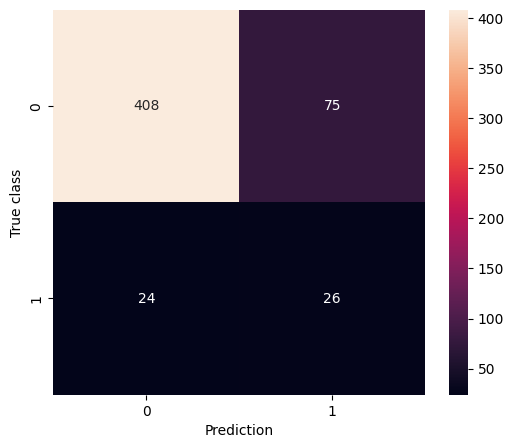

In [138]:
cm = confusion_matrix(message_val['ragequit_t+12'], classifier.predict(validate_tf))
fig = plt.figure(figsize=(6,5))
ax= plt.subplot()
sns.heatmap(cm, annot=True, ax = ax, fmt = 'g');
ax.set_xlabel('Prediction')
ax.set_ylabel('True class')

In [139]:
def create_embedding(product_name, word_embeddings, vector_size = 300):
    embeddings = list()
    for token in product_name:
        if token in word_embeddings:
            embeddings.append(word_embeddings[token])
    if embeddings:
        return np.mean(embeddings, axis=0)
    else:
        return np.zeros(vector_size)

model = Word2Vec(sentences = message_data.lemmas.to_list(), vector_size = 300, min_count = 50, sg = 1)

message_train['doc_embeddings'] = message_train.lemmas.apply(lambda x: create_embedding(x, model.wv))

message_val['doc_embeddings'] = message_val.lemmas.apply(lambda x: create_embedding(x, model.wv))

classifier = GaussianNB()
classifier.fit(np.array(message_train['doc_embeddings'].tolist()), message_train['ragequit_t+12'])

classification_report(message_val['ragequit_t+12'], classifier.predict(np.array(message_val['doc_embeddings'].tolist()),))

'              precision    recall  f1-score   support\n\n       False       0.93      0.45      0.61       483\n        True       0.11      0.66      0.19        50\n\n    accuracy                           0.47       533\n   macro avg       0.52      0.56      0.40       533\nweighted avg       0.85      0.47      0.57       533\n'

Text(45.722222222222214, 0.5, 'True class')

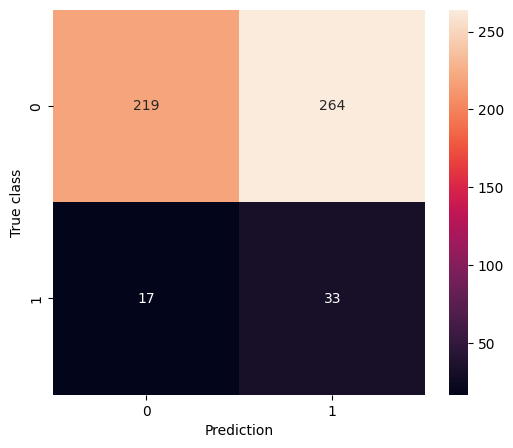

In [140]:
cm = confusion_matrix(message_val['ragequit_t+12'], classifier.predict(np.array(message_val['doc_embeddings'].tolist()),))
fig = plt.figure(figsize=(6,5))
ax= plt.subplot()
sns.heatmap(cm, annot=True, ax = ax, fmt = 'g');
ax.set_xlabel('Prediction')
ax.set_ylabel('True class')

In [141]:
model = KeyedVectors.load_word2vec_format("SO_vectors_200.bin", binary=True)

message_train['doc_embeddings'] = message_train.lemmas.apply(lambda x: create_embedding(x, model, vector_size=200))

message_val['doc_embeddings'] = message_val.lemmas.apply(lambda x: create_embedding(x, model, vector_size=200))

classifier = GaussianNB()
classifier.fit(np.array(message_train['doc_embeddings'].tolist()), message_train['ragequit_t+12'])

classification_report(message_val['ragequit_t+12'], classifier.predict(np.array(message_val['doc_embeddings'].tolist()),))

'              precision    recall  f1-score   support\n\n       False       0.92      0.64      0.75       483\n        True       0.12      0.46      0.19        50\n\n    accuracy                           0.62       533\n   macro avg       0.52      0.55      0.47       533\nweighted avg       0.84      0.62      0.70       533\n'

Text(45.722222222222214, 0.5, 'True class')

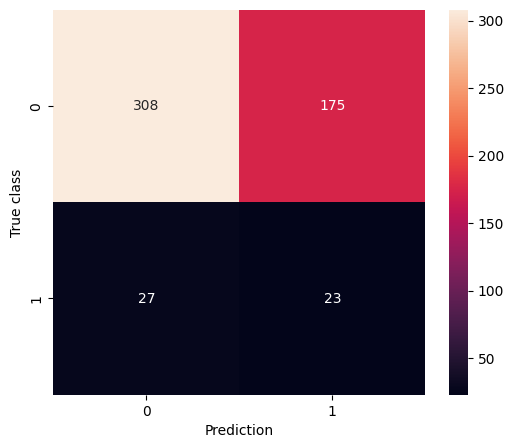

In [142]:
cm = confusion_matrix(message_val['ragequit_t+12'], classifier.predict(np.array(message_val['doc_embeddings'].tolist()),))
fig = plt.figure(figsize=(6,5))
ax= plt.subplot()
sns.heatmap(cm, annot=True, ax = ax, fmt = 'g');
ax.set_xlabel('Prediction')
ax.set_ylabel('True class')

# RF models

In [143]:
def identity_tokenizer(text):
    return text

tfidf = TfidfVectorizer(tokenizer=identity_tokenizer, lowercase=False, sublinear_tf = True, min_df = round(len(message_train)/1000), max_df = 0.6)

train_tf = tfidf.fit_transform(message_train['lemmas'])
validate_tf = tfidf.transform(message_val['lemmas'])

vocab = tfidf.get_feature_names_out()

# Train Naive Bayes classifier


classifier = RandomForestClassifier(n_estimators = 500, random_state = 404)
classifier.fit(train_tf, message_train['ragequit_t+12'])

classification_report(message_val['ragequit_t+12'], classifier.predict(validate_tf))

C:\Users\woute\OneDrive\Documenten\JADS\Thesis\venv_Thesis\Lib\site-packages\sklearn\feature_extraction\text.py:517: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


'              precision    recall  f1-score   support\n\n       False       0.92      0.98      0.95       483\n        True       0.43      0.12      0.19        50\n\n    accuracy                           0.90       533\n   macro avg       0.67      0.55      0.57       533\nweighted avg       0.87      0.90      0.88       533\n'

Text(45.722222222222214, 0.5, 'True class')

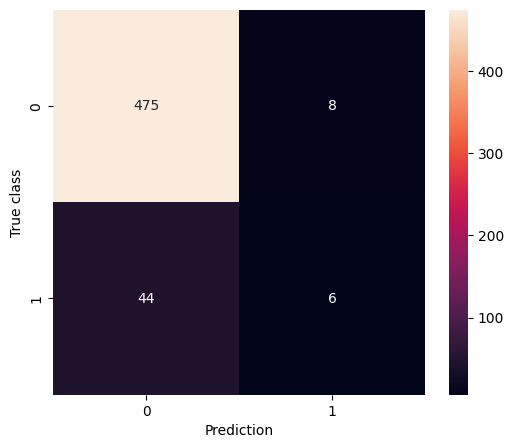

In [144]:
cm = confusion_matrix(message_val['ragequit_t+12'], classifier.predict(validate_tf))
fig = plt.figure(figsize=(6,5))
ax= plt.subplot()
sns.heatmap(cm, annot=True, ax = ax, fmt = 'g');
ax.set_xlabel('Prediction')
ax.set_ylabel('True class')

In [145]:
def create_embedding(product_name, word_embeddings, vector_size = 300):
    embeddings = list()
    for token in product_name:
        if token in word_embeddings:
            embeddings.append(word_embeddings[token])
    if embeddings:
        return np.mean(embeddings, axis=0)
    else:
        return np.zeros(vector_size)

model = Word2Vec(sentences = message_data.lemmas.to_list(), vector_size = 300, min_count = 50, sg = 1)

message_train['doc_embeddings'] = message_train.lemmas.apply(lambda x: create_embedding(x, model.wv))

message_val['doc_embeddings'] = message_val.lemmas.apply(lambda x: create_embedding(x, model.wv))

classifier = RandomForestClassifier(n_estimators = 500, random_state = 404)
classifier.fit(np.array(message_train['doc_embeddings'].tolist()), message_train['ragequit_t+12'])

classification_report(message_val['ragequit_t+12'], classifier.predict(np.array(message_val['doc_embeddings'].tolist()),))

'              precision    recall  f1-score   support\n\n       False       0.92      0.92      0.92       483\n        True       0.21      0.20      0.20        50\n\n    accuracy                           0.85       533\n   macro avg       0.56      0.56      0.56       533\nweighted avg       0.85      0.85      0.85       533\n'

Text(45.722222222222214, 0.5, 'True class')

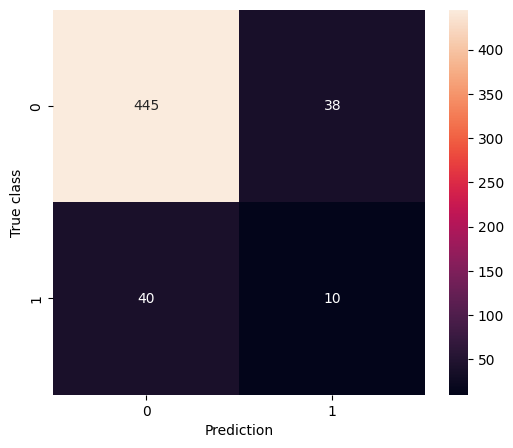

In [146]:
cm = confusion_matrix(message_val['ragequit_t+12'], classifier.predict(np.array(message_val['doc_embeddings'].tolist()),))
fig = plt.figure(figsize=(6,5))
ax= plt.subplot()
sns.heatmap(cm, annot=True, ax = ax, fmt = 'g');
ax.set_xlabel('Prediction')
ax.set_ylabel('True class')

In [147]:
model = KeyedVectors.load_word2vec_format("SO_vectors_200.bin", binary=True)

message_train['doc_embeddings'] = message_train.lemmas.apply(lambda x: create_embedding(x, model, vector_size=200))

message_val['doc_embeddings'] = message_val.lemmas.apply(lambda x: create_embedding(x, model, vector_size=200))

classifier = RandomForestClassifier(n_estimators = 500, random_state = 404)
classifier.fit(np.array(message_train['doc_embeddings'].tolist()), message_train['ragequit_t+12'])

classification_report(message_val['ragequit_t+12'], classifier.predict(np.array(message_val['doc_embeddings'].tolist()),))

'              precision    recall  f1-score   support\n\n       False       0.91      1.00      0.95       483\n        True       1.00      0.04      0.08        50\n\n    accuracy                           0.91       533\n   macro avg       0.95      0.52      0.51       533\nweighted avg       0.92      0.91      0.87       533\n'

Text(45.722222222222214, 0.5, 'True class')

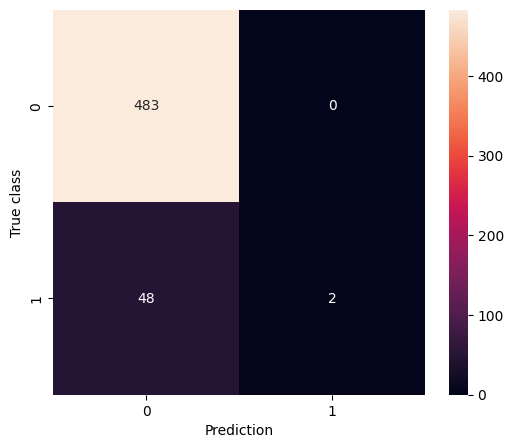

In [148]:
cm = confusion_matrix(message_val['ragequit_t+12'], classifier.predict(np.array(message_val['doc_embeddings'].tolist()),))
fig = plt.figure(figsize=(6,5))
ax= plt.subplot()
sns.heatmap(cm, annot=True, ax = ax, fmt = 'g');
ax.set_xlabel('Prediction')
ax.set_ylabel('True class')